# Выпускной проект: "Прогнозирование температуры варки стали".

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.  

Описание этапа обработки:
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

## Цель проекта

Разработать модель, предсказывающую температуру расплавленной стали, на основе имитации технологического процесса заказчика. Требования по метрике качества: МАЕ < 6.8 на тестовой выборке.

## План работы

1. Загрузка данных.
2. Исследовательский анализ и предобработка каждого датафрейма.
3. Объединение данных.
4. Исследовательский анализ и прелобработка данных объединённого датафрейма.
5. Подготовка данных для машинного обучения.
6. Обучение моделей машинного обучения.
7. Выбор лучшей модели, проверка её качества на тестовой выборке, проверка адекватности модели и важности признаков.
8. Общий вывод и рекомендации заказчику.

## Общее описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- **data_arc_new.csv** — данные об электродах;
- **data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);
- **data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);
- **data_gas_new.csv** — данные о продувке сплава газом;
- **data_temp_new.csv** — результаты измерения температуры;
- **data_wire_new.csv** — данные о проволочных материалах (объём);
- **data_wire_time_new.csv** — данные о проволочных материалах (время).

## Натройка окружения

In [1]:
!pip install shap --q

In [2]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import shap
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor
warnings.filterwarnings('ignore')

## Функции

In [3]:
# функция загрузки данных
def data_download(name):
    path_1 = '/datasets/' + name + '.csv'
    path_2 = 'https://code.s3.yandex.net/datasets/' + name + '.csv'
    if os.path.exists(path_1):
        data = pd.read_csv(path_1)
        print(name,':Данные успешно загружены из источника 1')
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2)
        print(name,':Данные успешно загружены из источника 2')
    else:
        print('Что-то ношло не так!!!')
    return data

In [4]:
# функция для изучения общих сведений по датафреймам и приведения даты в нужный формат
def data_exam(data):
    list_object = []
    list_num = []
    for column in data.columns:
        if data[column].dtype == 'object':
            list_object.append(column)
        elif data[column].dtype == 'int64' or 'float64':
            list_num.append(column)
    for value in list_object:
        data[value] = pd.to_datetime(data[value])
    data.info()
    print('*' * 70)
    print('Размерность таблицы:\n', data.shape)
    print('*' * 70)
    display(data.head())
    print('*' * 70)
    print('Пропуски:' + '\n', pd.concat([data.isna().sum(), 100 * data.isna().sum() / len(data)],\
                                                    axis=1, keys=['количество', '%']))
    print('*' * 70)
    print('Названия столбцов:\n', list(data))
    print('*' * 70)
    print('Количество явных дубликатов:\n', data.duplicated().sum())
    print('*' * 70)
    if 'key' in data.columns:
        print('Уникальные значения:\n')
        print('Столбец key:', data['key'].unique(), '\n')
        list_num.remove('key')
        
    print('*' * 70)
    if list_num != []:
        print('Числовые столбцы')
        for i in list_num:
            plt.figure(figsize=(15, 5))
            plt.suptitle(i)
            plt.subplot(1, 2, 1)
            ax1 = sns.histplot(data[i], bins=50)
            ax1.set_xlabel('Значения')
            ax1.set_ylabel('Частота')
            plt.subplot(1, 2, 2)
            ax2 = sns.boxplot(data[i])
            ax2.set_xlabel('Значения')
            plt.show()
            display(data[i].describe())
        print('*' * 70)
        print('Количество нулевых значений в числовых столбцах')    
        for i in list_num:
            print(i, ':', (data[i]==0).sum())

In [5]:
# функция просмотра количества номеров партий
def key_unique(list_data):
    for data in list_data:
        print('Количество партий в датафрейме', data, ': ', len(globals()[data]['key'].unique()))

In [6]:
# функция получения фрейма с временем введения первой/последней добавки в партии
def edge_dopant(data, name_1, name_2):
    list_c = data.columns.tolist()
    data[name_1] = pd.DataFrame(data[list_c].min(axis=1))
    data[name_2] = pd.DataFrame(data[list_c].max(axis=1))
    data_out = pd.concat([data[name_1], data[name_2]], axis=1, join='inner')
    return data_out

In [7]:
# функция объединения фреймов добавок
def dopant_concat(data_1, data_2, name):
    globals()[name] = pd.concat([data_1, data_2], axis=1, join='inner')
    return globals()[name]

In [8]:
# функция агрегирования по партиям первой/последней температуры с временем измерения
def edge_temp(data, name, agg_func, columns_names):
    globals()[name] = df_temp.pivot_table(values='time', index = 'key', aggfunc=agg_func)
    data_out = pd.merge(globals()[name], data, on='time').set_index('key')
    data_out.columns = columns_names
    return data_out

In [9]:
# функция отрисовки двух графиков для числовых данных
def numeric_plot(data):
    plt.figure(figsize=(15, 5))
    plt.suptitle(data.name)
    plt.subplot(1, 2, 1)
    ax1 = sns.histplot(data, bins=50)
    ax1.set_xlabel('Значения')
    ax1.set_ylabel('Частота')
    plt.subplot(1, 2, 2)
    ax2 = sns.boxplot(data.values)
    ax2.set_xlabel('Значения')
    plt.show()
    display(data.describe())

In [10]:
# функция отрисовки кореляционной матрицы
def corr_matrix(data):
    plt.figure(figsize=(25,15))
    corr_matrix = round(data.corr(), 2)
    ax = sns.heatmap(corr_matrix, annot=True, linewidth=0.5, cmap='coolwarm')
    plt.show()

## Константы

In [11]:
# начальное значение генератора псевдослучайных чисел
RANDOM_STATE = 141024

# постоянна кросс-валидации
CV = 5

# лист названий первоначальных датафреймов
list_datas = ['data_arc_new', 'data_bulk_new', 'data_bulk_time_new', 'data_gas_new', 'data_temp_new',\
              'data_wire_new', 'data_wire_time_new']

# лист названий датафреймов для обработки
list_dfs = ['total_arc', 'total_bulk', 'total_gas', 'total_temp', 'total_wire']

## Загрузка данных

In [12]:
for data in list_datas:
    globals()[data] = data_download(data)

data_arc_new :Данные успешно загружены из источника 1
data_bulk_new :Данные успешно загружены из источника 1
data_bulk_time_new :Данные успешно загружены из источника 1
data_gas_new :Данные успешно загружены из источника 1
data_temp_new :Данные успешно загружены из источника 1
data_wire_new :Данные успешно загружены из источника 1
data_wire_time_new :Данные успешно загружены из источника 1


## Изучение данных

### Сравнение количества партий в разных датасетах

In [13]:
# посмотрим сколько партий варки стали представлено в наших датасетах
key_unique(list_datas)

Количество партий в датафрейме data_arc_new :  3214
Количество партий в датафрейме data_bulk_new :  3129
Количество партий в датафрейме data_bulk_time_new :  3129
Количество партий в датафрейме data_gas_new :  3239
Количество партий в датафрейме data_temp_new :  3216
Количество партий в датафрейме data_wire_new :  3081
Количество партий в датафрейме data_wire_time_new :  3081


Видно, что количество партий различается, в различных датафреймах. Больше всего партий описано в датасете **data_gas**. Меньше всего партий в датасетах, описывающих информацию о проволчных материалах (**data_wire** и **data_wire_time**). Часть датафреймов имеют одинаковое количество описанных партий: 
- данные о сыпучих материалах (**data_bulk** и **data_bulk_time**) - по 3129 партий;
- данные о провочных материалы (**data_wire** и **data_wire_time**) - по 3081 партии.

При подготовке данных, нужно будет учесть эти моменты.

### Данные по электродам

Описание структуры датафрейма

- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
**********************************************************************
Размерность таблицы:
 (14876, 5)
**********************************************************************


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


**********************************************************************
Пропуски:
                       количество    %
key                            0  0.0
Начало нагрева дугой           0  0.0
Конец нагрева дугой            0  0.0
Активная мощность              0  0.0
Реактивная мощность            0  0.0
**********************************************************************
Названия столбцов:
 ['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность']
**********************************************************************
Количество явных дубликатов:
 0
**********************************************************************
Уникальные значения:

Столбец key: [   1    2    3 ... 3239 3240 3241] 

**********************************************************************
Числовые столбцы


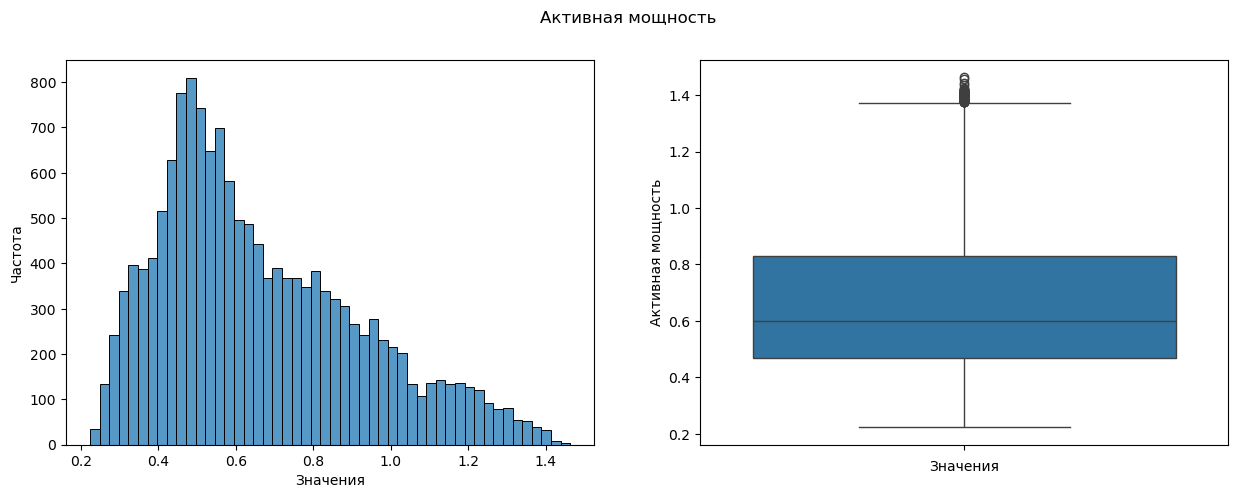

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

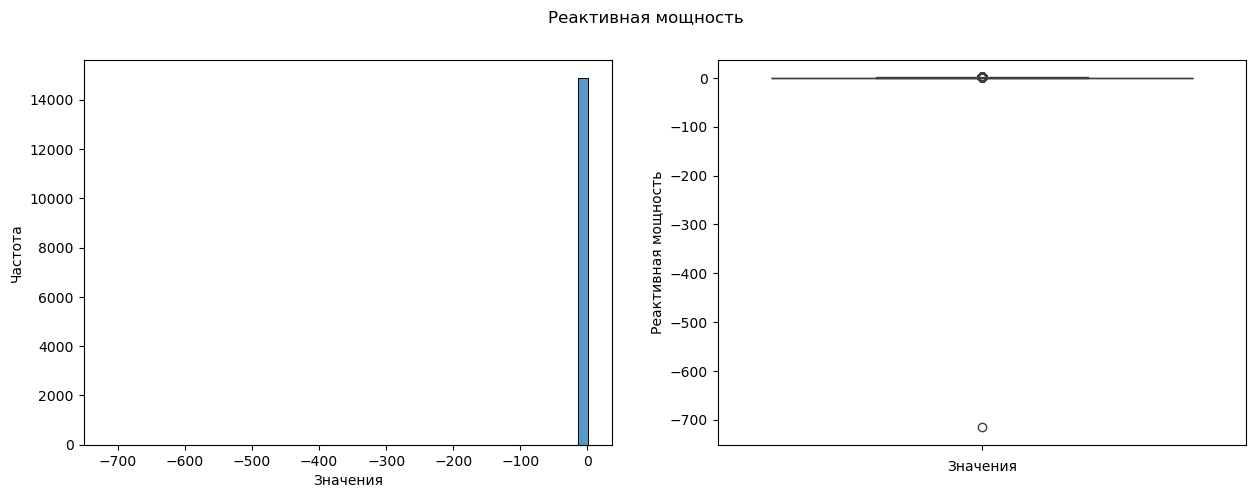

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

**********************************************************************
Количество нулевых значений в числовых столбцах
Активная мощность : 0
Реактивная мощность : 0


In [14]:
# оценим датафрейм
data_exam(data_arc_new)

### Данные о подаче сыпучих материалов - объем

Описание структуры датафрейма

- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB
**********************************************************************
Размерность таблицы:
 (3129, 16)
****************************************************

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


**********************************************************************
Пропуски:
          количество          %
key               0   0.000000
Bulk 1         2877  91.946309
Bulk 2         3107  99.296900
Bulk 3         1831  58.517098
Bulk 4         2115  67.593480
Bulk 5         3052  97.539150
Bulk 6         2553  81.591563
Bulk 7         3104  99.201023
Bulk 8         3128  99.968041
Bulk 9         3110  99.392777
Bulk 10        2953  94.375200
Bulk 11        2952  94.343241
Bulk 12         679  21.700224
Bulk 13        3111  99.424736
Bulk 14         323  10.322787
Bulk 15         881  28.155960
**********************************************************************
Названия столбцов:
 ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
**********************************************************************
Количество явных дубликатов:
 0
*********************************

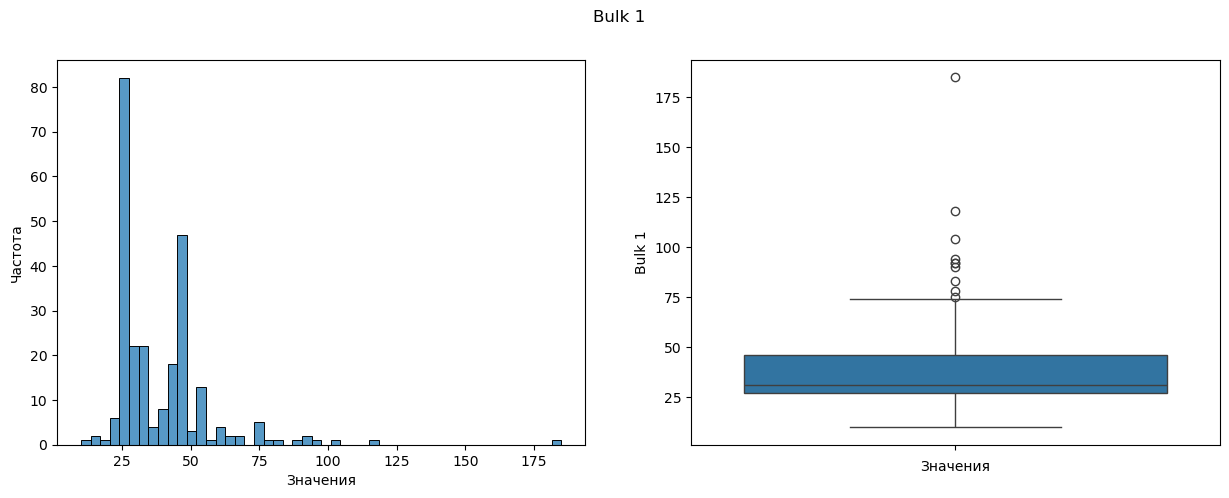

count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64

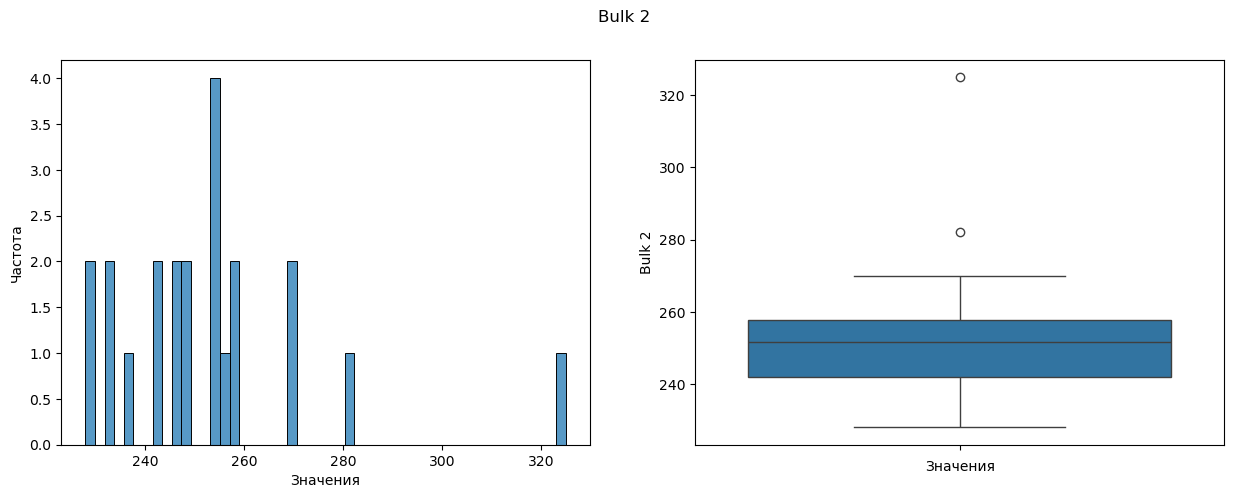

count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64

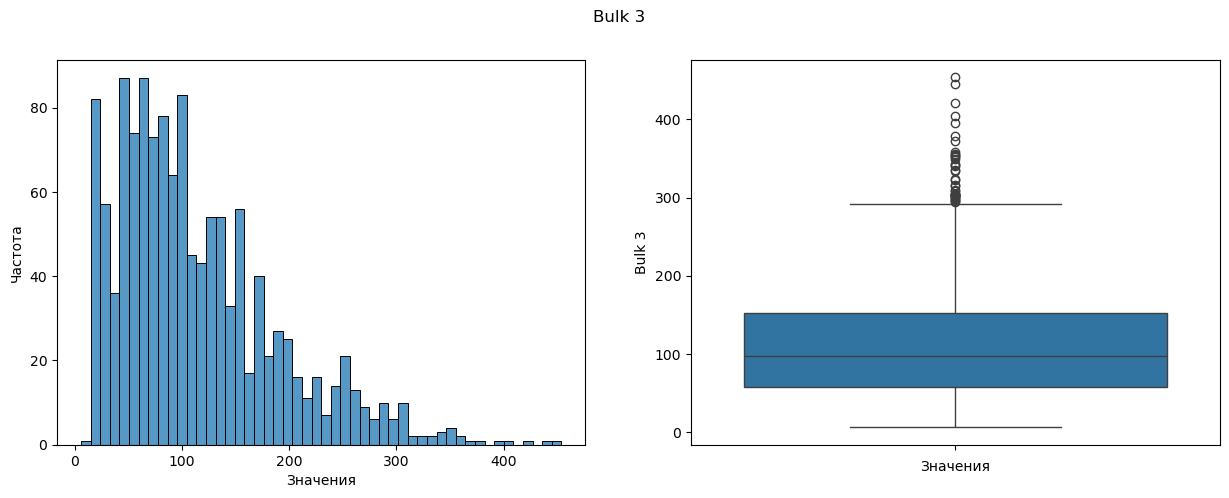

count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64

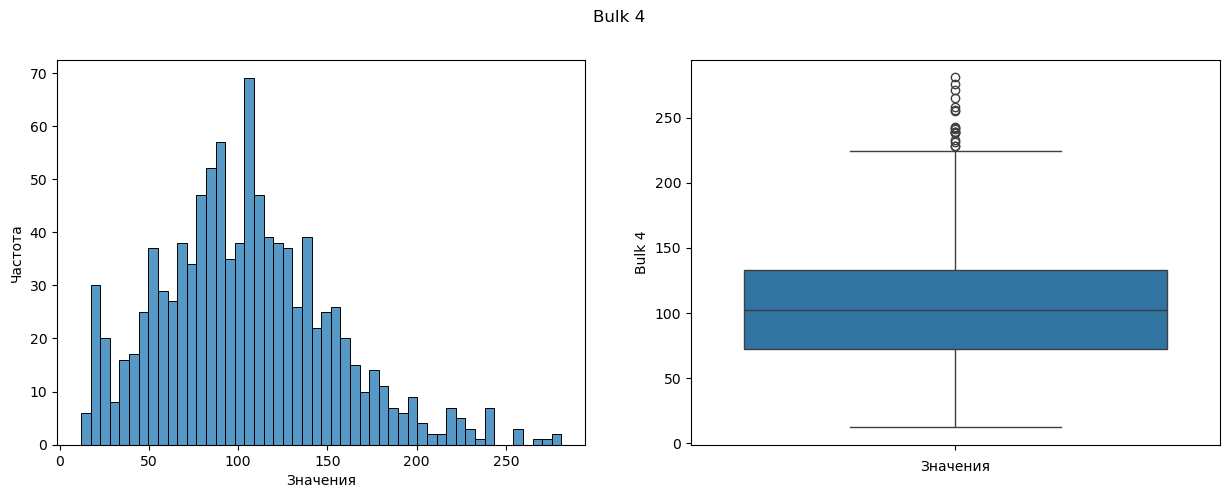

count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64

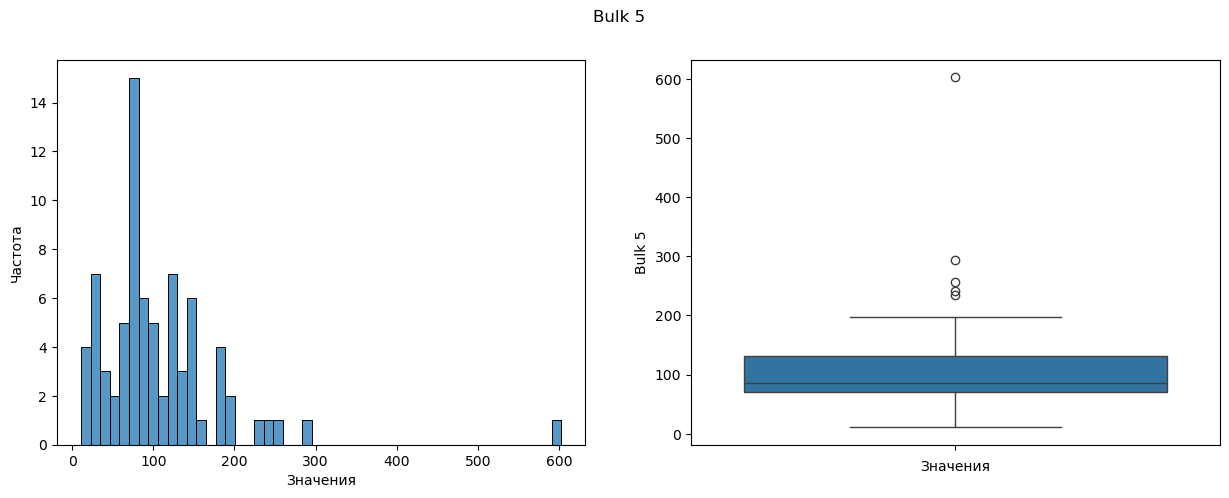

count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64

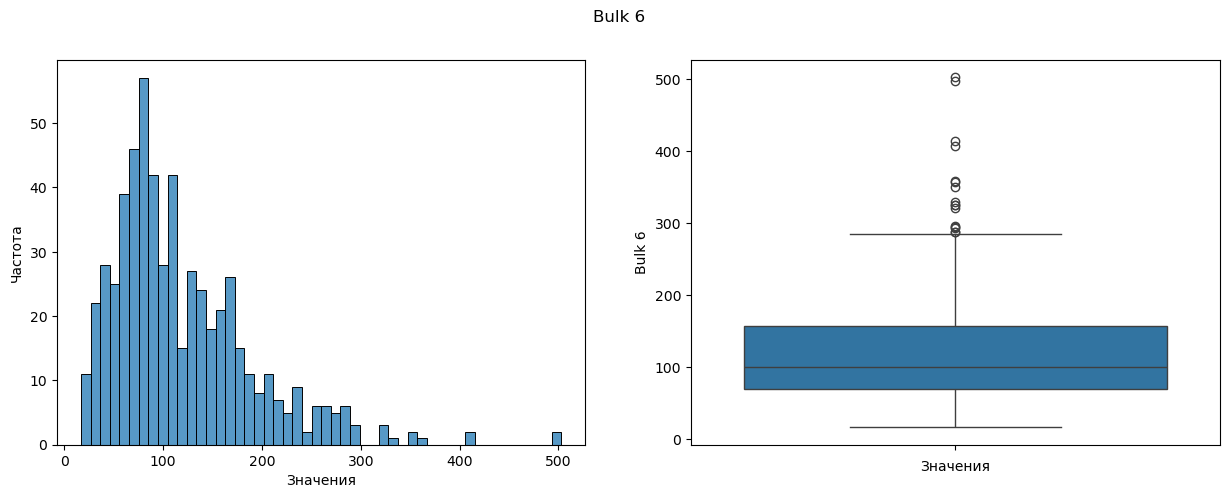

count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64

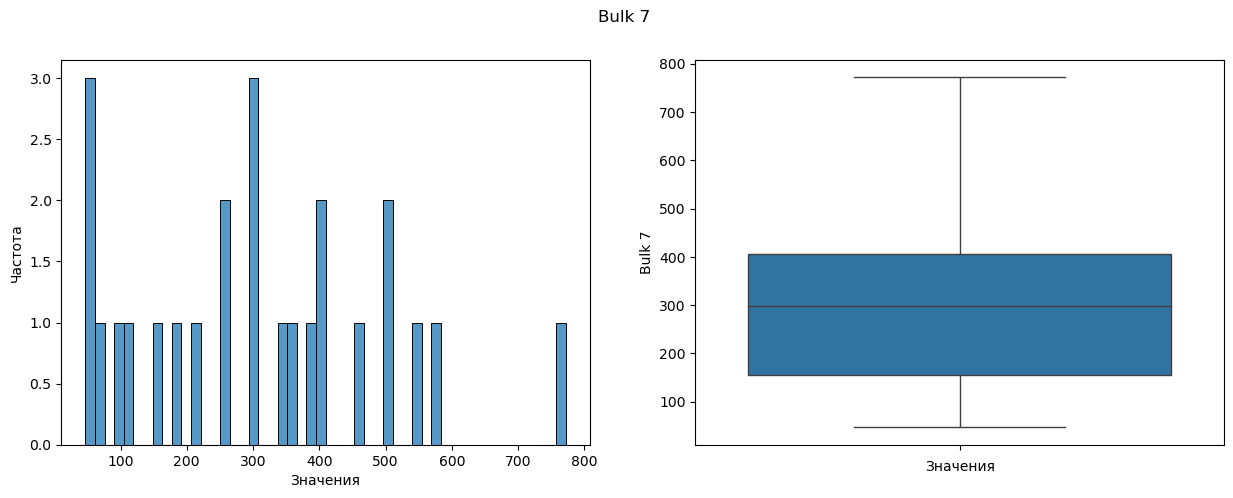

count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64

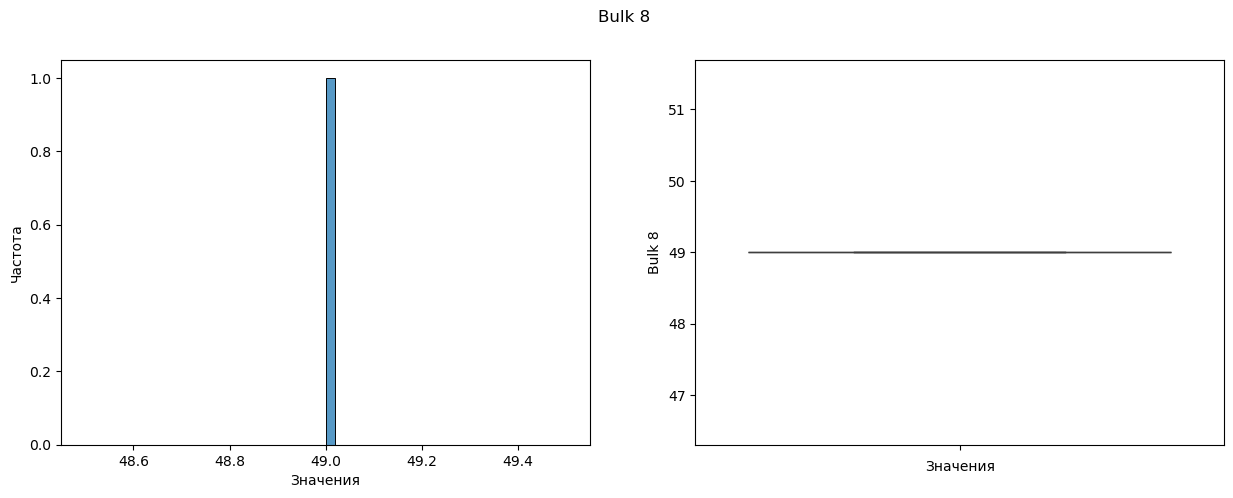

count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64

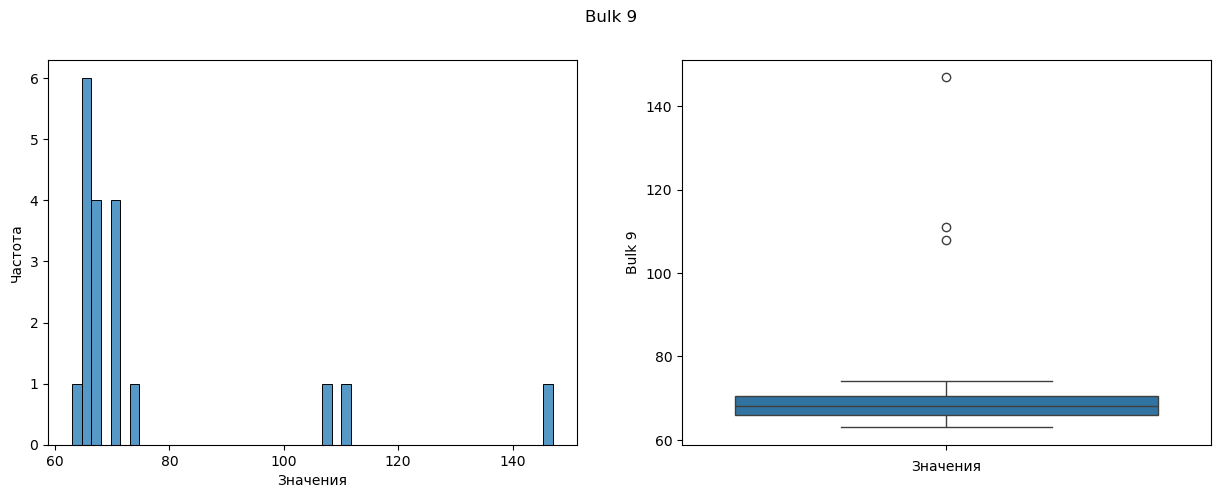

count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64

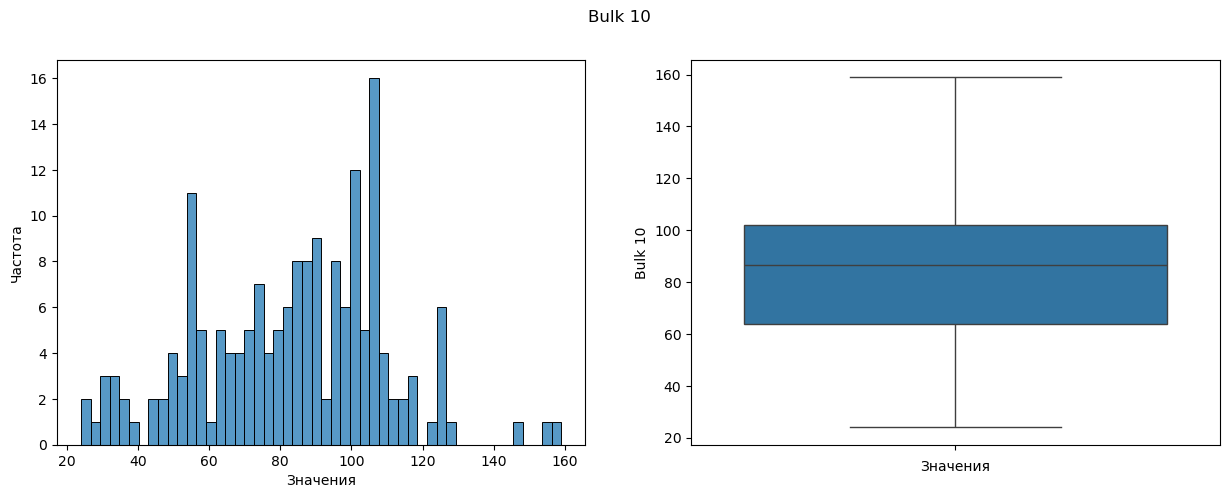

count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64

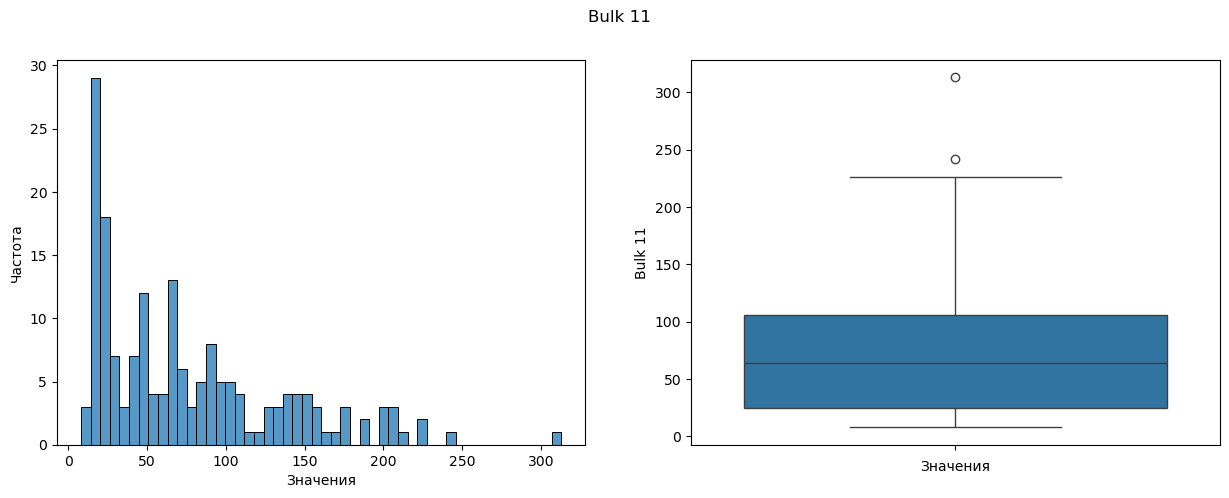

count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64

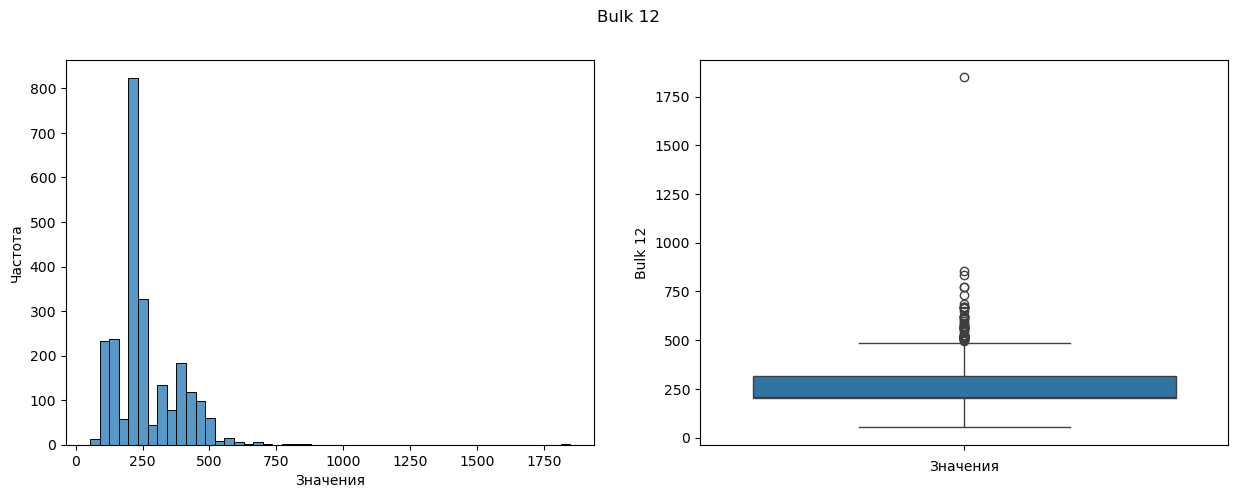

count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64

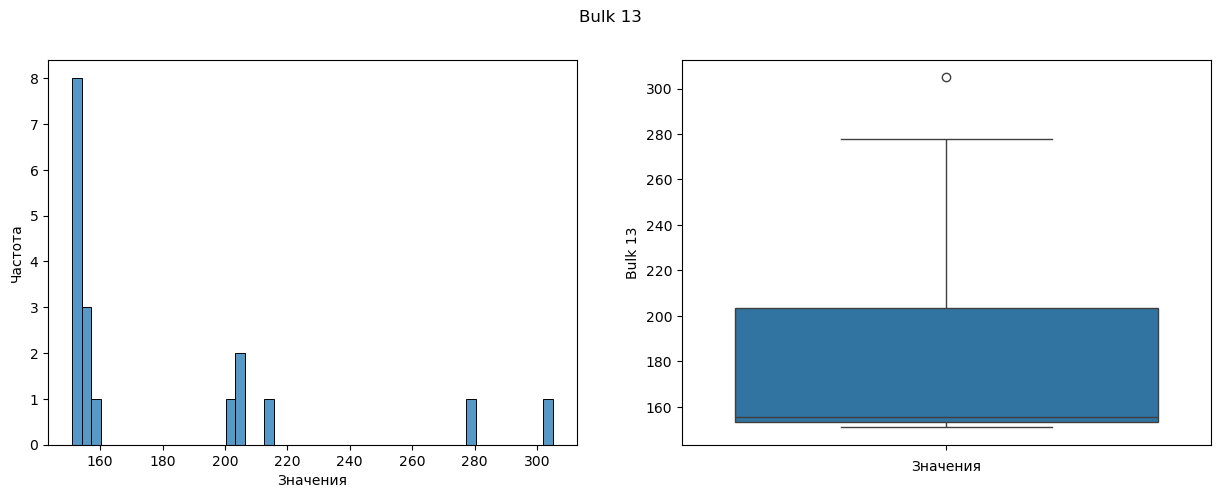

count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64

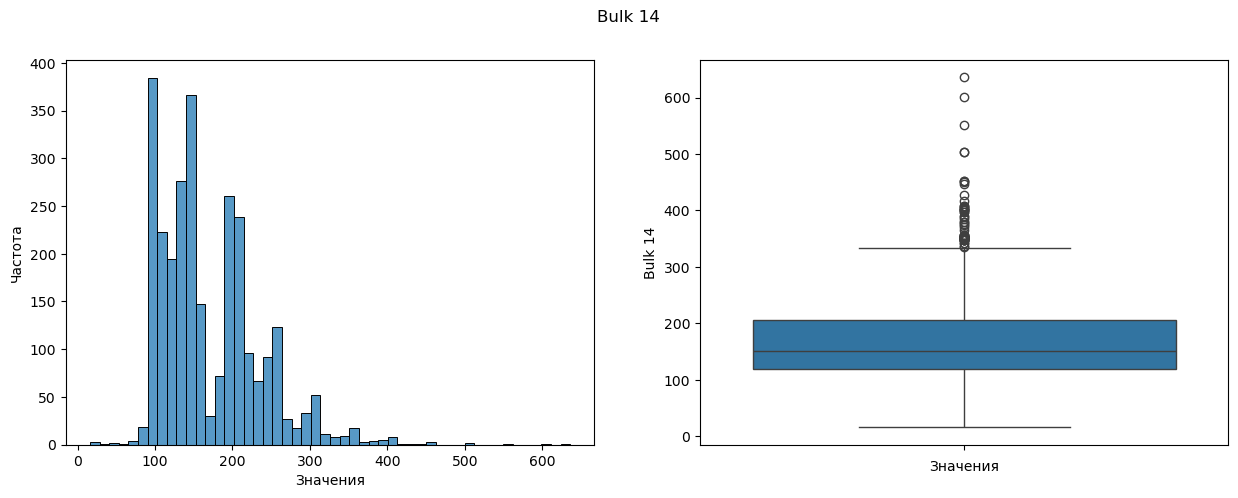

count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64

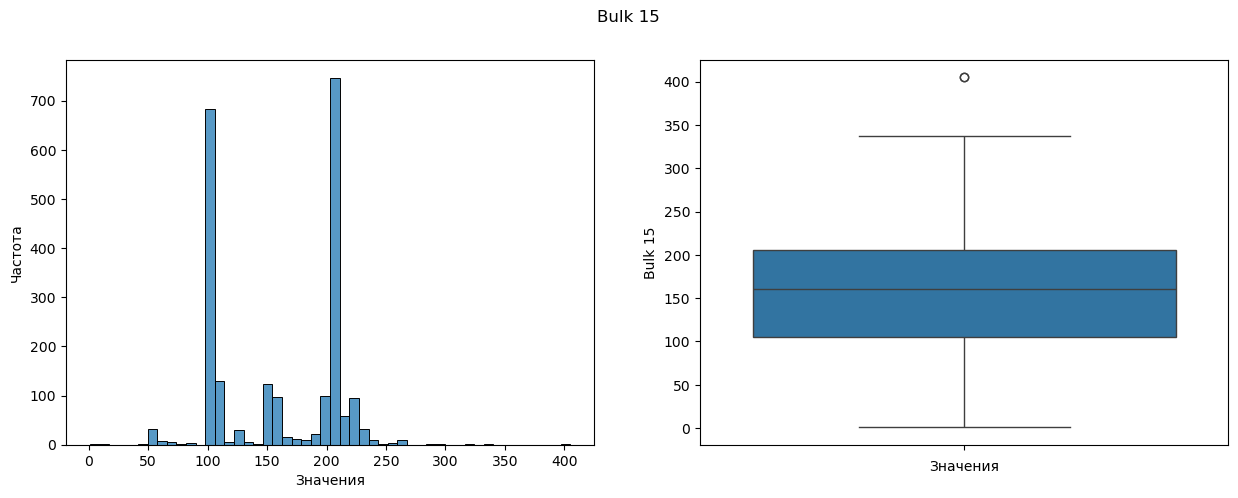

count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64

**********************************************************************
Количество нулевых значений в числовых столбцах
Bulk 1 : 0
Bulk 2 : 0
Bulk 3 : 0
Bulk 4 : 0
Bulk 5 : 0
Bulk 6 : 0
Bulk 7 : 0
Bulk 8 : 0
Bulk 9 : 0
Bulk 10 : 0
Bulk 11 : 0
Bulk 12 : 0
Bulk 13 : 0
Bulk 14 : 0
Bulk 15 : 0


In [15]:
# оценим датафрейм
data_exam(data_bulk_new)

### Данные о подаче сыпучих материалов - время

Описание структуры датафрейма

- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

In [16]:
#оценим датафрейм
data_exam(data_bulk_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB
***********************

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


**********************************************************************
Пропуски:
          количество          %
key               0   0.000000
Bulk 1         2877  91.946309
Bulk 2         3107  99.296900
Bulk 3         1831  58.517098
Bulk 4         2115  67.593480
Bulk 5         3052  97.539150
Bulk 6         2553  81.591563
Bulk 7         3104  99.201023
Bulk 8         3128  99.968041
Bulk 9         3110  99.392777
Bulk 10        2953  94.375200
Bulk 11        2952  94.343241
Bulk 12         679  21.700224
Bulk 13        3111  99.424736
Bulk 14         323  10.322787
Bulk 15         881  28.155960
**********************************************************************
Названия столбцов:
 ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
**********************************************************************
Количество явных дубликатов:
 0
*********************************

### Данные о проволочных материалах - объем

Описание структуры датафрейма

- key — номер партии;
- Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
**********************************************************************
Размерность таблицы:
 (3081, 10)
**********************************************************************


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**********************************************************************
Пропуски:
         количество          %
key              0   0.000000
Wire 1          26   0.843882
Wire 2        2002  64.978903
Wire 3        3018  97.955209
Wire 4        3067  99.545602
Wire 5        3080  99.967543
Wire 6        3008  97.630639
Wire 7        3070  99.642973
Wire 8        3062  99.383317
Wire 9        3052  99.058747
**********************************************************************
Названия столбцов:
 ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
**********************************************************************
Количество явных дубликатов:
 0
**********************************************************************
Уникальные значения:

Столбец key: [   1    2    3 ... 3239 3240 3241] 

**********************************************************************
Числовые столбцы


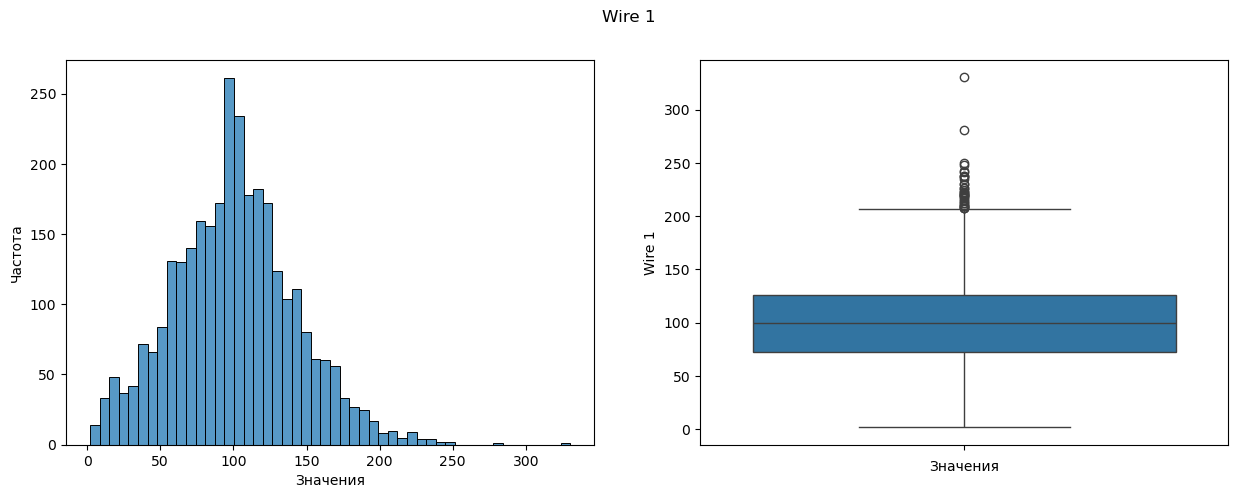

count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64

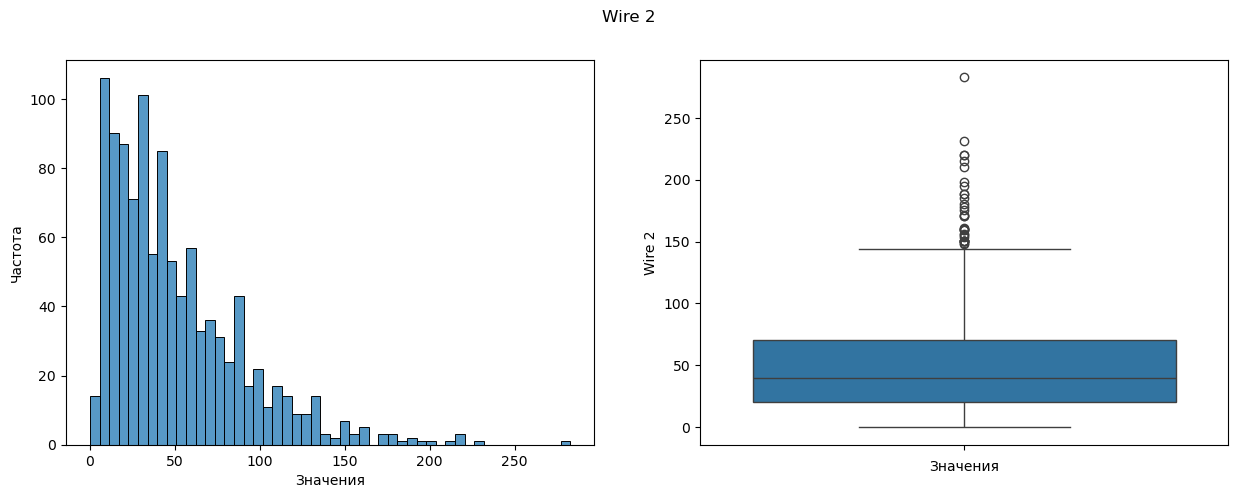

count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64

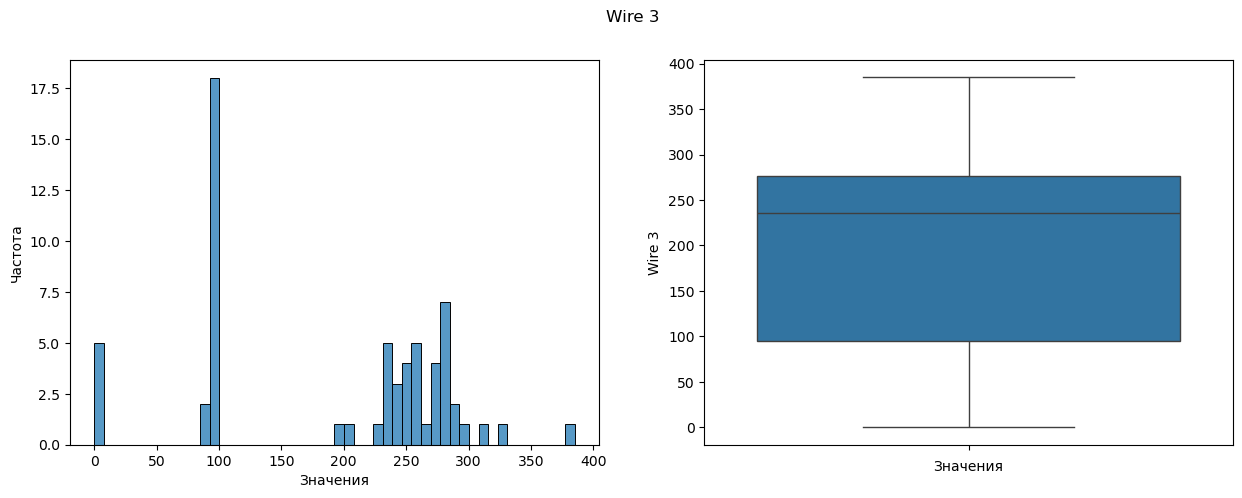

count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64

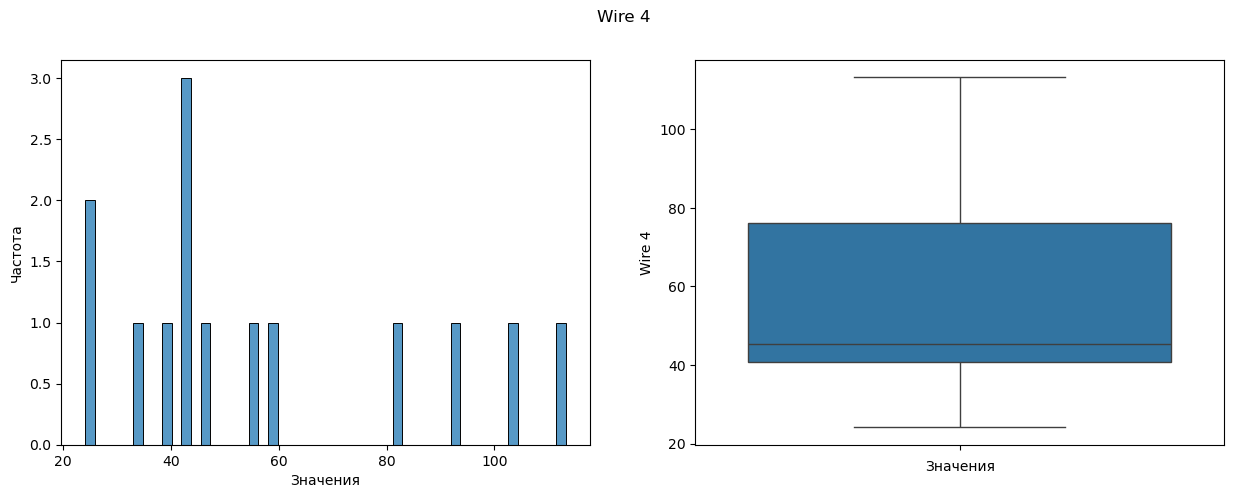

count     14.000000
mean      57.442841
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64

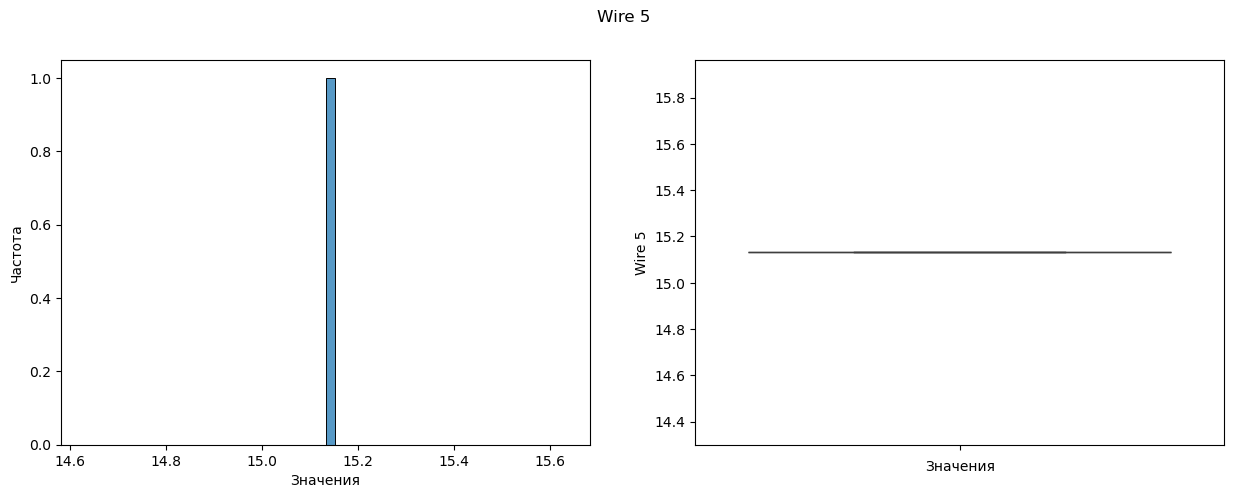

count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64

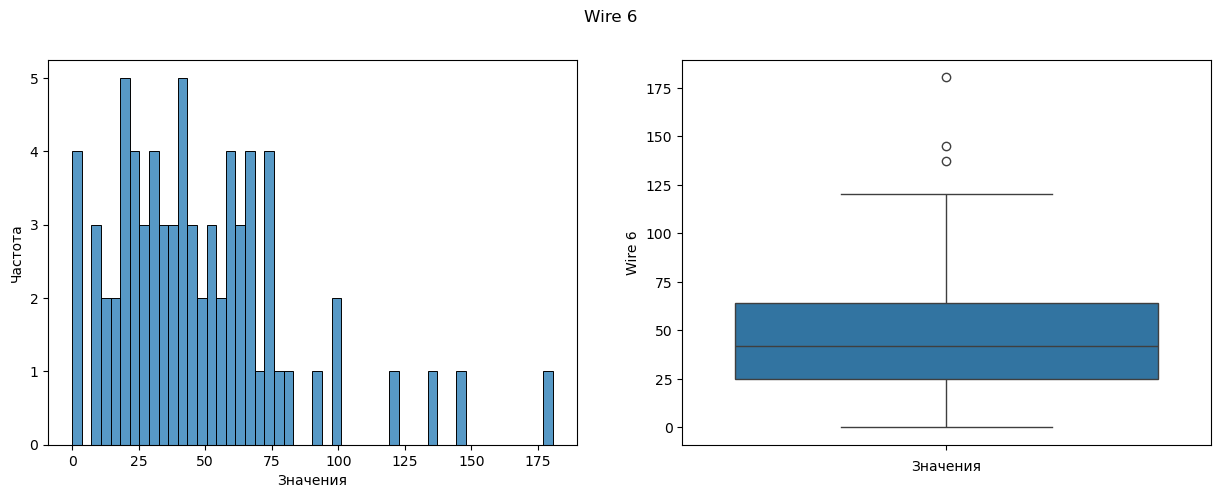

count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64

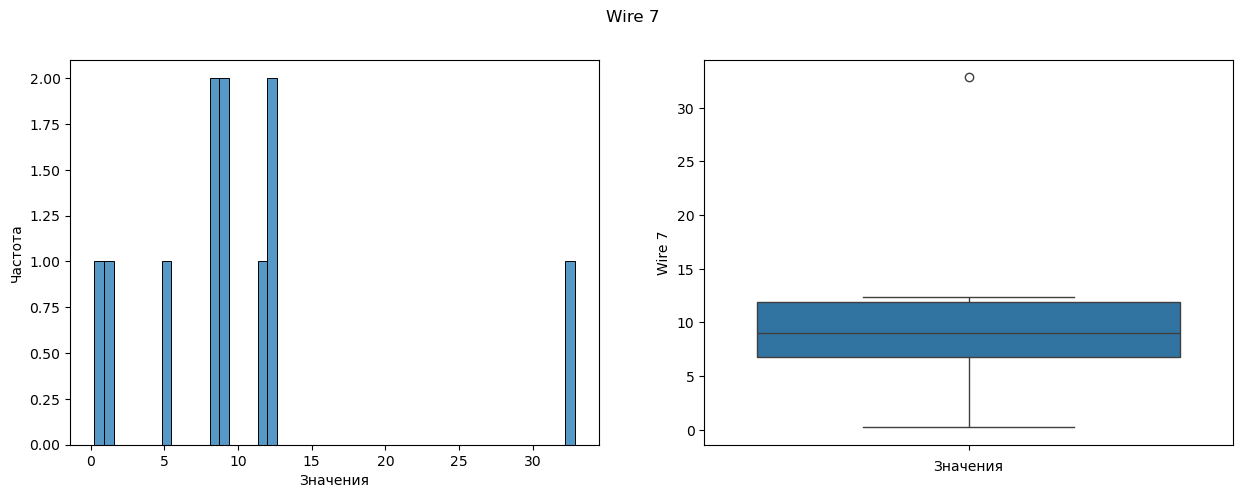

count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64

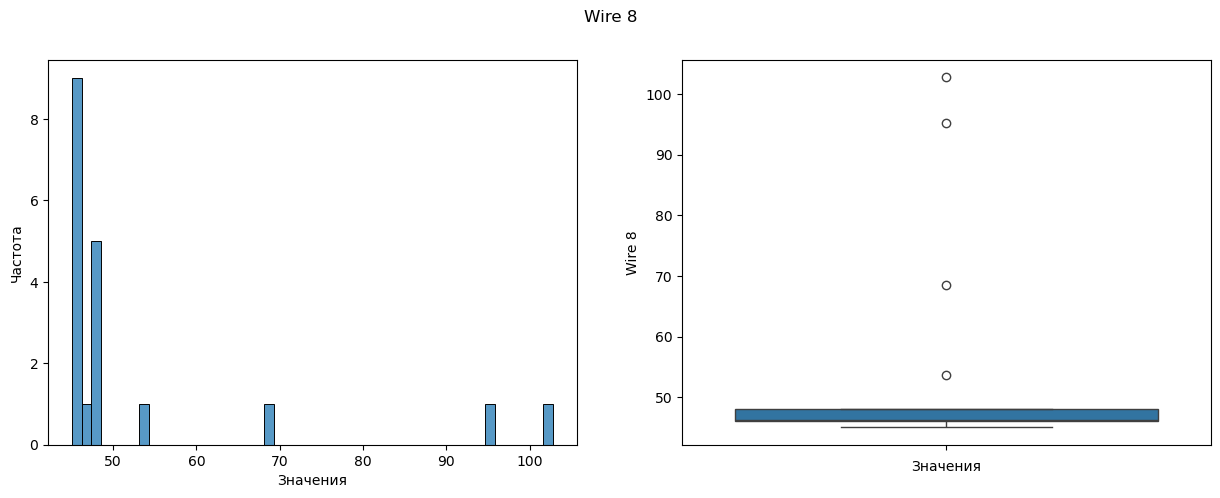

count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64

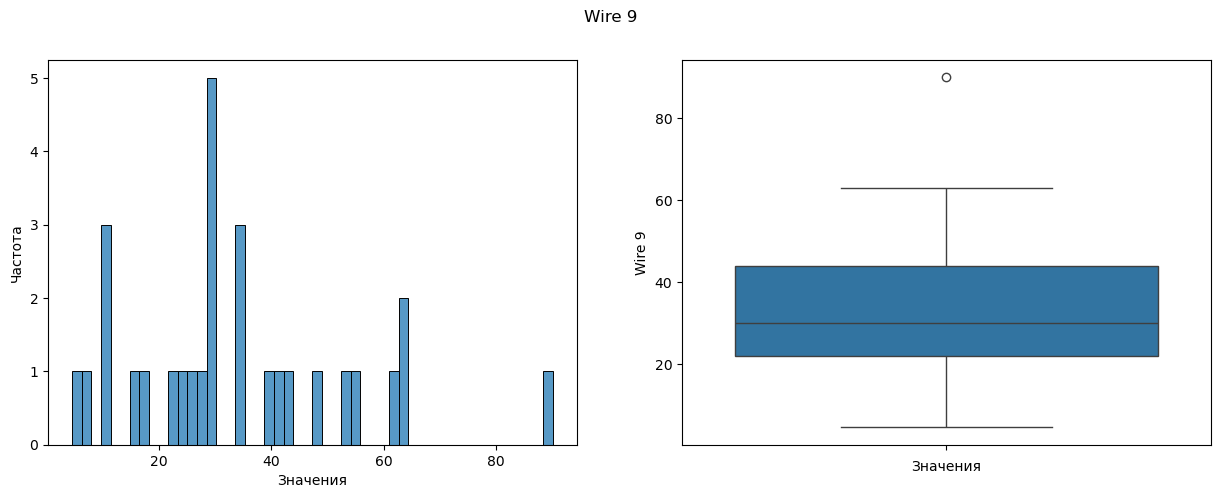

count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64

**********************************************************************
Количество нулевых значений в числовых столбцах
Wire 1 : 0
Wire 2 : 0
Wire 3 : 0
Wire 4 : 0
Wire 5 : 0
Wire 6 : 0
Wire 7 : 0
Wire 8 : 0
Wire 9 : 0


In [17]:
# оценим датафрейм
data_exam(data_wire_new)

### Данные о проволочных материалах - время

Описание структуры датафрейма

- key — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов.

In [18]:
# оценим датафрейм
data_exam(data_wire_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
**********************************************************************
Размерность таблицы:
 (3081, 10)
**********************************************************************


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


**********************************************************************
Пропуски:
         количество          %
key              0   0.000000
Wire 1          26   0.843882
Wire 2        2002  64.978903
Wire 3        3018  97.955209
Wire 4        3067  99.545602
Wire 5        3080  99.967543
Wire 6        3008  97.630639
Wire 7        3070  99.642973
Wire 8        3062  99.383317
Wire 9        3052  99.058747
**********************************************************************
Названия столбцов:
 ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
**********************************************************************
Количество явных дубликатов:
 0
**********************************************************************
Уникальные значения:

Столбец key: [   1    2    3 ... 3239 3240 3241] 

**********************************************************************


### Данные о продувке сплава газом

Описание структуры датафрейма

- key — номер партии;
- Газ 1 — объём подаваемого газа.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
**********************************************************************
Размерность таблицы:
 (3239, 2)
**********************************************************************


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


**********************************************************************
Пропуски:
        количество    %
key             0  0.0
Газ 1           0  0.0
**********************************************************************
Названия столбцов:
 ['key', 'Газ 1']
**********************************************************************
Количество явных дубликатов:
 0
**********************************************************************
Уникальные значения:

Столбец key: [   1    2    3 ... 3239 3240 3241] 

**********************************************************************
Числовые столбцы


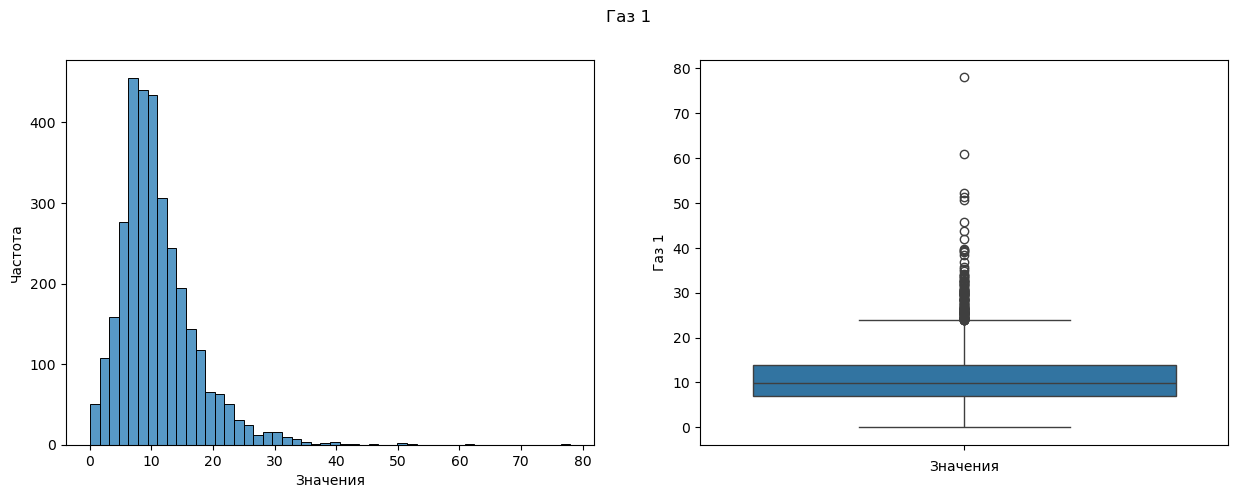

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

**********************************************************************
Количество нулевых значений в числовых столбцах
Газ 1 : 0


In [19]:
# оценим датафрейм
data_exam(data_gas_new)

### Данные о результатах измерения температуры

Описание структуры датафрейма

- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
**********************************************************************
Размерность таблицы:
 (18092, 3)
**********************************************************************


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


**********************************************************************
Пропуски:
               количество          %
key                    0   0.000000
Время замера           0   0.000000
Температура         3427  18.942074
**********************************************************************
Названия столбцов:
 ['key', 'Время замера', 'Температура']
**********************************************************************
Количество явных дубликатов:
 0
**********************************************************************
Уникальные значения:

Столбец key: [   1    2    3 ... 3239 3240 3241] 

**********************************************************************
Числовые столбцы


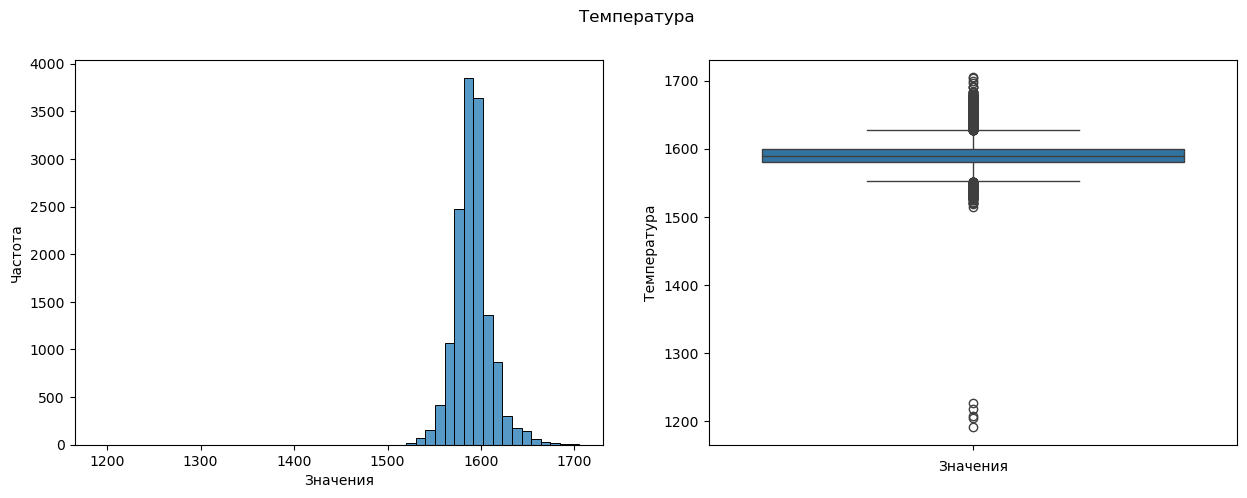

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

**********************************************************************
Количество нулевых значений в числовых столбцах
Температура : 0


In [20]:
# оценим датафрейм
data_exam(data_temp_new)

### Общий вывод по исследовательскому анализу данных

**Таким образом изучив предоставленные данные можно сделать следующие выводы:**

**1. Данные по электродам**
- размерность датасета 14876 строк и 5 стобцов;
- названия столбцов необходимо привести к змеиному стилю;
- пропуски в данных отстуствуют;
- явные дубликаты отстуствуют;
- типы данных корректны, даты приведены к нужному формату;
- распределение данных по параметру активной энергии близко к нормальному, с выраженным смещением влево, так же присуствуют статистические выбросы в области бОльших значений;
- распределние реактивной энергии точно не определено из-за присуствующего большого отрицательного выброса значений, в дальнейшем проработаем данный момент;
- в числовых столбцах отстуствуют явные нулевые значения;
- в данном датафрейме номер партии может быть описан несколькими строками - при обработке понадобится агрегирование.
---------------------------------------------------------------------------

**2. Данные о подаче сыпучих материалов - объем**

- размерность датасета 3129 строк и 16 стобцов;
- названия столбцов необходимо привести к змеиному стилю;
- в данных присуствует большое количество пропусков, для некоторых сыпучих материалов - доля пропусков более 99 %, так например для добавки Bulk 8 присутствует всего одно значение;
- в столбце с номером партии пропуски отстуствуют;
- явные дубликаты отстуствуют;
- типы данных корректны;
- из всех данных по объему сыпучих добавок, к нормальному распределению близки Bulk 4 и Bulk 10, Bulk 3 смещено влево, Bulk 10 смещено вправо, данные по остальным сыпучим добавам не имеют ярко выраженного распределения;
- практически для всех сыпучих материалов наблюдаются статистические выбросы в данных в области бОльших значений;
- в числовых столбцах отстуствуют явные нулевые значения;
- по частоте использования в рецептуре стали добавки можно условно разделить на:
  - редкоиспользуемые: Bulk 1, Bulk 2, Bulk 5, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 22, Bulk 13;
  - среднеиспользуемые: Bulk 3, Bulk 4, Bulk 6;
  - частоиспользуемые: Bulk 12, Bulk 14, Bulk 15.
- по медианному значению объема добавки в рецептуре:
  - малого объема: Bulk 1, Bulk 8, Bulk 9, Bulk 13;
  - среднего объемна: Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 13, Bulk 14, Bulk 15;
  - большого объема: Bulk 2, Bulk 7, Bulk 12.

In [21]:
data_bulk_new[['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8',\
              'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']].describe().round()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.0,22.0,1298.0,1014.0,77.0,576.0,25.0,1.0,19.0,176.0,177.0,2450.0,18.0,2806.0,2248.0
mean,39.0,253.0,114.0,104.0,107.0,119.0,306.0,49.0,76.0,83.0,77.0,260.0,181.0,170.0,161.0
std,18.0,21.0,75.0,48.0,82.0,72.0,191.0,NaN,22.0,26.0,60.0,121.0,46.0,66.0,52.0
min,10.0,228.0,6.0,12.0,11.0,17.0,47.0,49.0,63.0,24.0,8.0,53.0,151.0,16.0,1.0
25%,27.0,242.0,58.0,72.0,70.0,70.0,155.0,49.0,66.0,64.0,25.0,204.0,153.0,119.0,105.0
50%,31.0,252.0,98.0,102.0,86.0,100.0,298.0,49.0,68.0,86.0,64.0,208.0,156.0,151.0,160.0
75%,46.0,258.0,152.0,133.0,132.0,157.0,406.0,49.0,70.0,102.0,106.0,316.0,204.0,206.0,205.0
max,185.0,325.0,454.0,281.0,603.0,503.0,772.0,49.0,147.0,159.0,313.0,1849.0,305.0,636.0,405.0


**3. Данные о подаче сыпучих материалов - время**

- размерность датасета 3129 строк и 16 стобцов;
- названия столбцов необходимо привести к змеиному стилю;
- в данных присуствует большое количество пропусков, для некоторых сыпучих материалов - доля пропусков более 99 %;
- в столбце с номером партии пропуски отстуствуют;
- явные дубликаты отстуствуют;

В целом структура данных аналогична, структуре данных по подаче сыпучих компонент - объем, в том числе и по количеству пропусков. 

--------------------------------------------------------------------------------
**4. Данные о проволочных материалах - объем**

- размерность датасета 3081 строк и 10 стобцов;
- названия столбцовв необходимо привести к змеиному стилю;
- в данных присуствует большое количество пропусков, для некоторых проволочных материалов - доля пропусков более 99 %, так например для добавки Wire 5 присутствует всего одно значение;
- в столбце с номером партии пропуски отстуствуют;
- явные дубликаты отстуствуют;
- типы данных корректны, даты приведены к необходимому формату;
- из всех данных по объему проволчных добавок, к нормальному распределению близко Wire 1 и Wire 6, Wire 2 имеет смещение влево,  данные по остальным проволочным добавам не имеют ярко выраженного распределения;
- практически для всех проволочных материалов наблюдаются статистические выбросы в данных;
- в числовых столбцах отстуствуют нулевые значения;
- по частоте использования в рецептуре стали добавки можно условно разделить на:
  - редкоиспользуемые: Wire 3, Wire 4,	Wire 5,	Wire 6,	Wire 7,	Wire 8,	Wire 9;
  - частоиспользуемые: Wire 1, Wire 2.
- по медианному значению объема добавки в рецептуре:
  - малого объема: Wire 2,	Wire 4,	Wire 5,	Wire 6,	Wire 7,	Wire 8,	Wire 9;
  - большого объема: Wire 1, Wire 3.

In [22]:
data_wire_new[['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']].describe().round()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.0,1079.0,63.0,14.0,1.0,73.0,11.0,19.0,29.0
mean,101.0,51.0,189.0,57.0,15.0,48.0,10.0,54.0,34.0
std,42.0,39.0,100.0,29.0,NaN,34.0,9.0,17.0,20.0
min,2.0,0.0,0.0,24.0,15.0,0.0,0.0,45.0,5.0
25%,72.0,20.0,95.0,41.0,15.0,25.0,7.0,46.0,22.0
50%,100.0,40.0,235.0,45.0,15.0,42.0,9.0,46.0,30.0
75%,126.0,70.0,276.0,76.0,15.0,64.0,12.0,48.0,44.0
max,330.0,283.0,385.0,113.0,15.0,180.0,33.0,103.0,90.0


**5. Данные о проволочных материалах - время**

- размерность датасета 3081 строк и 10 стобцов;
- названия столбцов необходимо привести к змеиному стилю;
- в данных присуствует большое количество пропусков, для некоторых проволочных материалов - доля пропусков более 99 %;
- типы данных корректны, даты были приведены к необходимому типу;
- в столбце с номером партии пропуски отстуствуют;
- явные дубликаты отстуствуют;

В целом структура данных аналогична, структуре данных по подаче проволчных компонент - объем, в том числе и по количеству пропусков.

------------------------------------------------------------------------------
**6. Данные о продувке сплава газом**

- размерность датасета 3239 строк и 2 стобца;
- названия столбцов были приведены к змеиному стилю;
- пропуски в данных отсутствуют;
- явные дубликаты отстуствуют;
- типы данных корректны;
- распределение данных по объему газа близко к нормальному, наблюдается большое количество статистических выбросов в области бОльших значений;
- в числовых столбцах отстуствуют нулевые значения;
- в данном датасете отсутсвуют данные о времени.

------------------------------------------------------------------------------------
**7. Данные о результатах измерения температуры**

- размерность датасета 15907 строк и 3 столбца;
- названия столбцов были приведены к змеиному стилю;
- наблюдаются пропуски в данных по температуре, чуть более 18%;
- явные дубликаты отстуствуют;
- типы данных корректны, даты приведены к необходимому формату;
- распределение данных по температуре близко к нормальному, наблюдается большое количество статистических выбросов, есть выбросы в обе стороны - в том числе несколько сильных выбросов в области значений температуры менее 1300 градусов (что ниже рабочих температур даже для самых легкоплавких сталей);
- в числовых столбцах отстуствуют нулевые значения;
- в данном датафрейме номер партии может быть описан несколькими строками - при обработке понадобится агрегирование.

-----------------------------------------------------------------------------------
**8. Сравнение общего количества партий по датафреймам**

Количество партий в датафрейме data_arc_new :  3214

Количество партий в датафрейме data_bulk_new :  3129

Количество партий в датафрейме data_bulk_time_new :  3129

Количество партий в датафрейме data_gas_new :  3239

Количество партий в датафрейме data_temp_new :  3216

Количество партий в датафрейме data_wire_new :  3081

Количество партий в датафрейме data_wire_time_new :  3081

Видно, что количество партий различается, в различных датафреймах. Больше всего партий описано в датасете **data_gas**. Меньше всего партий в датасетах, описывающих информацию о проволчных материалах (**data_wire** и **data_wire_time**). Часть датафреймов имеют одинаковое количество описанных партий: 
- данные о сыпучих материалах (**data_bulk** и **data_bulk_time**) - по 3129 партий;
- данные о провочных материалы (**data_wire** и **data_wire_time**) - по 3081 партии.

## Предварительная обработка данных

**Общий концепт**



Кроме стандартных процедур (работа с названиями столбцов, обработка отрицательных значений, пропусков и выбросов) необходимо будет провести агрегирование по номеру партии, для датафреймов с информацией по нагреву электродами и замерами температуры. Перед агрегацией, в случае необходимости, нужно будет создать столбцы, создание которых будет невозможно после агрегирования.

На данном этапе будем, будем реализовывать логику последующего объединения всех датафоеймов в один.
Данная логика строится на основе технологического процесса заказчика:
1. 'key' - соотвествует одной партии варки стали.


2. Процесс варки партии стали начинается процедурой измерения стартовой температуры расплава и заканчивается измерением финальной температуры . Все остальные технологические процедуры (иттерации нагрева, введение добавок, продувка газом, отбор проб и определение химического состава), а так же замеры промежуточных температур,  выполняются внутри этого временного интервала.


3. Данные по электродам аггрегируем по партиям, найдем суммарные числовые велечины, оставим время старта первой иттерации и время конца последней иттерации нагрева.


4. На этапе предобработки из двух датафреймов с информацией по сыпучим добавкам сдлеам один, в котором оставим всю информацию по объемам, и присоединим самое ранее и самое позднее время ввода добавок, для каждой партии, чтоб в последующем проверить пункт 2.


5. Для двух датафреймов с информацией по проволочным добавкам сделаем то же самое, что и в пункте 3.


6. Пропуски в данных для обоих видов добавок заменим нулями - в данной рецептуре такие добавки не учавствовали, видимо автоматика заказчика пишет расширенные, унифицированнные логи.


7. Данные по температуре агрегируем по партиям, оставим первую и последнюю измеренные температуры, с временем измерения.

In [23]:
# создадим копии наших первоначальных датасетов
df_arc = data_arc_new.copy()
df_bulk = data_bulk_new.copy()
df_bulk_time = data_bulk_time_new.copy()
df_gas = data_gas_new.copy()
df_temp = data_temp_new.copy()
df_wire = data_wire_new.copy()
df_wire_time = data_wire_time_new.copy()

### Данные по электродам

In [24]:
# приведем название столбцов к змеиному стилю
df_arc.columns = ['key', 'heating_start', 'heating_end', 'active_power', 'reactive_power']

# проверим
df_arc.columns

Index(['key', 'heating_start', 'heating_end', 'active_power',
       'reactive_power'],
      dtype='object')

In [25]:
# посмотрим на значение реактивной мощности меньше 0
df_arc[df_arc['reactive_power'] < 0]

,key,heating_start,heating_end,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Видим, что всего одно значение, в партии под номером 2116. Посмотрим подробнее информацию по этой партии

In [26]:
df_arc[df_arc['key'] == 2116]

,key,heating_start,heating_end,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [27]:
# 4 строки для данной партии, посмотрим общий размер датафрейма
df_arc.shape

(14876, 5)

In [28]:
# удалим данные по этой партии, так как это явное искажение информации
df_arc = df_arc.query('key != 2116')

In [29]:
# проверим размерность после удаления
df_arc.shape

(14872, 5)

In [30]:
# создадим столбец с общим временем нагрева в минутах за одну иттерацию 
df_arc['heating_duration'] = (df_arc['heating_end'] - df_arc['heating_start'])\
                                  .dt.total_seconds()/60
df_arc.head()

,key,heating_start,heating_end,active_power,reactive_power,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,3.800000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,3.083333
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,2.866667
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,6.083333
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,2.466667


In [31]:
# создадим сводную таблицу, сгруппируем по номеру партии, для которого найдем суммарные активную
# и реактивную энергии, время начала первого цикла нагрева и время окончания последнего цикла нагрева.
total_arc =df_arc.pivot_table(values=['active_power','reactive_power', 'heating_start', 'heating_end',\
                                       'heating_duration'],
                               index = 'key',
                               aggfunc={'active_power': sum,
                                        'reactive_power': sum,
                                        'heating_start': min,
                                        'heating_end': max,
                                        'heating_duration': sum})
# переименуем столбцы
total_arc.columns = ['sum_active_power', 'heating_duration', 'total_heating_end', 'total_heating_start',\
                      'sum_reactive_power']
print(total_arc.shape)
total_arc.head()

(3213, 5)


,sum_active_power,heating_duration,total_heating_end,total_heating_start,sum_reactive_power
key,,,,,
1,3.036730,18.300000,2019-05-03 11:28:37,2019-05-03 11:02:14,2.142821
2,2.139408,13.516667,2019-05-03 11:53:18,2019-05-03 11:34:14,1.453357
3,4.063641,10.916667,2019-05-03 12:32:19,2019-05-03 12:06:54,2.937457
4,2.706489,12.350000,2019-05-03 12:57:50,2019-05-03 12:39:37,2.056992
5,2.252950,14.483333,2019-05-03 13:33:55,2019-05-03 13:11:13,1.687991


In [32]:
# посмотрим общую информацию
total_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3213 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   sum_active_power     3213 non-null   float64       
 1   heating_duration     3213 non-null   float64       
 2   total_heating_end    3213 non-null   datetime64[ns]
 3   total_heating_start  3213 non-null   datetime64[ns]
 4   sum_reactive_power   3213 non-null   float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 150.6 KB


Названия столбцов были приведены к змеиному стилю. Была удалена партия с отрицательным значением праметра реактивной энергии, в одной из иттерации нагрева. Получили датафрейм, агрегированный по номеру партии. Номер партии - переведен в индексы, количество строк 3213, пропуски отстутсвуют, столбцы:
- суммарная активная энергия;
- суммарная продолжительность нагрева электродами (суммарное время всех иттераций работы эоектродов, в минутах);
- время окончания последней иттерации нагрева;
- время начала первой иттерации нагрева;
- суммарная реактивная энергия.

### Данные по сыпучим добавкам

In [33]:
# приведем столбцы к змеиному стилю
df_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',\
                   'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

df_bulk_time.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',\
                        'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

display(df_bulk.columns)
df_bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [34]:
# проверим совпадают ли номера партий в датасетов
len(list(set(df_bulk_time['key']) - set(df_bulk['key'])))

0

Отлично, наборы данных идентичны по партиям.

In [35]:
# переведем номер партии в индексы
df_bulk_time = df_bulk_time.set_index('key')
df_bulk = df_bulk.set_index('key')


In [36]:
# проверим
display(df_bulk_time.head())
df_bulk.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [37]:
# создадим таблицу с временем введения первой/последней сыпучей добавки в партии
df_bulk_time_edge = edge_dopant(df_bulk_time, 'min_time_bulk', 'max_time_bulk')
df_bulk_time_edge.head()

,min_time_bulk,max_time_bulk
key,,
1,2019-05-03 11:10:43,2019-05-03 11:28:48
2,2019-05-03 11:36:50,2019-05-03 11:53:30
3,2019-05-03 12:16:16,2019-05-03 12:32:39
4,2019-05-03 12:43:22,2019-05-03 12:58:00
5,2019-05-03 13:30:47,2019-05-03 13:34:12


In [38]:
# присоединим таблицу с временем введения первой/последней сыпучей добавки к датфрейму с информацией по введенным объемам
total_bulk = dopant_concat(df_bulk, df_bulk_time_edge, 'total_bulk')
total_bulk.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,min_time_bulk,max_time_bulk
key,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,2019-05-03 11:10:43,2019-05-03 11:28:48
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,2019-05-03 11:36:50,2019-05-03 11:53:30
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,2019-05-03 12:16:16,2019-05-03 12:32:39
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,2019-05-03 12:43:22,2019-05-03 12:58:00
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,2019-05-03 13:30:47,2019-05-03 13:34:12


In [39]:
# заменим пропуски данных нулями
total_bulk = total_bulk.fillna(0)
total_bulk.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,min_time_bulk,max_time_bulk
key,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,2019-05-03 11:10:43,2019-05-03 11:28:48
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,2019-05-03 11:36:50,2019-05-03 11:53:30
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,2019-05-03 12:16:16,2019-05-03 12:32:39
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,2019-05-03 12:43:22,2019-05-03 12:58:00
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,2019-05-03 13:30:47,2019-05-03 13:34:12


In [40]:
total_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3129 entries, 1 to 3241
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   bulk_1         3129 non-null   float64       
 1   bulk_2         3129 non-null   float64       
 2   bulk_3         3129 non-null   float64       
 3   bulk_4         3129 non-null   float64       
 4   bulk_5         3129 non-null   float64       
 5   bulk_6         3129 non-null   float64       
 6   bulk_7         3129 non-null   float64       
 7   bulk_8         3129 non-null   float64       
 8   bulk_9         3129 non-null   float64       
 9   bulk_10        3129 non-null   float64       
 10  bulk_11        3129 non-null   float64       
 11  bulk_12        3129 non-null   float64       
 12  bulk_13        3129 non-null   float64       
 13  bulk_14        3129 non-null   float64       
 14  bulk_15        3129 non-null   float64       
 15  min_time_bulk  3129 non-nu

Предобработка проводилась с двумя датафреймами информации по сыпучим добавкам - объем и время. Названия столбцов были приведены к змеиному стилю. Установлено, что датафреймы полностью совпадают по номерам партий. Согласно общей концепции предобработки, получен единый датафрейм, номера партий переведены в индексы, пропуски заменены на нулевые значения (добавка не учавствовала в рецептуре стали). Общий размер датафрейма - 3129 строки, 17 столбцов, столбцы:
- bul_1....bulk_15 - данные по объему добавок;
- время введения первой сыпучей добавки в рассматриваемой партии;
- время введения последней сыпучей добавки в рассматриваемой партии.

### Данные по проволочным  добавкам

In [41]:
# приведем столбцы к змеиному стилю
df_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
df_wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

display(df_wire.columns)
df_wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [42]:
# проверим совпадают ли номера партий в датасетов
len(list(set(df_wire_time['key']) - set(df_wire['key'])))

0

Отлично, наборы данных идентичны по партиям.

In [43]:
# переведем номер партии в индексы
df_wire_time = df_wire_time.set_index('key')
df_wire = df_wire.set_index('key')

df_wire_time.index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241],
      dtype='int64', name='key', length=3081)

In [44]:
# проверим
display(df_wire_time.head())
df_wire.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# создадим таблицу с временем введения первой/последней проволочной добавки в партии
df_wire_time_edge = edge_dopant(df_wire_time, 'min_time_wire', 'max_time_wire')
df_wire_time_edge.head()

,min_time_wire,max_time_wire
key,,
1,2019-05-03 11:06:19,2019-05-03 11:06:19
2,2019-05-03 11:36:50,2019-05-03 11:36:50
3,2019-05-03 12:11:46,2019-05-03 12:11:46
4,2019-05-03 12:43:22,2019-05-03 12:43:22
5,2019-05-03 13:15:34,2019-05-03 13:20:44


In [46]:
# присоединим таблицу с временем введения первой/последней проволочной добавки к датфрейму с информацией по введенным объемам
total_wire = dopant_concat(df_wire, df_wire_time_edge, 'total_wire')
total_wire.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,min_time_wire,max_time_wire
key,,,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:06:19,2019-05-03 11:06:19
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:36:50,2019-05-03 11:36:50
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:11:46,2019-05-03 12:11:46
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:43:22,2019-05-03 12:43:22
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:15:34,2019-05-03 13:20:44


In [47]:
# заменим пропуски данных нулями
total_wire = total_wire.fillna(0)
total_wire.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,min_time_wire,max_time_wire
key,,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:06:19,2019-05-03 11:06:19
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:36:50,2019-05-03 11:36:50
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:11:46,2019-05-03 12:11:46
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:43:22,2019-05-03 12:43:22
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:15:34,2019-05-03 13:20:44


In [48]:
total_wire.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3081 entries, 1 to 3241
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wire_1         3081 non-null   float64       
 1   wire_2         3081 non-null   float64       
 2   wire_3         3081 non-null   float64       
 3   wire_4         3081 non-null   float64       
 4   wire_5         3081 non-null   float64       
 5   wire_6         3081 non-null   float64       
 6   wire_7         3081 non-null   float64       
 7   wire_8         3081 non-null   float64       
 8   wire_9         3081 non-null   float64       
 9   min_time_wire  3081 non-null   datetime64[ns]
 10  max_time_wire  3081 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(9)
memory usage: 353.4 KB


Предобработка проводилась с двумя датафреймами информации по проволочным добавкам - объем и время. Названия столбцов были приведены к змеиному стилю. Установлено, что датафреймы полностью совпадают по номерам партий. Согласно общей концепции предобработки, получен единый датафрейм, номера партий переведены в индексы, пропуски заменены на нулевые значения (добавка не учавствовала в рецептуре стали). Общий размер датафрейма - 3081 строки, 11 столбцов, столбцы:
- wire_1....wire_9 - данные по объему добавок;
- время введения первой проволочной добавки в рассматриваемой партии;
- время введения последней проволочной добавки в рассматриваемой партии.

### Данные о продувке газом

In [49]:
# приведем столбцы к змеиному стилю и переведем номер партии в индексы
df_gas.columns = ['key', 'gas']
total_gas = df_gas.set_index('key')
total_gas.head()

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


In [50]:
total_gas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gas     3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


Названия столбцов приведены к змеиному стилю. Номера партий переведены в индексы. Получен датафрейм размерностью 3239 строк, 1 столбуц - информация по объему газа для рассматриваемой партии.

### Данные о результатах измерения температуры

In [51]:
# приведем название столбцов к змеиному стилю
df_temp.columns = ['key', 'time', 'temp']
df_temp.columns

Index(['key', 'time', 'temp'], dtype='object')

In [52]:
# посмотрим на значение температуры меньше 1300
df_temp[df_temp['temp'] < 1300]

,key,time,temp
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [53]:
# посмотрим какое количество строк в датафрейме составляют эти партии
bad_temp_key = df_temp[df_temp['temp']<1300]['key'].tolist()
df_temp.query('key in @bad_temp_key').shape

(27, 3)

In [54]:
# удалим эти строки из датафрейма
df_temp = df_temp.query('key not in @bad_temp_key')
# проверим как прошло удаление
print(df_temp.shape, data_temp_new.shape)

(18065, 3) (18092, 3)


Удаление прошло удачно. Далее проведем аггрегацию по партиям. В агрегированных данных мы оставим для каждой партии: первое измерение температуры и его время, последнее измерение температуры и его время.

In [55]:
# создадим таблицу с первым измерением температуры и его временем
df_temp_min_time = edge_temp(df_temp, 'df_temp_min_time', 'min', ['time_start_temp', 'start_temp'])
df_temp_min_time.head()

,time_start_temp,start_temp
key,,
1,2019-05-03 11:02:04,1571.0
2,2019-05-03 11:34:04,1581.0
3,2019-05-03 12:06:44,1596.0
4,2019-05-03 12:39:27,1601.0
5,2019-05-03 13:11:03,1576.0


In [56]:
# создадим таблицу с последним измерением температуры и его временем
df_temp_max_time = edge_temp(df_temp, 'df_temp_max_time', 'max', ['time_end_temp', 'end_temp'])
df_temp_max_time.head()

,time_end_temp,end_temp
key,,
1,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:36:39,1602.0


In [57]:
# объединим таблицы в общий датафрейм
total_temp = pd.concat([df_temp_max_time, df_temp_min_time], axis=1, join='inner')
total_temp.head()

,time_end_temp,end_temp,time_start_temp,start_temp
key,,,,
1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0
2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0
3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0
4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0
5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0


In [58]:
total_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3211 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_end_temp    3211 non-null   datetime64[ns]
 1   end_temp         2473 non-null   float64       
 2   time_start_temp  3211 non-null   datetime64[ns]
 3   start_temp       3211 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 254.5 KB


Видим, что в целевом признаке конечной температуры присутствуют пропуски значений. Данные пропуски не представляется возможным заполнить, так как это признак, который мы должны будем предсказывать. По согласованию с заказчиком, принимаем решение удалить партии, где остутсвуют данные по последней температуре.

In [59]:
# проводим удаление
total_temp = total_temp[total_temp['end_temp'].notna()]
total_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2473 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_end_temp    2473 non-null   datetime64[ns]
 1   end_temp         2473 non-null   float64       
 2   time_start_temp  2473 non-null   datetime64[ns]
 3   start_temp       2473 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.6 KB


Названия столбцов приведены к змеиному стилю. Удалили строки для 5 партий, так как в данных по замерам температуры для этих партий присутствовали измерения менее 1300 градусов. Такой показатель температуры не соотвествует реальной физической картине, так как реальные температуры плавления сталей более 1400 градусов. Номер партии был перевед в индексы, данные агрегированы по партии, получен датафрейм со следующими столбцами:
- время последнего измерения температуры;
- последняя измеренная температура;
- время первого измерения температуры;
- первая измеренная температура.

В данных по последней измеренной температуре были обнаружены пропуски, так как данный параметр является таргетным (необходимым к пргнозированию), то восстановить его каким-либо методом, не представляется возможным. По согласованию с заказчиком, было принято решение удалить информацию по таким партиям. Итоговый размер датафрейма: 2473 строки, 4 столбца.

## Создание общего датафрейма

В ходе предварительного изучения данных было выявлено, что в датафреймах разнится количество описанных партий варки стали. На первом этапе наша задача, оставить партии для которых есть вся технологическая и рецептурная информация, во всех полученных датасетах. 

С технологической информацией - данные об электродах, продувке газом и измерения температуры - проблем нет, партия либо учтена, либо нет. Поэтому в первую очередь необходимо определиться с рецептурными, тут у нас три варианта:
- использовались только сыпучие материалы;
- использовались только проволочные материалы; 
- использовались оба вида материалов. 

Необходимо учесть все варианты.

In [60]:
# определяем все партии где присутствуют добавки вместе или по отдельности

# определяем партии где использовались только проволочные материалы
list_w = list(set(df_wire.index) - set(df_bulk.index))

# определяем партии где использовались только сыпучие материалы
list_b = list(set(df_bulk.index) - set(df_wire.index))

# определяем партии где использовались сыпучие и проволочные материалы одновременно
list_w_b = list(set(df_bulk.index) & set(df_wire.index))

# определяем партии со всеми вариантами использования добавок
list_wb = list_w + list_b + list_w_b

# посмотрим итоговое количество партий
print('Количество партий только с сыпучими добавками:', len(list_b))
print('Количество партий только с проволочными добавками:', len(list_w))
print('Количество партий только с обоими видами добавок:', len(list_w_b))
print('Итоговое количество партий:', len(list_wb))

Количество партий только с сыпучими добавками: 104
Количество партий только с проволочными добавками: 56
Количество партий только с обоими видами добавок: 3025
Итоговое количество партий: 3185


Действительно, видим, что есть партии где присутствует только один тип добавок. Посмотрим подробнее.

In [61]:
# выведем данные по проволочным добавкам для партий где присутствует информация только по сыпучим добавкам
df_bulk.query('index in @list_w')

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,


Видим, что данные отсутсвуют совсем. Посмотрим для проволочных.

In [62]:
# выведем данные по сыпучим добавкам для партий где присутствует информация только по проволочным добавкам
df_wire.query('index in @list_b')

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,


Ситуация аналогичная. С одной стороны - действительно, возможно, что имеются рецептуры стали где присутсвует только один вид добавок. Но судя по механизму логирования данных у заказчика, можно предположить, что для таких партий информация по отсутствующему виду добавок должна быть заполнена пропусками. По факту же мы видим полное отсутствие данных. По хорошему, необходимо уточнить у заказчика данный вопрос. На текущий момент принимаем концепцию, что данные по таким партиям неполные, поэтому при объединение данных в общий датафрейм не будем учитывать такие партии.

In [63]:
# окончательный список партий в которых есть все руцептуры и остальные технологические данные
list_full_info = list(set(total_arc.index) & set(total_gas.index) &  set(total_temp.index) & set(list_w_b))
len(list_full_info)

2324

In [64]:
# проводим срез данных по отобранным ключам
for data in list_dfs:
    globals()[data] = globals()[data].query('index in @list_full_info')
    print('Количество партий в датафрейме', data+':', globals()[data].shape[0])

Количество партий в датафрейме total_arc: 2324
Количество партий в датафрейме total_bulk: 2324
Количество партий в датафрейме total_gas: 2324
Количество партий в датафрейме total_temp: 2324
Количество партий в датафрейме total_wire: 2324


In [65]:
# объединим данные в единый датафрейм
total_data = pd.concat([total_temp, total_arc, total_bulk, total_wire, total_gas], axis=1, join='inner')
display(total_data.head())
total_data.info()

,time_end_temp,end_temp,time_start_temp,start_temp,sum_active_power,heating_duration,total_heating_end,total_heating_start,sum_reactive_power,bulk_1,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,min_time_wire,max_time_wire,gas
key,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0,3.036730,18.300000,2019-05-03 11:28:37,2019-05-03 11:02:14,2.142821,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:06:19,2019-05-03 11:06:19,29.749986
2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0,2.139408,13.516667,2019-05-03 11:53:18,2019-05-03 11:34:14,1.453357,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:36:50,2019-05-03 11:36:50,12.555561
3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0,4.063641,10.916667,2019-05-03 12:32:19,2019-05-03 12:06:54,2.937457,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:11:46,2019-05-03 12:11:46,28.554793
4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0,2.706489,12.350000,2019-05-03 12:57:50,2019-05-03 12:39:37,2.056992,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:43:22,2019-05-03 12:43:22,18.841219
5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0,2.252950,14.483333,2019-05-03 13:33:55,2019-05-03 13:11:13,1.687991,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:15:34,2019-05-03 13:20:44,5.413692


<class 'pandas.core.frame.DataFrame'>
Index: 2324 entries, 1 to 2499
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time_end_temp        2324 non-null   datetime64[ns]
 1   end_temp             2324 non-null   float64       
 2   time_start_temp      2324 non-null   datetime64[ns]
 3   start_temp           2324 non-null   float64       
 4   sum_active_power     2324 non-null   float64       
 5   heating_duration     2324 non-null   float64       
 6   total_heating_end    2324 non-null   datetime64[ns]
 7   total_heating_start  2324 non-null   datetime64[ns]
 8   sum_reactive_power   2324 non-null   float64       
 9   bulk_1               2324 non-null   float64       
 10  bulk_2               2324 non-null   float64       
 11  bulk_3               2324 non-null   float64       
 12  bulk_4               2324 non-null   float64       
 13  bulk_5               2324 non-null   f

Теперь проверим следующее условие, корректности данных: хронологически время последнего замера температуры должно быть больше всех остальных времен окончания технологических операций, а время первого замера температуры меньше всех остальных времен начала технологических операций. Оставим только те партии где эти условия выполняются.

In [66]:
# срез по условию для конечного измерения температуры
total_data = total_data.query('time_end_temp > total_heating_end\
                              and\
                              time_end_temp > max_time_wire\
                              and\
                              time_end_temp > max_time_bulk')

# срез по условию для начального измерения температуры
total_data = total_data.query('time_start_temp < total_heating_start\
                              and\
                              time_start_temp < min_time_wire\
                              and\
                              time_start_temp < min_time_bulk')

total_data.shape

(2324, 38)

Отлично, со временем все в порядке.

Сгенерируем новые признаки:
- "общее время цикла" для партии, время с замера стартовой температур до времени замера конечной температруы;
- "время технологических операций", время не связанное с процедурой работы электродов (общее время цикла минус время работы электродов).

In [67]:
# создадим столбец общего времени цикла в минутах
total_data['cycle_duration'] = (total_data['time_end_temp'] - total_data['time_start_temp']).dt.total_seconds()/60
# создадим столбец времени технологичеких операций
total_data['non_heating_duration'] = total_data['cycle_duration'] - total_data['heating_duration']
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2324 entries, 1 to 2499
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time_end_temp         2324 non-null   datetime64[ns]
 1   end_temp              2324 non-null   float64       
 2   time_start_temp       2324 non-null   datetime64[ns]
 3   start_temp            2324 non-null   float64       
 4   sum_active_power      2324 non-null   float64       
 5   heating_duration      2324 non-null   float64       
 6   total_heating_end     2324 non-null   datetime64[ns]
 7   total_heating_start   2324 non-null   datetime64[ns]
 8   sum_reactive_power    2324 non-null   float64       
 9   bulk_1                2324 non-null   float64       
 10  bulk_2                2324 non-null   float64       
 11  bulk_3                2324 non-null   float64       
 12  bulk_4                2324 non-null   float64       
 13  bulk_5                2

Посмотрим, сколько процентов нулевых значений в сводном датафрейме.

In [68]:
for column in total_data.columns:
            print('Процент нулевых значений в столбце', column,':',\
                  round(100*(total_data[column]==0).sum()/(total_data.shape[0]),2))

Процент нулевых значений в столбце time_end_temp : 0.0
Процент нулевых значений в столбце end_temp : 0.0
Процент нулевых значений в столбце time_start_temp : 0.0
Процент нулевых значений в столбце start_temp : 0.0
Процент нулевых значений в столбце sum_active_power : 0.0
Процент нулевых значений в столбце heating_duration : 0.0
Процент нулевых значений в столбце total_heating_end : 0.0
Процент нулевых значений в столбце total_heating_start : 0.0
Процент нулевых значений в столбце sum_reactive_power : 0.0
Процент нулевых значений в столбце bulk_1 : 91.44
Процент нулевых значений в столбце bulk_2 : 99.44
Процент нулевых значений в столбце bulk_3 : 58.78
Процент нулевых значений в столбце bulk_4 : 65.1
Процент нулевых значений в столбце bulk_5 : 97.72
Процент нулевых значений в столбце bulk_6 : 81.2
Процент нулевых значений в столбце bulk_7 : 99.44
Процент нулевых значений в столбце bulk_8 : 99.96
Процент нулевых значений в столбце bulk_9 : 99.44
Процент нулевых значений в столбце bulk_10

In [69]:
# удалим столбцы с временем, так как они не будут принимать участие на этапе машинного обучения
# и столбец wire_5, так как в нем 100% нулевых значений
total_data = total_data.drop(['time_end_temp', 'time_start_temp', 'total_heating_end', 'max_time_bulk', 'max_time_wire',\
                              'wire_5', 'total_heating_start', 'min_time_bulk', 'min_time_wire'], axis=1)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2324 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   end_temp              2324 non-null   float64
 1   start_temp            2324 non-null   float64
 2   sum_active_power      2324 non-null   float64
 3   heating_duration      2324 non-null   float64
 4   sum_reactive_power    2324 non-null   float64
 5   bulk_1                2324 non-null   float64
 6   bulk_2                2324 non-null   float64
 7   bulk_3                2324 non-null   float64
 8   bulk_4                2324 non-null   float64
 9   bulk_5                2324 non-null   float64
 10  bulk_6                2324 non-null   float64
 11  bulk_7                2324 non-null   float64
 12  bulk_8                2324 non-null   float64
 13  bulk_9                2324 non-null   float64
 14  bulk_10               2324 non-null   float64
 15  bulk_11               2324

In [70]:
# проверим на дубликаты
total_data.duplicated().sum()

0

По итогу данного этапа работы можно сказать следующее:

- перед объединением данных в общий датафрейм были удалены партии, для которых полностью отстутствует информация по одной из добавок. В последующем необходимо уточнить у заказчика - действительно ли есть рецептуры только с одним видом добавок или есть проблемы с выгрузкой или логированием;

- данные объединены в общий датафрейм, проверены хронологические критерии корркетности: первая операция в партии - измерение начальной температруы, последняя операция в партии - измерение конечной температруы, хронология корректна;

- удалены все вспомогательные столбцы с типом данных datetime, а так же столбец wire_5, так как в нем все значения равны нулю;

- введены новые признаки "общее время цикла варки партии стали" и "время операций не связанных с нагревом";

- явные дубликаты отсутствуют;

- в итоговом датафрейме отстуствуют пропуски, размерность 2324 строки и 31 столбец.

## Исследовательский анализ объединенного датафрейма

Проведем исследовательский анализ объединенного датафрейма. Так как в данных по добавкам большое количество пропусков было заполнено нулями, что может исказить статистическую информацию, для них выведем статистику без учета нулевых значений.

In [71]:
# разделим признаки на содержащие нулевые значения и не содержащие таковые, вывдем информацию по каждому из кластеров
list_nonzero = []
list_have_zero = []
for column in total_data.columns:
    if ((total_data[column]==0).sum())==0:
        list_nonzero.append(column)
    else:
        list_have_zero.append(column)
display(list_nonzero)
list_have_zero

['end_temp',
 'start_temp',
 'sum_active_power',
 'heating_duration',
 'sum_reactive_power',
 'gas',
 'cycle_duration',
 'non_heating_duration']

['bulk_1',
 'bulk_2',
 'bulk_3',
 'bulk_4',
 'bulk_5',
 'bulk_6',
 'bulk_7',
 'bulk_8',
 'bulk_9',
 'bulk_10',
 'bulk_11',
 'bulk_12',
 'bulk_13',
 'bulk_14',
 'bulk_15',
 'wire_1',
 'wire_2',
 'wire_3',
 'wire_4',
 'wire_6',
 'wire_7',
 'wire_8',
 'wire_9']

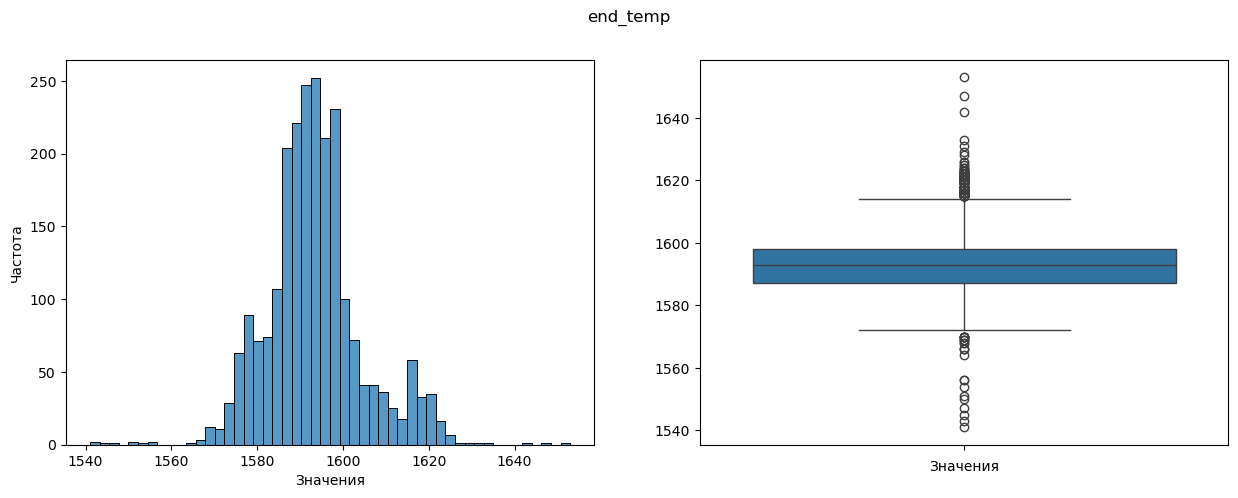

count    2324.000000
mean     1593.372633
std        11.207457
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: end_temp, dtype: float64

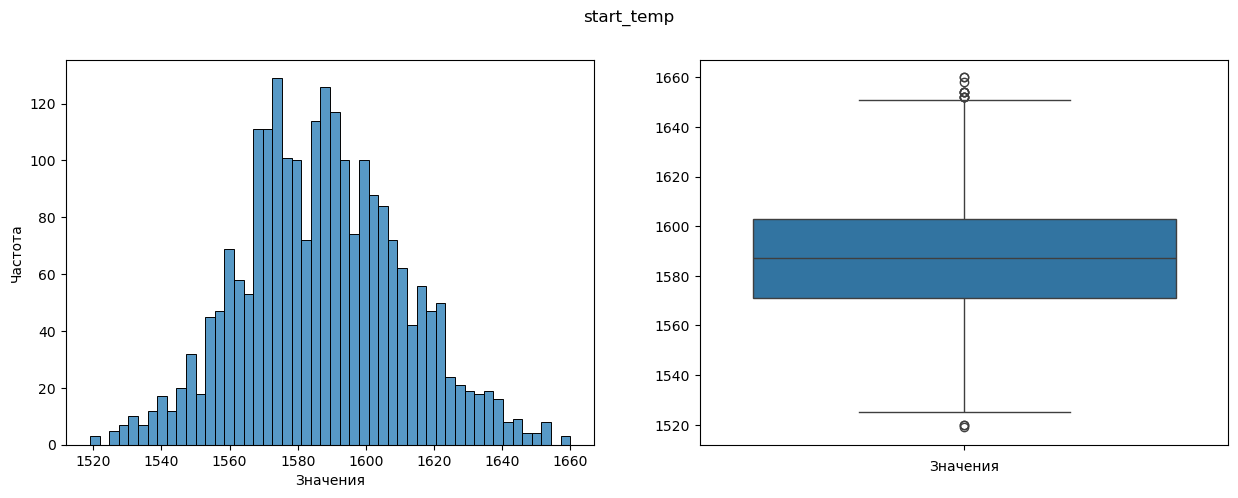

count    2324.000000
mean     1587.368761
std        23.627590
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: start_temp, dtype: float64

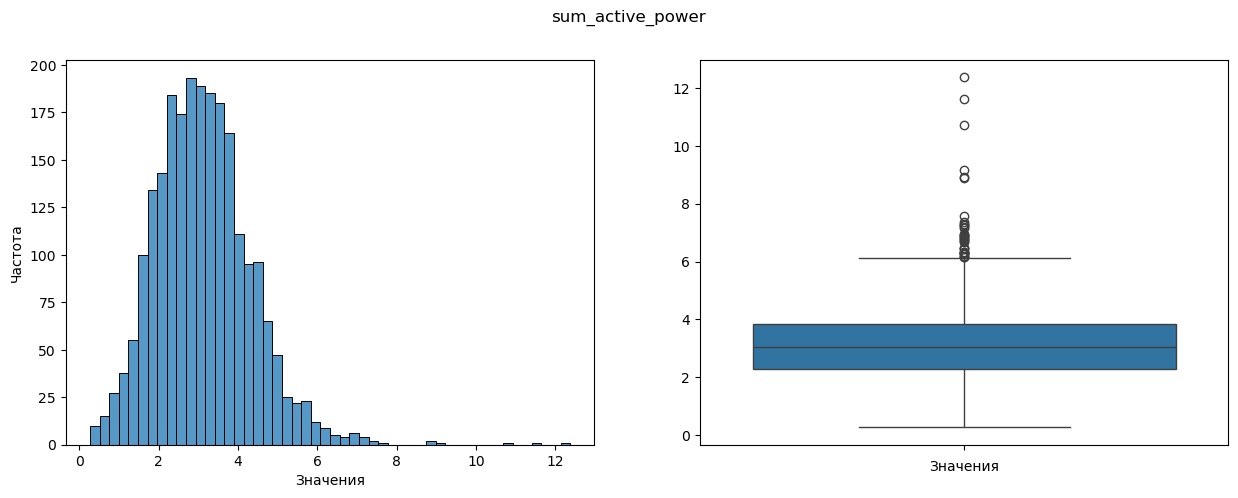

count    2324.000000
mean        3.126327
std         1.220484
min         0.267676
25%         2.295960
50%         3.036517
75%         3.834302
max        12.375636
Name: sum_active_power, dtype: float64

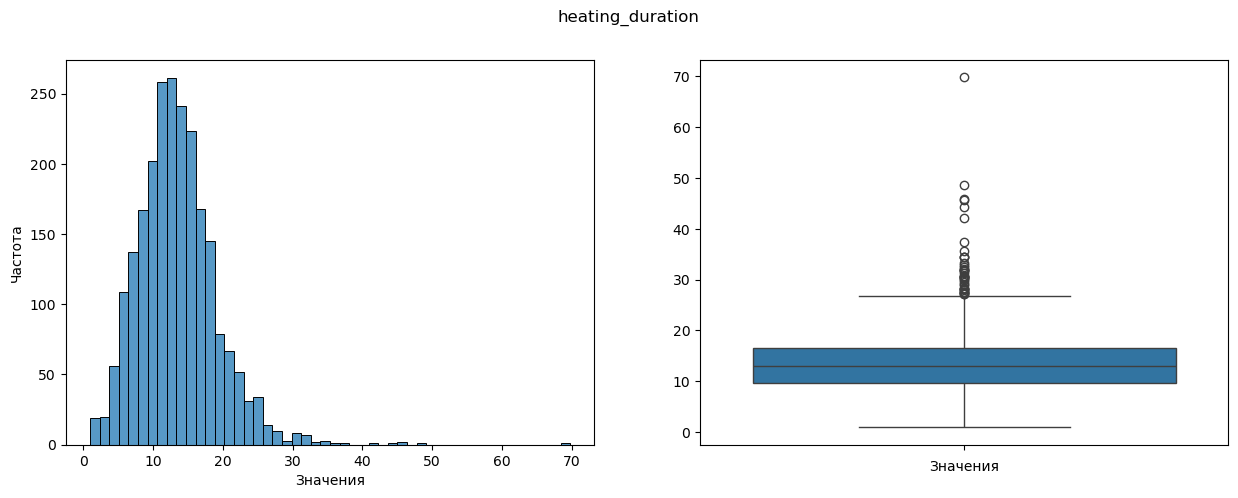

count    2324.000000
mean       13.469944
std         5.680230
min         0.950000
25%         9.683333
50%        12.966667
75%        16.550000
max        69.816667
Name: heating_duration, dtype: float64

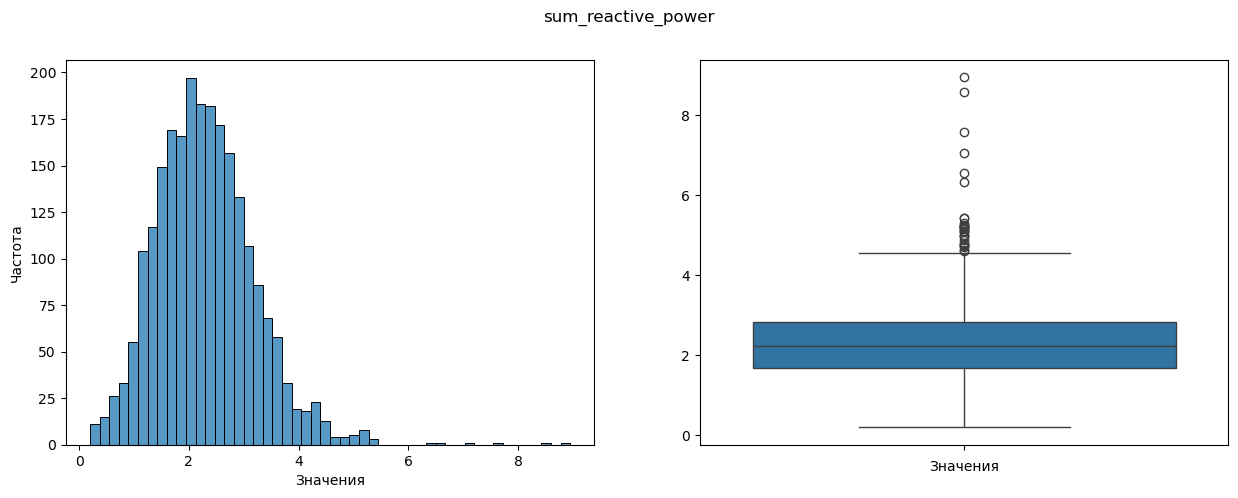

count    2324.000000
mean        2.301280
std         0.903711
min         0.196228
25%         1.671099
50%         2.225900
75%         2.829179
max         8.949049
Name: sum_reactive_power, dtype: float64

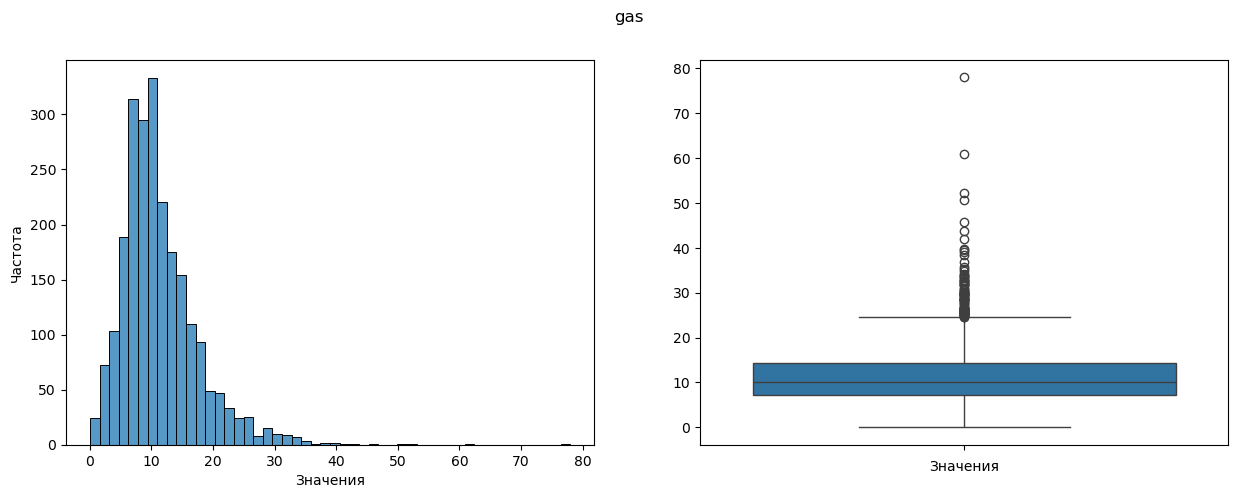

count    2324.000000
mean       11.378854
std         6.397008
min         0.008399
25%         7.282534
50%        10.100687
75%        14.218487
max        77.995040
Name: gas, dtype: float64

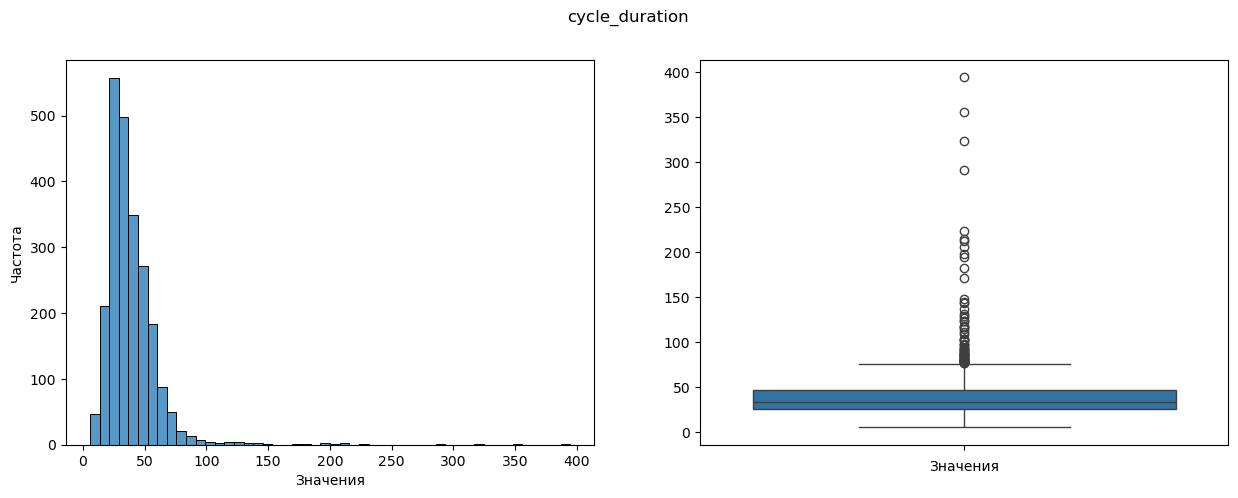

count    2324.000000
mean       38.728034
std        23.096830
min         5.650000
25%        26.341667
50%        34.108333
75%        46.558333
max       394.566667
Name: cycle_duration, dtype: float64

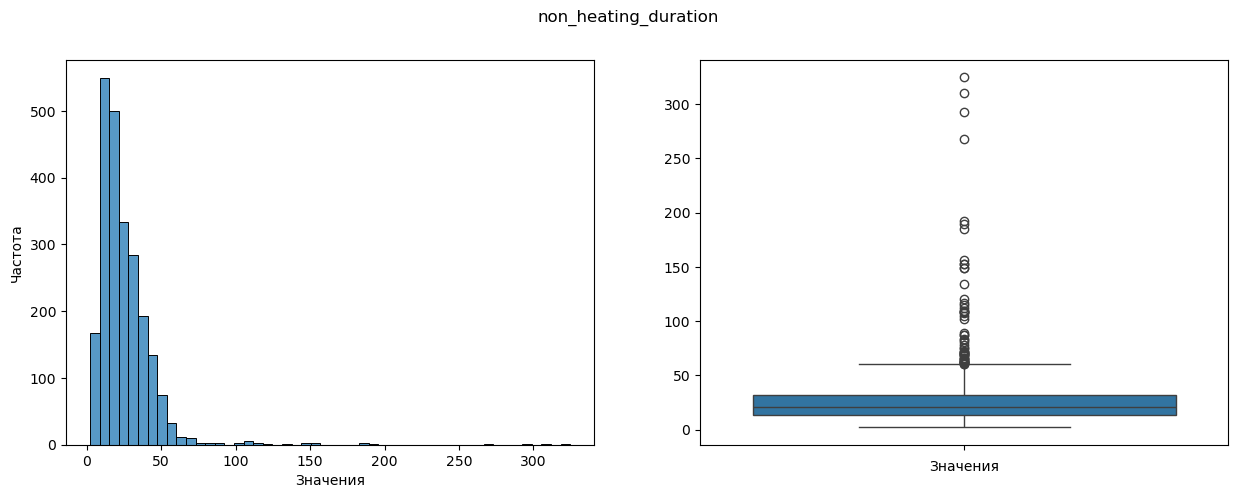

count    2324.000000
mean       25.258090
std        20.448498
min         2.166667
25%        13.450000
50%        20.691667
75%        32.150000
max       324.750000
Name: non_heating_duration, dtype: float64

In [72]:
# исследуем данные без нулей
for column in list_nonzero:
    numeric_plot(total_data[column])

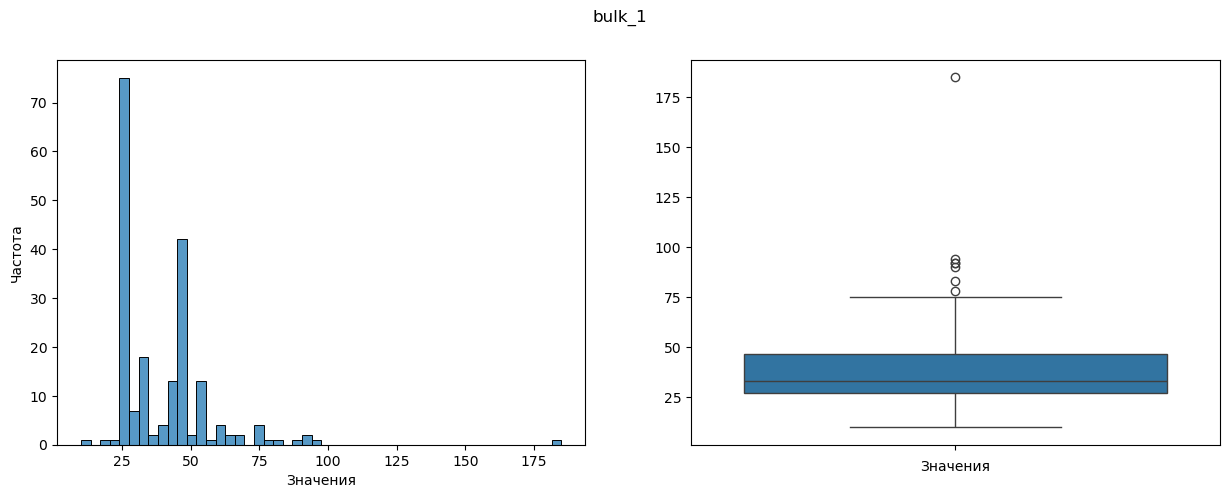

count    199.000000
mean      40.115578
std       18.226180
min       10.000000
25%       27.000000
50%       33.000000
75%       46.500000
max      185.000000
Name: bulk_1, dtype: float64

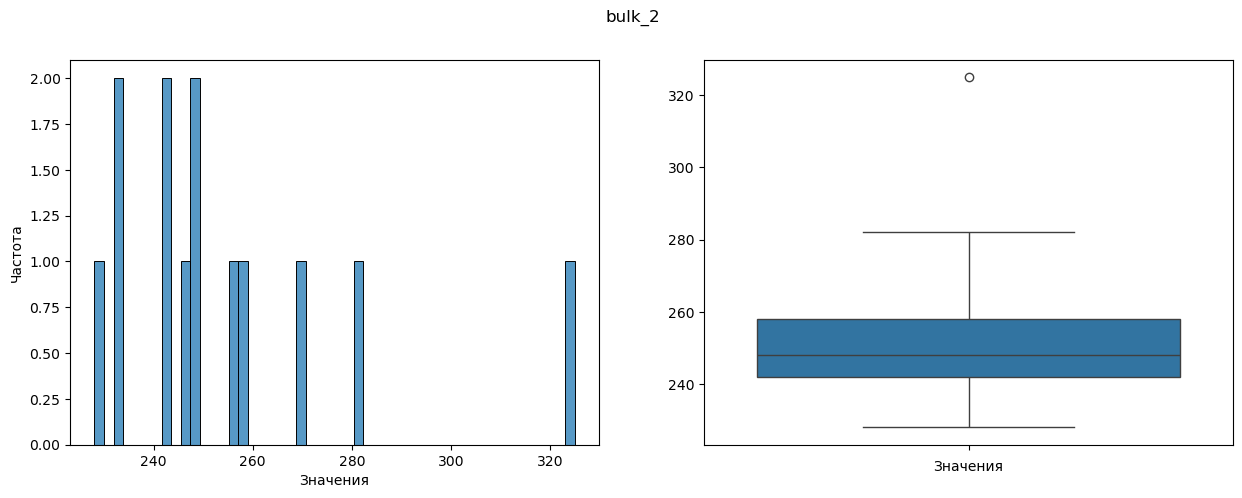

count     13.000000
mean     254.846154
std       25.973853
min      228.000000
25%      242.000000
50%      248.000000
75%      258.000000
max      325.000000
Name: bulk_2, dtype: float64

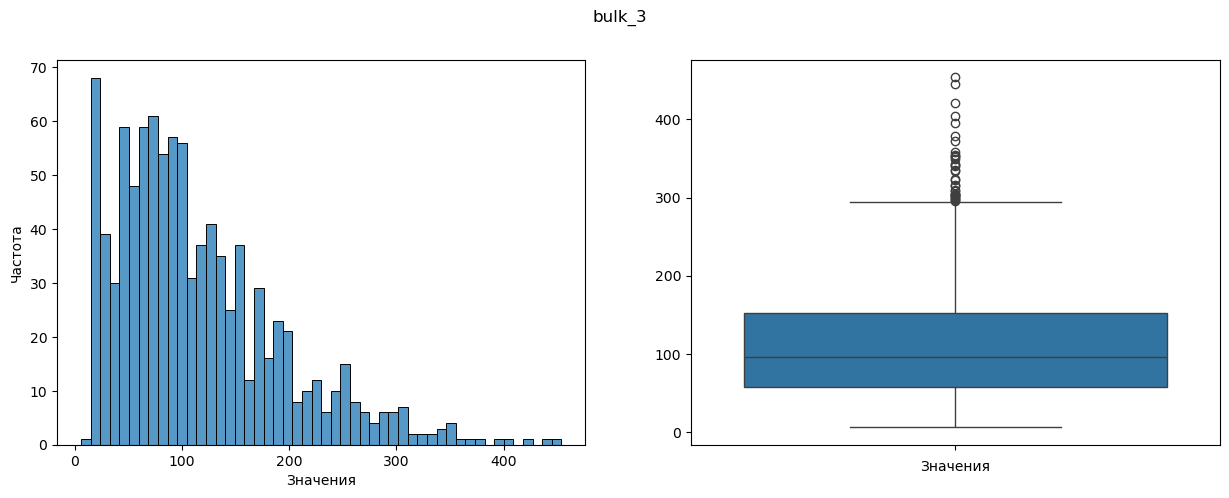

count    958.000000
mean     114.786013
std       77.383675
min        6.000000
25%       57.250000
50%       96.500000
75%      152.000000
max      454.000000
Name: bulk_3, dtype: float64

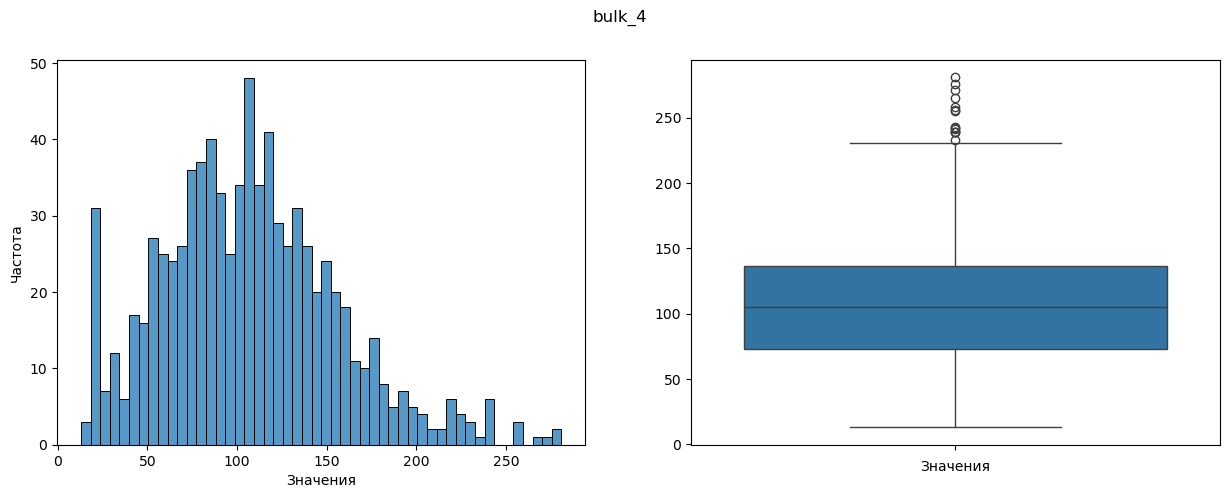

count    811.000000
mean     107.023428
std       49.074553
min       13.000000
25%       73.000000
50%      105.000000
75%      136.500000
max      281.000000
Name: bulk_4, dtype: float64

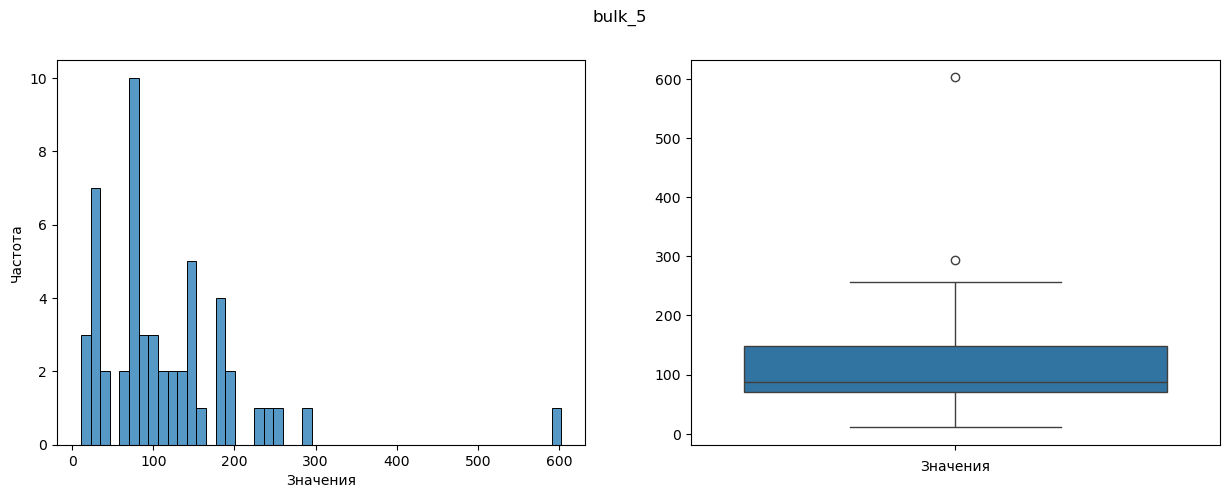

count     53.000000
mean     116.018868
std       95.189182
min       11.000000
25%       70.000000
50%       88.000000
75%      148.000000
max      603.000000
Name: bulk_5, dtype: float64

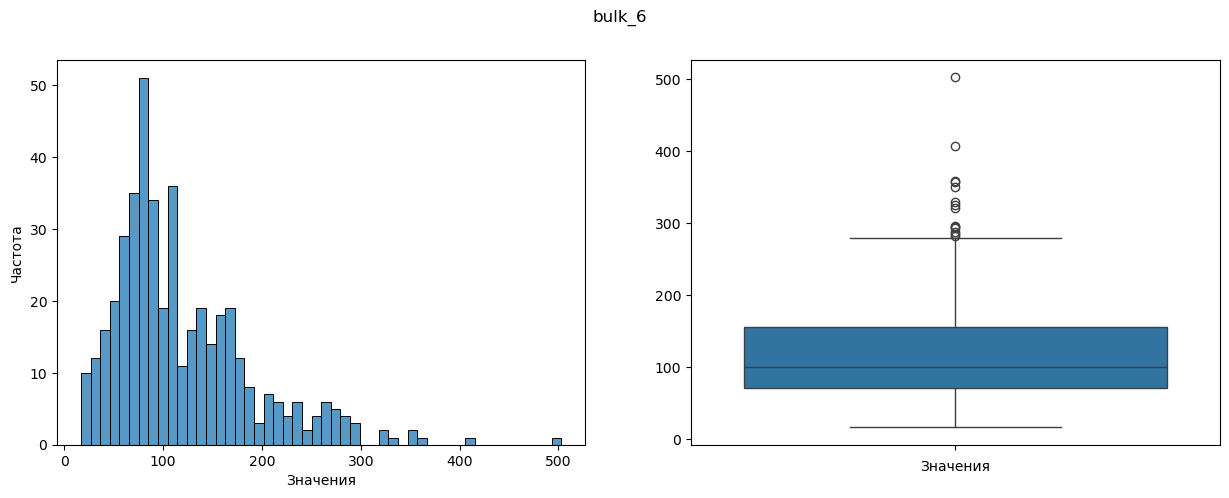

count    437.000000
mean     119.228833
std       70.823937
min       17.000000
25%       72.000000
50%      100.000000
75%      156.000000
max      503.000000
Name: bulk_6, dtype: float64

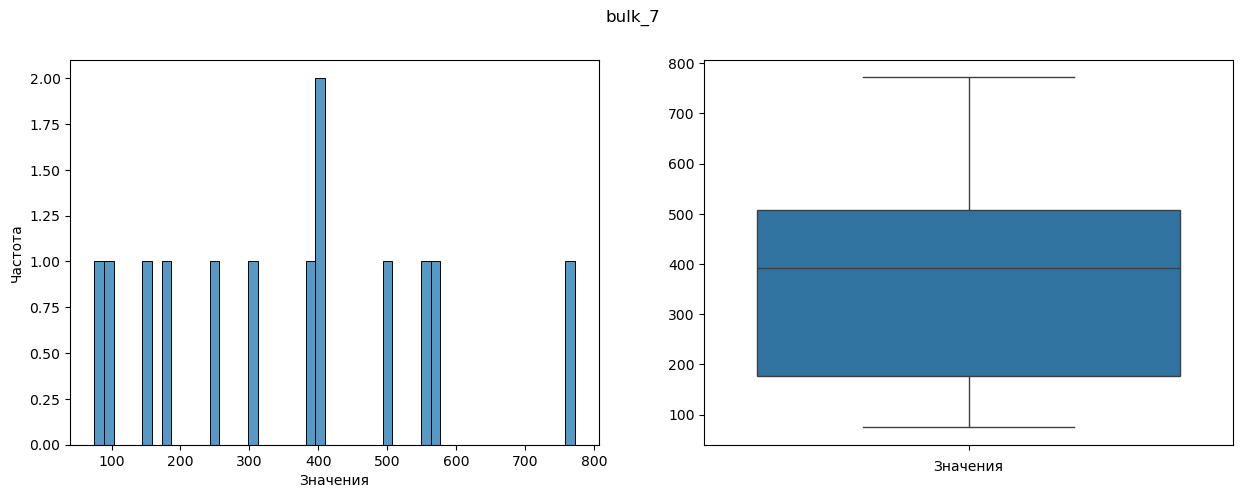

count     13.000000
mean     359.153846
std      208.804472
min       75.000000
25%      178.000000
50%      392.000000
75%      507.000000
max      772.000000
Name: bulk_7, dtype: float64

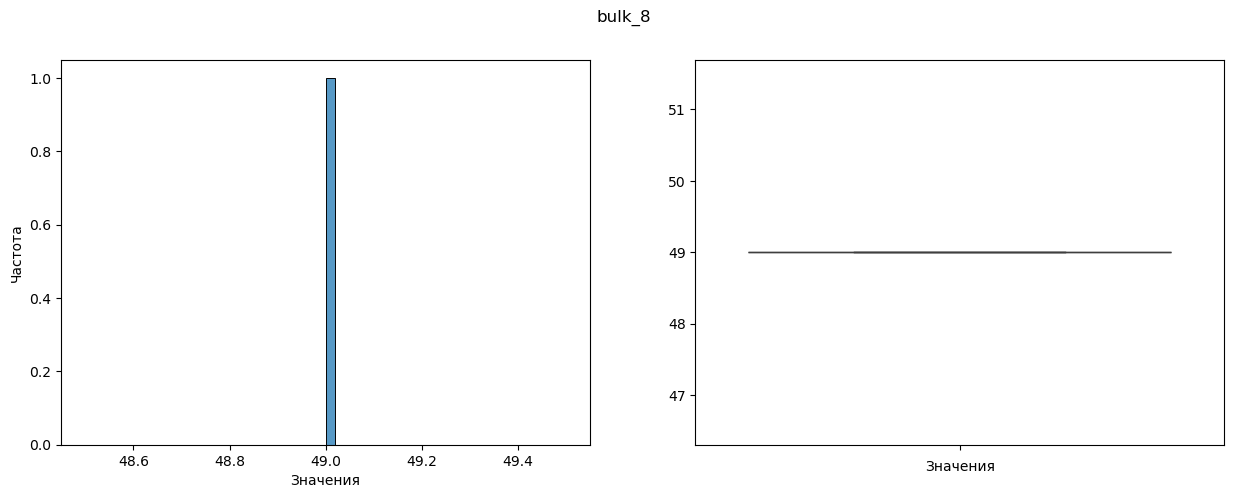

count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: bulk_8, dtype: float64

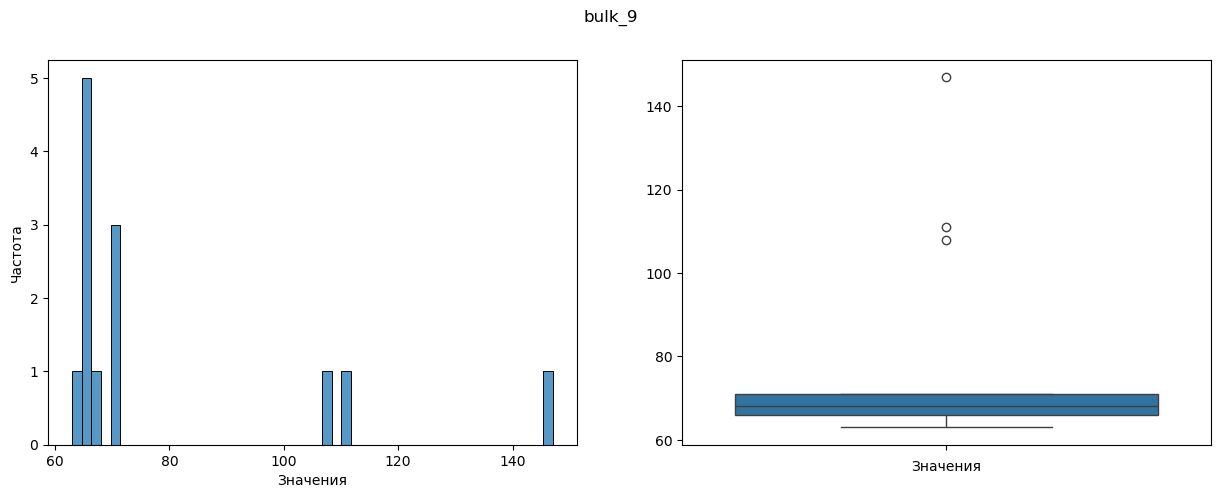

count     13.000000
mean      79.692308
std       25.795299
min       63.000000
25%       66.000000
50%       68.000000
75%       71.000000
max      147.000000
Name: bulk_9, dtype: float64

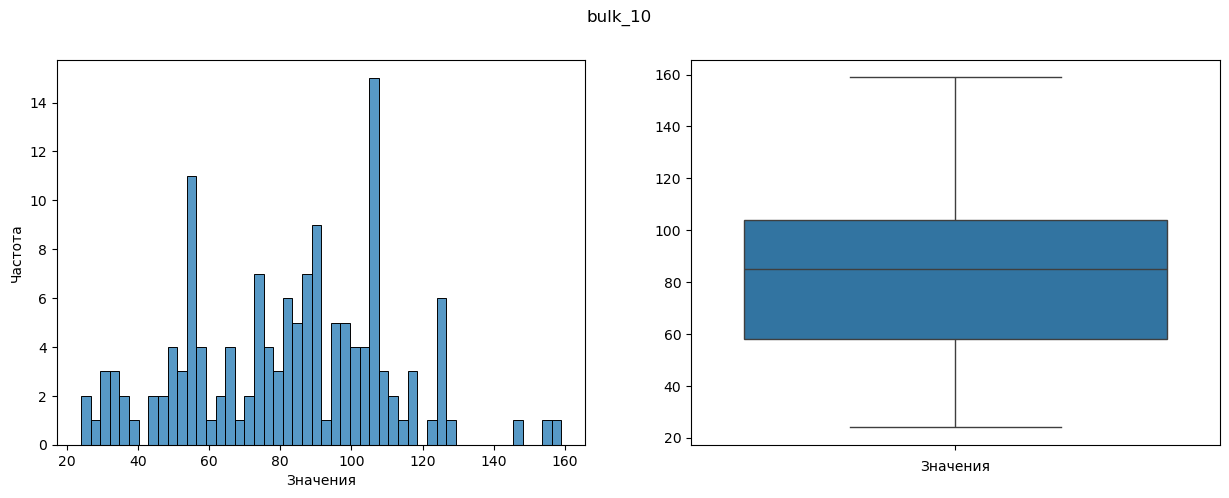

count    143.000000
mean      82.293706
std       27.788900
min       24.000000
25%       58.000000
50%       85.000000
75%      104.000000
max      159.000000
Name: bulk_10, dtype: float64

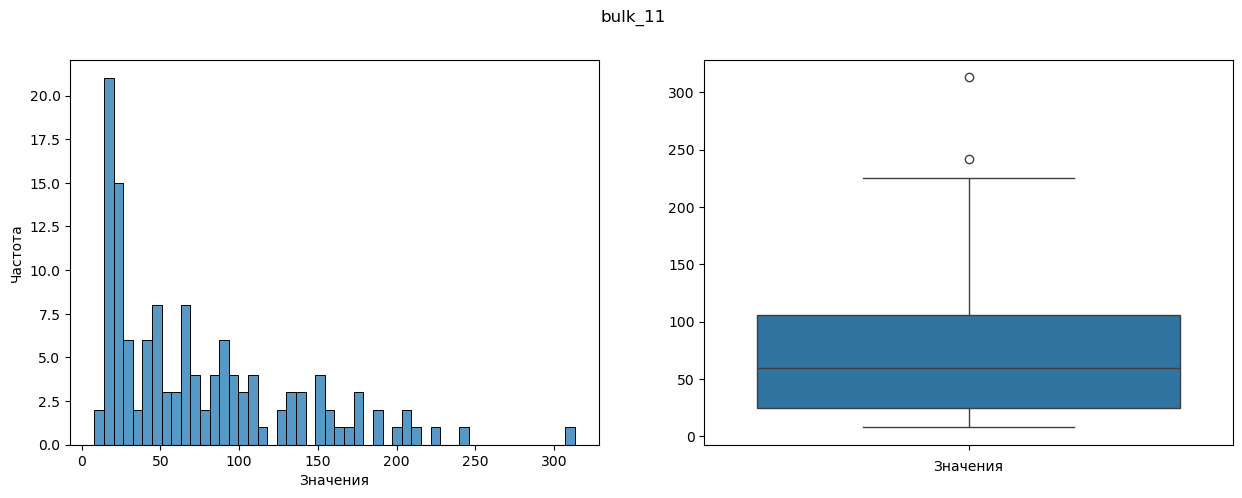

count    130.000000
mean      76.053846
std       60.373554
min        8.000000
25%       25.000000
50%       60.000000
75%      105.500000
max      313.000000
Name: bulk_11, dtype: float64

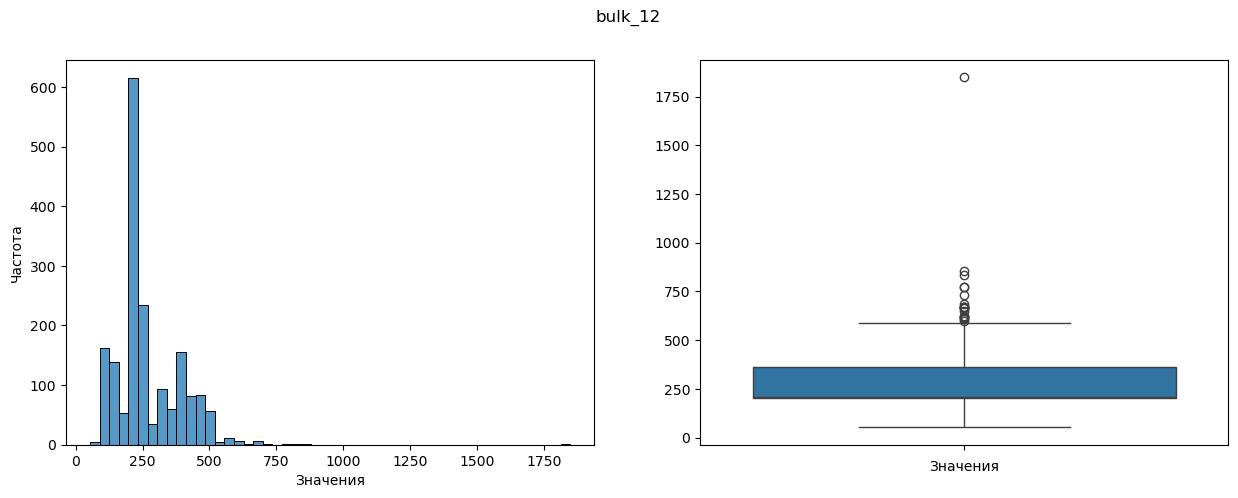

count    1809.000000
mean      267.982863
std       125.667744
min        53.000000
25%       204.000000
50%       208.000000
75%       360.000000
max      1849.000000
Name: bulk_12, dtype: float64

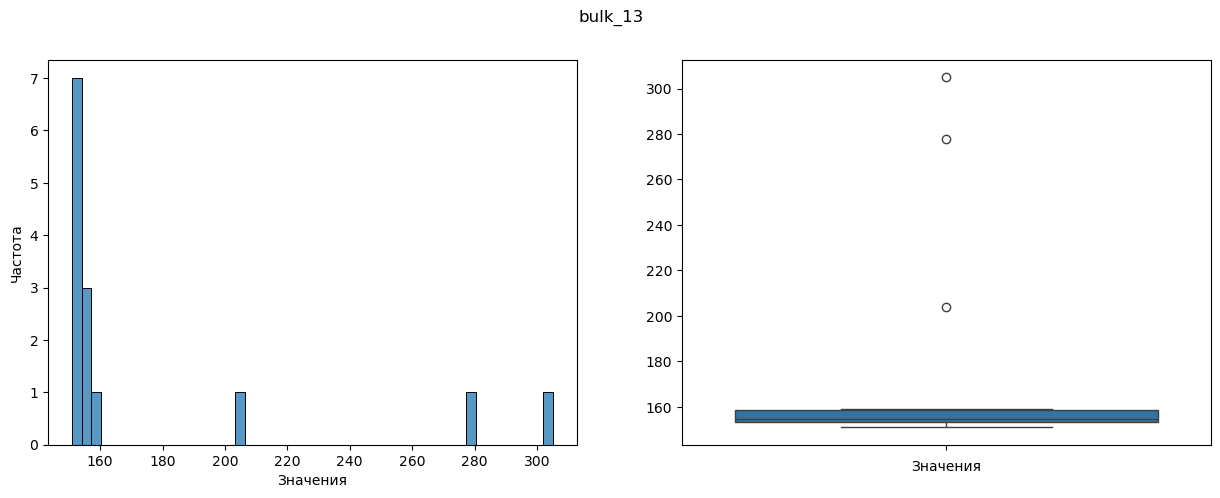

count     14.000000
mean     177.571429
std       50.344527
min      151.000000
25%      153.250000
50%      154.500000
75%      158.500000
max      305.000000
Name: bulk_13, dtype: float64

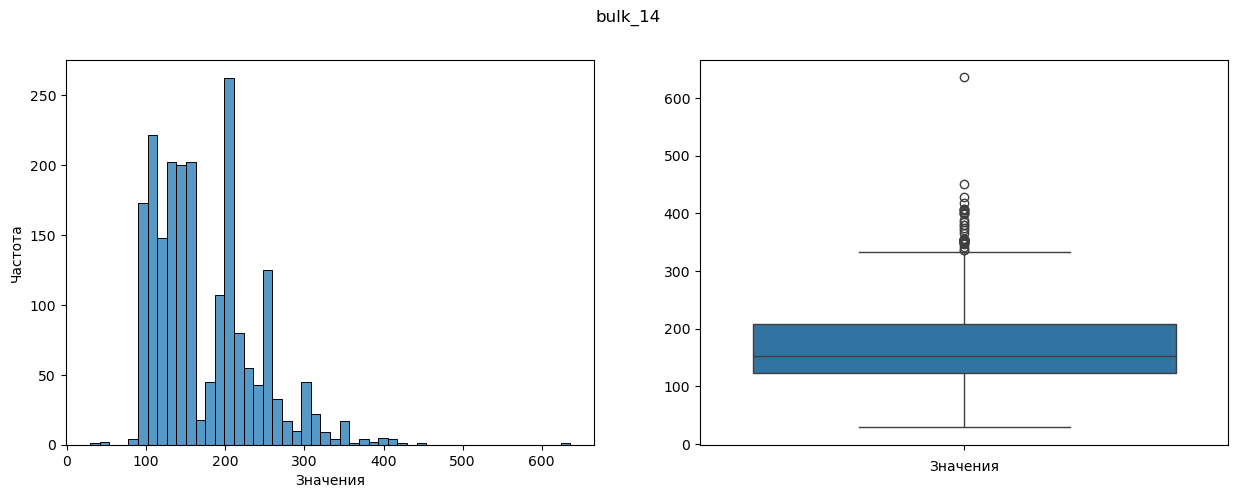

count    2064.000000
mean      173.345930
std        64.028044
min        29.000000
25%       123.000000
50%       153.000000
75%       208.000000
max       636.000000
Name: bulk_14, dtype: float64

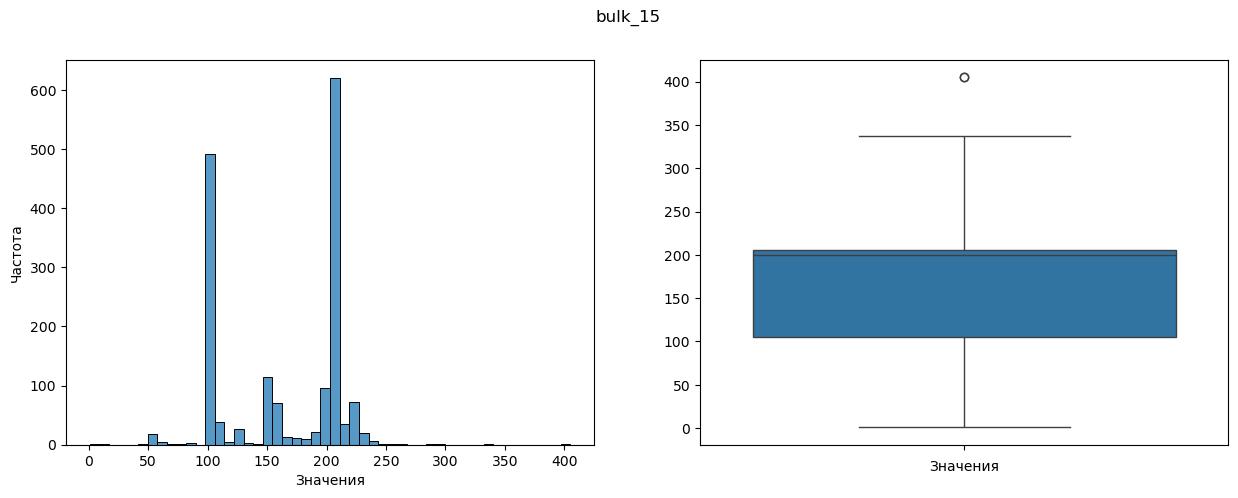

count    1696.000000
mean      164.541274
std        50.015721
min         1.000000
25%       105.000000
50%       200.000000
75%       205.000000
max       405.000000
Name: bulk_15, dtype: float64

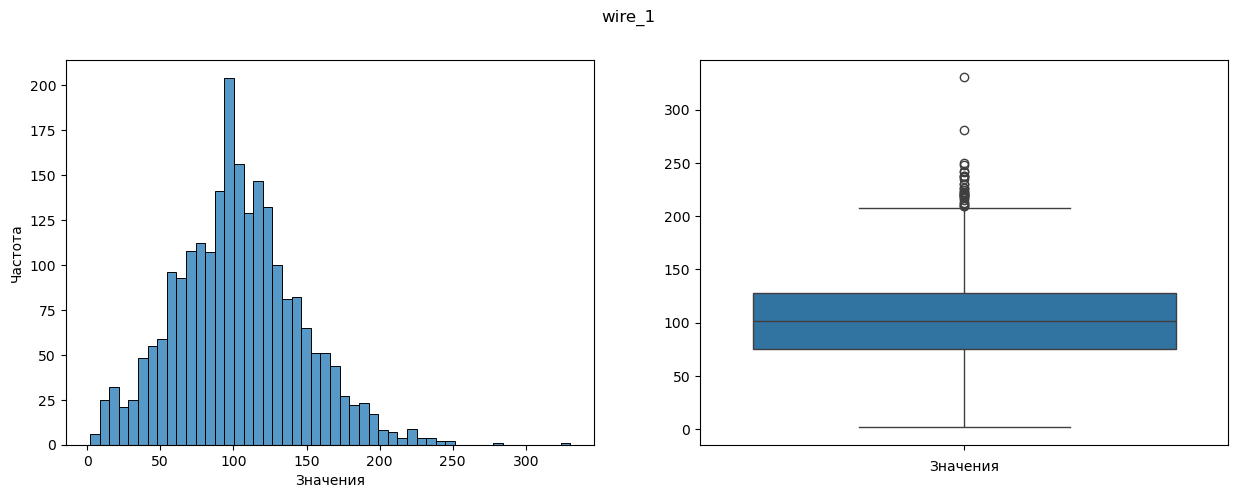

count    2301.000000
mean      103.447694
std        42.530219
min         1.918800
25%        75.042236
50%       102.036476
75%       128.185211
max       330.314424
Name: wire_1, dtype: float64

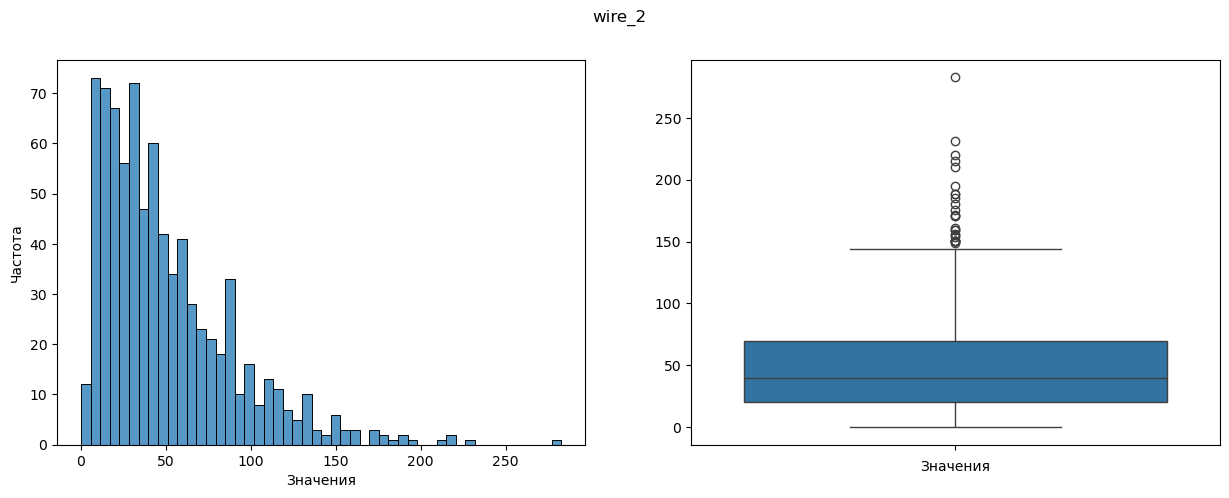

count    809.000000
mean      50.597164
std       39.800935
min        0.030160
25%       20.180161
50%       40.112801
75%       70.061684
max      282.780152
Name: wire_2, dtype: float64

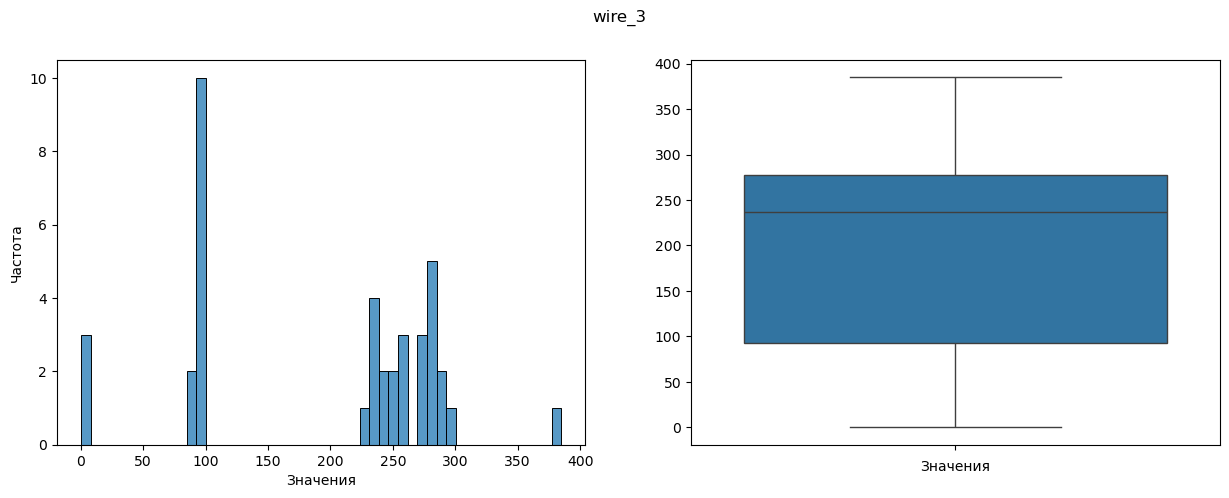

count     39.000000
mean     193.182538
std      100.867783
min        0.144144
25%       93.189102
50%      236.972740
75%      277.068801
max      385.008668
Name: wire_3, dtype: float64

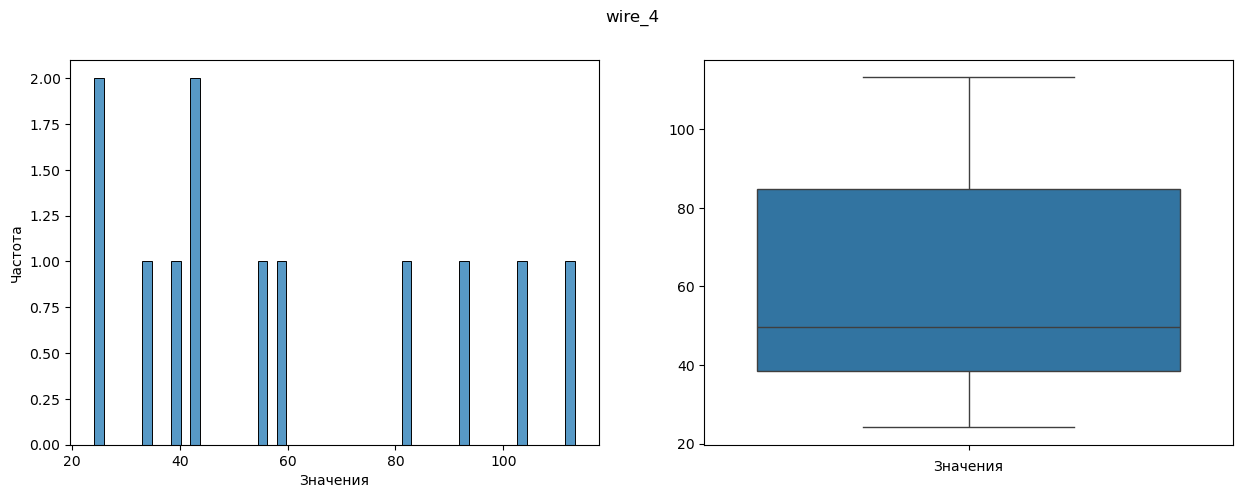

count     12.000000
mean      59.496235
std       30.804638
min       24.148801
25%       38.347402
50%       49.661561
75%       84.755579
max      113.231044
Name: wire_4, dtype: float64

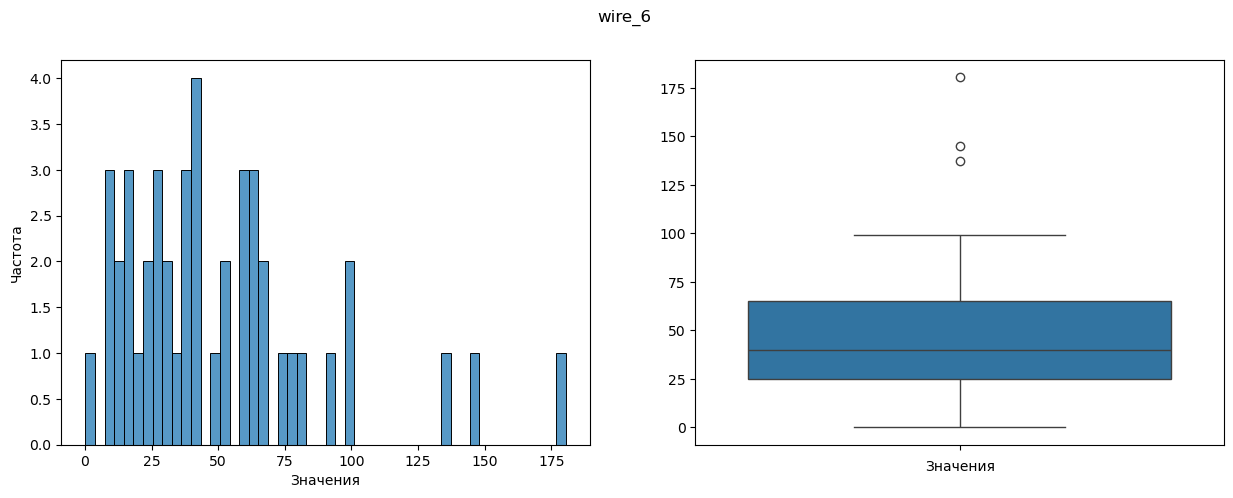

count     45.000000
mean      50.659374
std       37.743040
min        0.137280
25%       25.053600
50%       40.085762
75%       65.036400
max      180.454575
Name: wire_6, dtype: float64

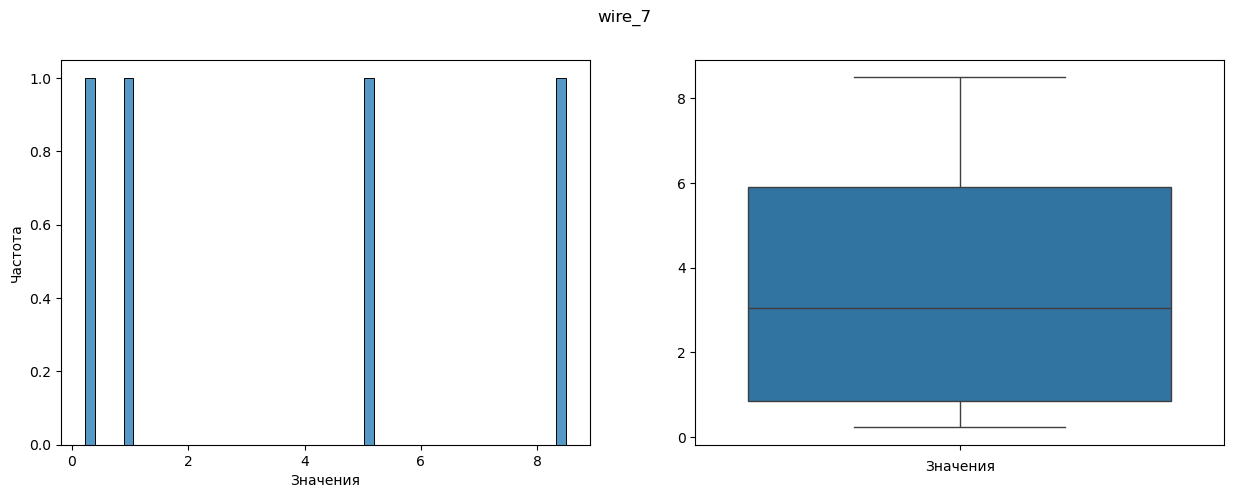

count    4.000000
mean     3.703414
std      3.818433
min      0.234208
25%      0.849004
50%      3.044704
75%      5.899114
max      8.490040
Name: wire_7, dtype: float64

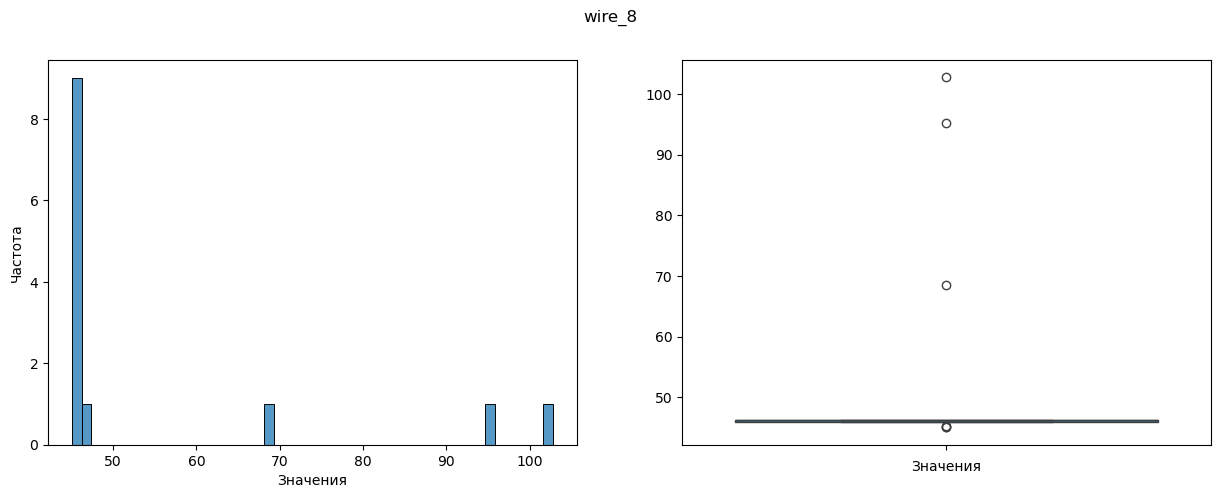

count     13.000000
mean      55.772561
std       20.235591
min       45.076721
25%       46.002319
50%       46.187439
75%       46.279999
max      102.762401
Name: wire_8, dtype: float64

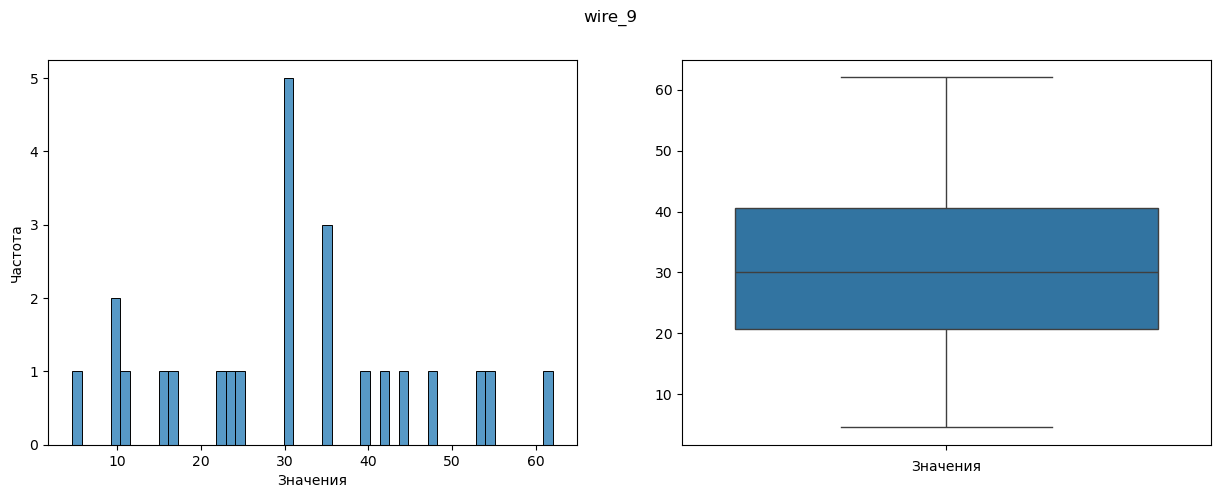

count    24.000000
mean     30.773167
std      15.210141
min       4.622800
25%      20.802601
50%      30.066399
75%      40.495001
max      62.025600
Name: wire_9, dtype: float64

In [73]:
# исследуем данные с нулевыми значениями
for column in list_have_zero:
    numeric_plot(total_data[total_data[column]>0][column])

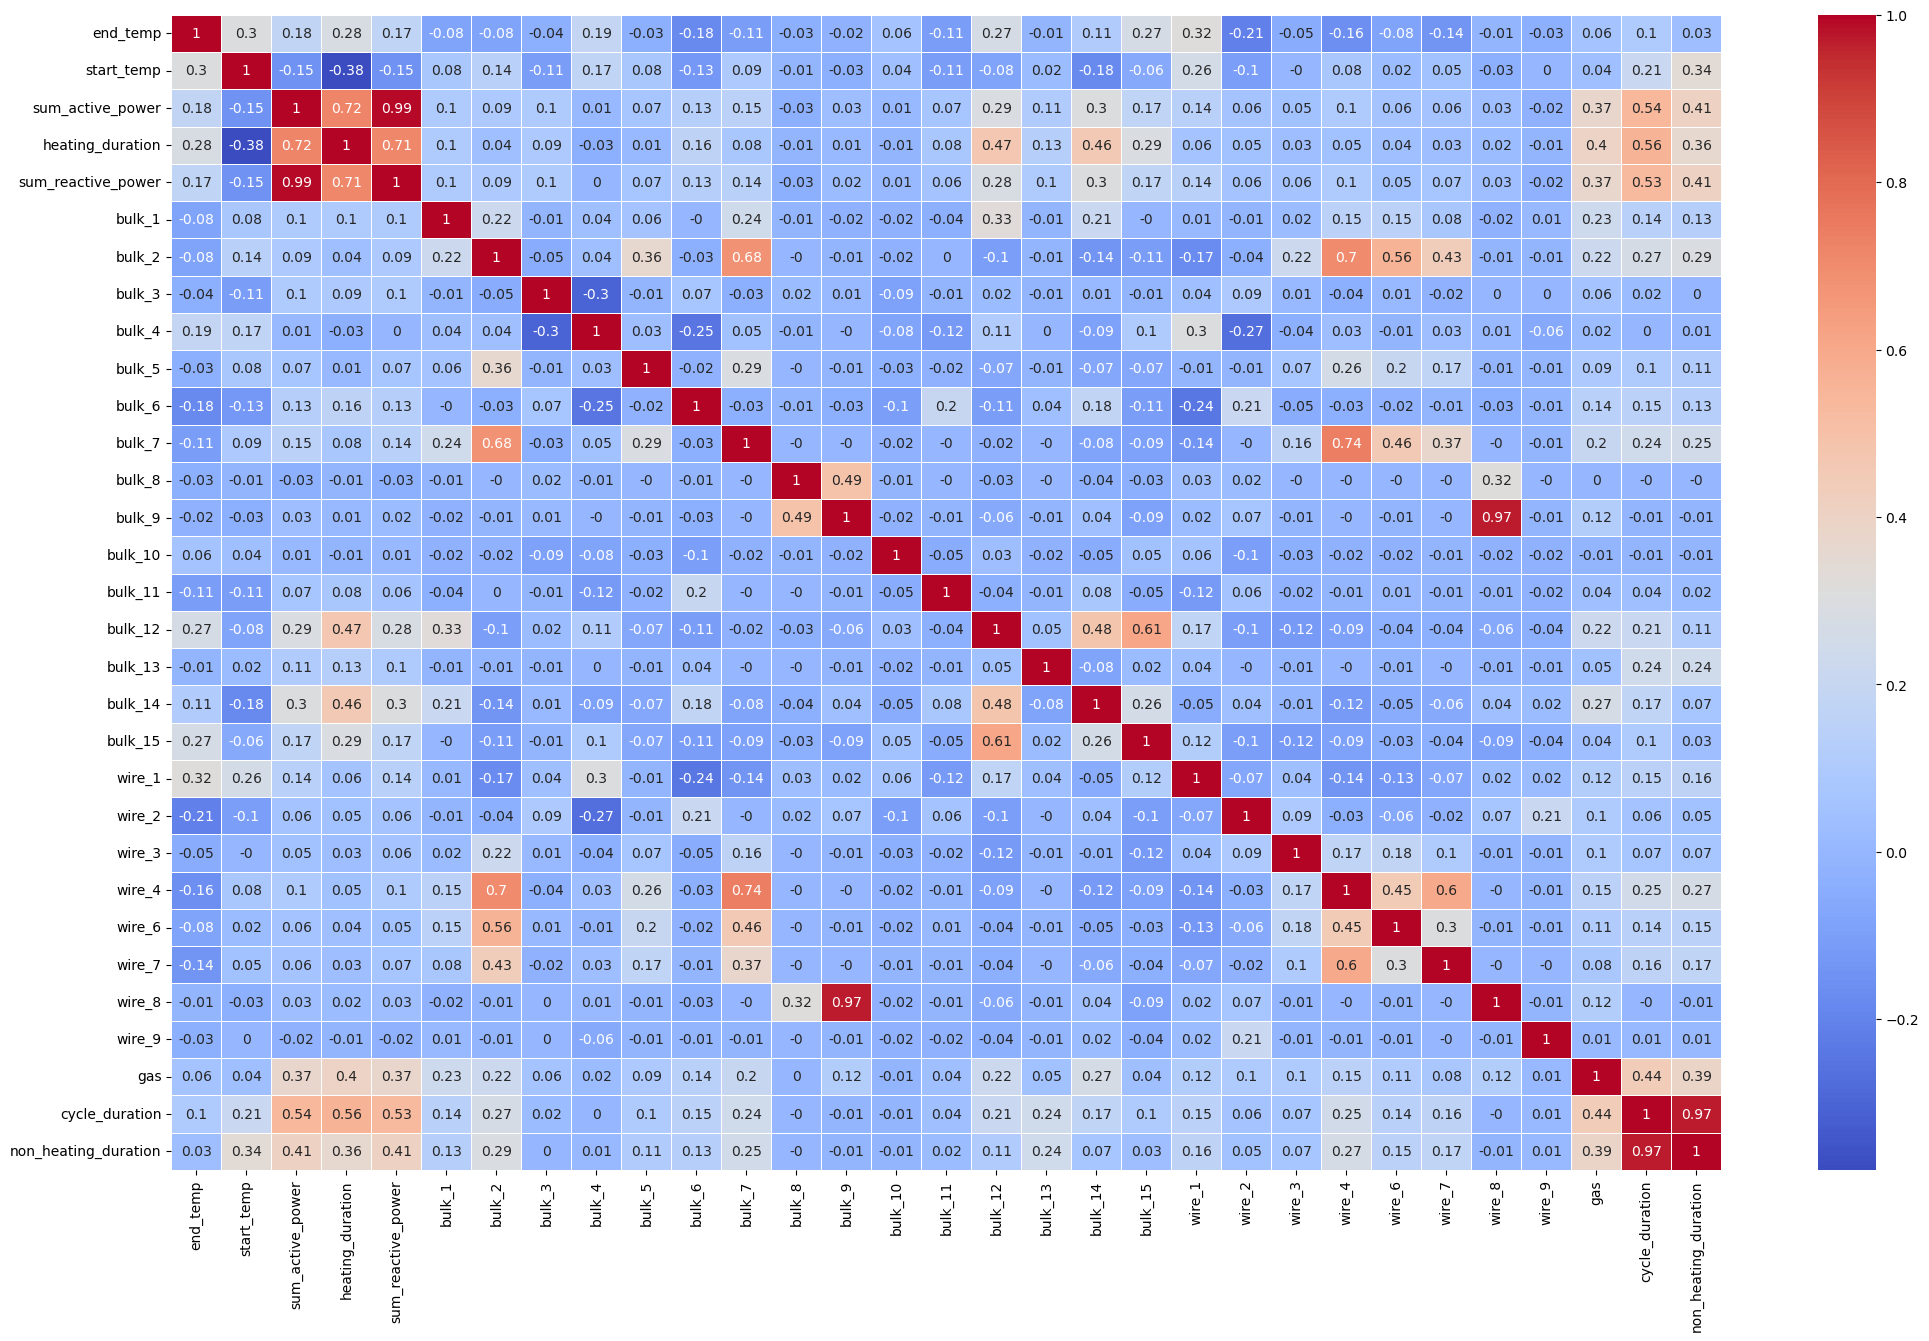

In [74]:
# построим тепловую карту матрицы корреляции признаков
corr_matrix(total_data)

In [75]:
# удалим по одному признаку из трех пар признаков с корреляцией более 0.9,
#а так же признак bulk_8 - так как унего всего лишь одно значение 
total_data = total_data.drop(['sum_reactive_power', 'wire_8', 'bulk_8', 'cycle_duration'], axis=1)

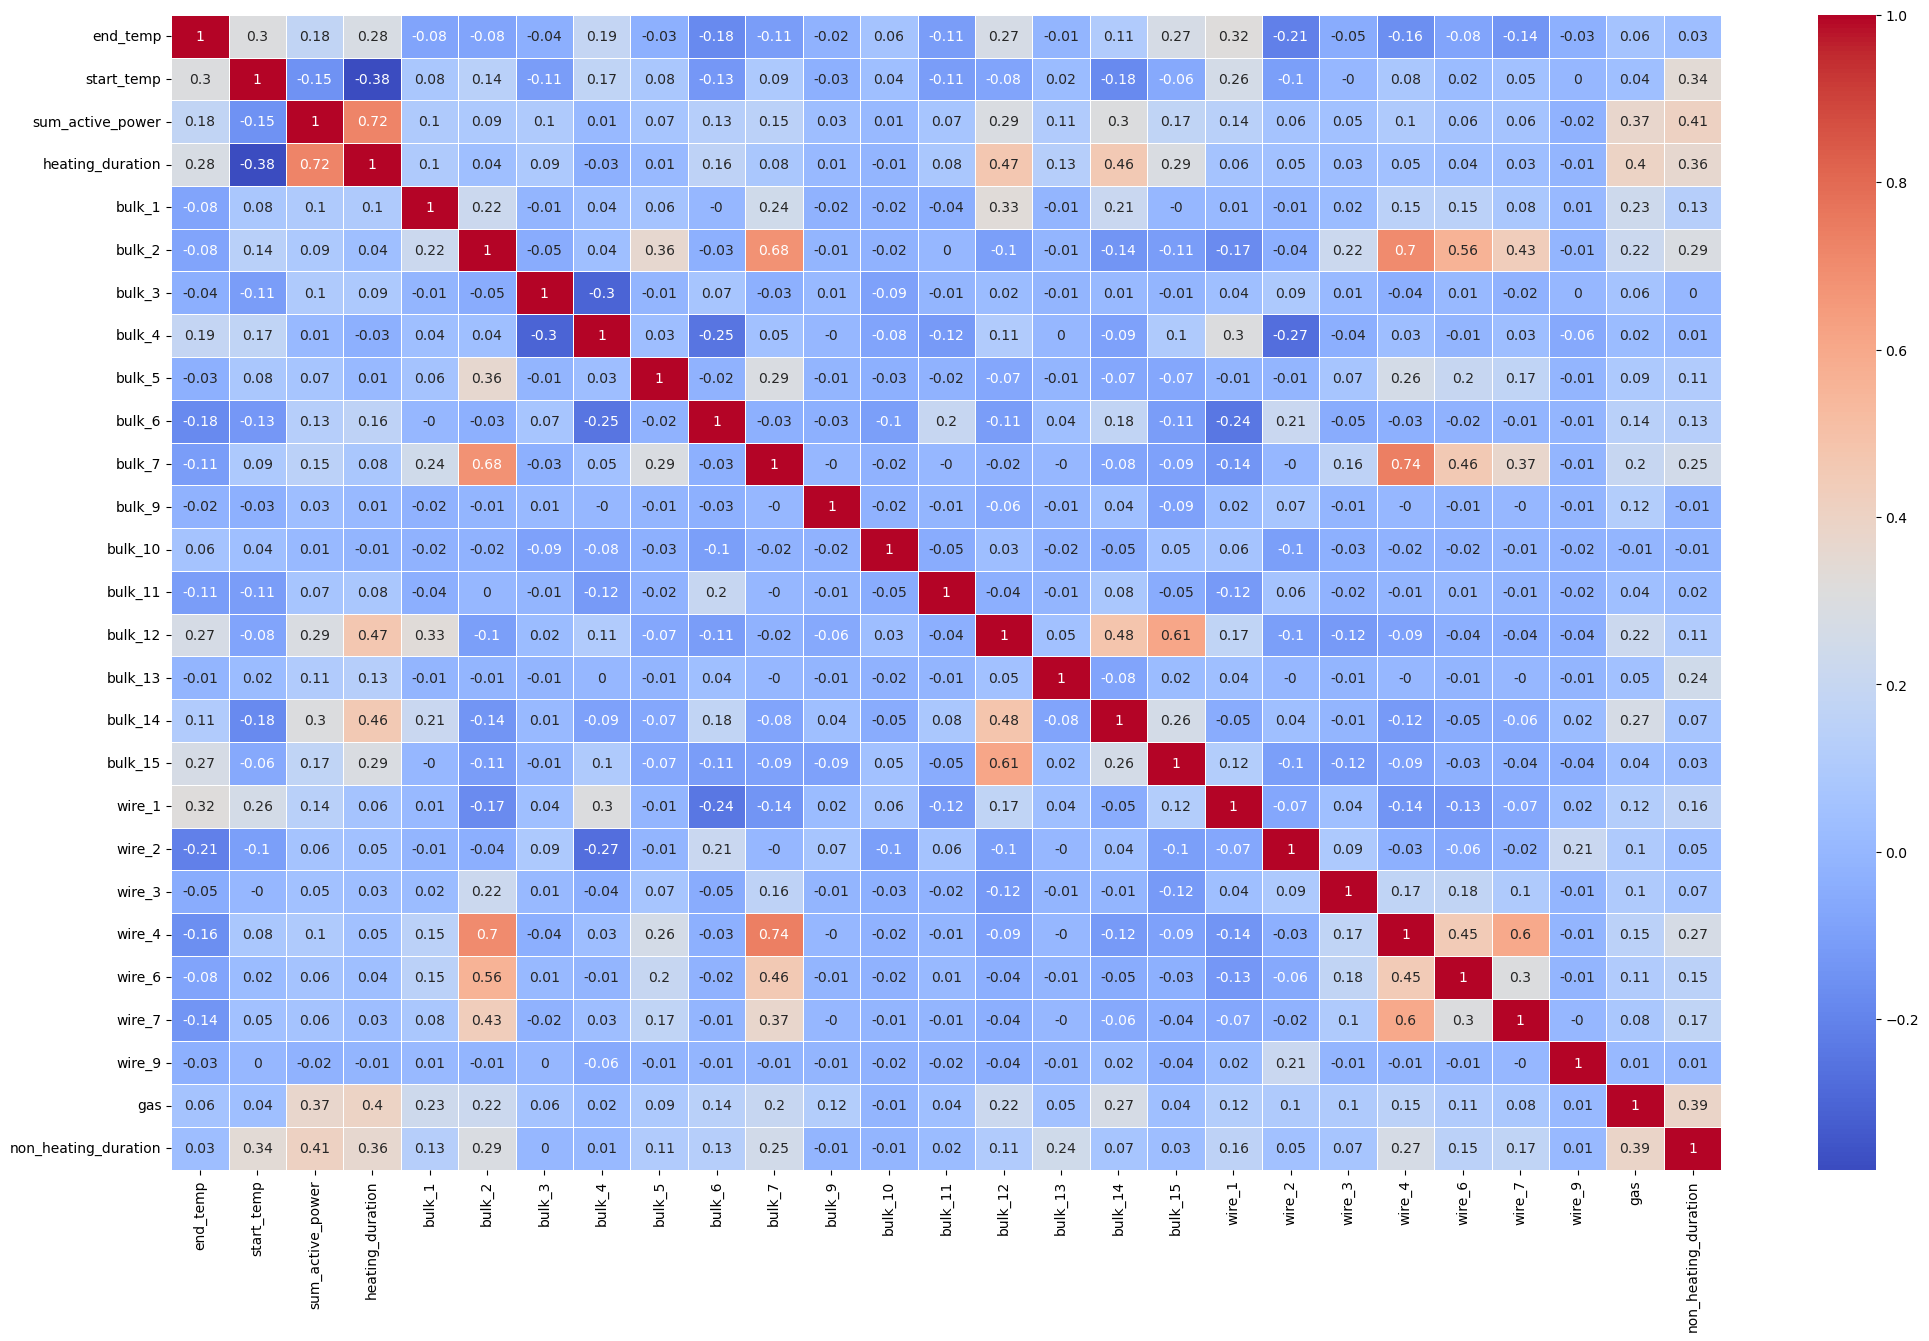

In [76]:
# посмотрим результат
corr_matrix(total_data)

In [77]:
# итоговый датафрейм
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2324 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   end_temp              2324 non-null   float64
 1   start_temp            2324 non-null   float64
 2   sum_active_power      2324 non-null   float64
 3   heating_duration      2324 non-null   float64
 4   bulk_1                2324 non-null   float64
 5   bulk_2                2324 non-null   float64
 6   bulk_3                2324 non-null   float64
 7   bulk_4                2324 non-null   float64
 8   bulk_5                2324 non-null   float64
 9   bulk_6                2324 non-null   float64
 10  bulk_7                2324 non-null   float64
 11  bulk_9                2324 non-null   float64
 12  bulk_10               2324 non-null   float64
 13  bulk_11               2324 non-null   float64
 14  bulk_12               2324 non-null   float64
 15  bulk_13               2324

**Общий вывод по исследовательскому анализу объединенного датафрейма**

Данные для добавок были исследованы без учета нулевых значений.
В ходе проведенного анализа можно сказать следющее:
1. Данные о начальной температуре имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 1587. Имеются статистические выбросы как в области меньших, так и больших значений.

2. Данные о конечной температуре имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 1593. Имеются статистические выбросы как в области меньших, так и больших значений.

3. Данные о суммарной активной энергии имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 3,03. Имеются статистические выбросы как в области бОльших значений.

4. Данные о суммарной реактивной энергии имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 2,23. Имеются статистические выбросы как в области бОльших значений.

5. Данные об общей продолжительности времени нагрева имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 12,97. Имеются статистические выбросы как в области бОльших значений.

6. Данные об общей продолжительности времени операций не относящихся к нагрев, имеют распределение близкое к нормальному, медиана - 20,61; среднее - 25,26. Имеются статистические выбросы как в области бОльших значений.

7. Данные об общей продолжительности всего цикла изготовления партии, имеют распределение близкое к нормальному, медиана - 34,11; среднее - 38,73. Имеются статистические выбросы как в области бОльших значений.

8. Данные о продувке газом имеют распределение близкое к нормальному, медиана - 10,1; среднее - 11,38. Имеются статистические выбросы как в области бОльших значений.

9. Данные о добавке bulk_3 имеют распределение близкое к нормальному со смещением влево, медиана - 96,5; среднее - 114,79. Имеются статистические выбросы как в области бОльших значений.

10. Данные о добавке bulk_4 имеют распределение близкое к нормальному, медиана - 105; среднее - 107,02. Имеются статистические выбросы как в области бОльших значений.

11. Данные о добавке bulk_6 имеют распределение близкое к нормальному со смещением влево, медиана - 100; среднее - 119,23. Имеются статистические выбросы как в области бОльших значений.

12. Данные по остальным сыпучим добавкам не имеют ярко выраженного распределения, в силу своей малочисленности. В столбце bulk_8 всего одно значение.

13. Данные о добавке wire_1 имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 102.04. Имеются статистические выбросы как в области бОльших значений.

14. Данные о добавке wire_2 имеют распределение близкое к нормальному со смещением влево, медиана - 40,11; среднее - 50.6. Имеются статистические выбросы как в области бОльших значений.

15. Данные по остальным gпроволочным добавкам не имеют ярко выраженного распределения, в силу своей малочисленности.

16. Выбросы в данных, могут вполне быть реальными в данными, описывающими реалии технологического процесса, поэтому на данном этапе откажемся от их удаления и обработки.

17. Кореляционный анализ показал, что присутствует три пары мультиколлениарных признаков, с корреляцией более 90%. По одному признаку из данных пар были удалены из датафрейма, а именно: 'sum_reactive_power', 'wire_8', 'cycle_duration'. Так же был удален признак 'bulk_8', так как имеет только одно не нулевое значение.

18. В итоговом датафрейме осталось 27 столбцов, 2324 строк.

## Машинное обучение

### Подготовка выборок

In [78]:
# разделяем признаки и целевой признак
target = total_data['end_temp']
features = total_data.drop(['end_temp'], axis=1)

# проверим размерность
print(features.shape, target.shape)

(2324, 26) (2324,)


In [79]:
#разделим выборки на обучающую и тестовую
features_train, features_test, target_train, target_test\
= train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

# прверим размерность
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(1743, 26) (1743,)
(581, 26) (581,)


### Модель LGBMRegressor

In [80]:
# зададим список варьируемых параметров
param_grid_lgb = {
                 'num_leaves':[x for x in range(10,21)], 
                 'learning_rate':[x/100 for x in range(1, 11)]
                 }

In [81]:
%%time
# инициализируем модель и подбор параметров
model = lgb.LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)

tuning_model_lgb=GridSearchCV(estimator=model,
                             param_grid=param_grid_lgb,
                             scoring='neg_mean_absolute_error',
                             cv=CV,
                             verbose=-1)

# приступим к обучению
tuning_model_lgb.fit(features_train, target_train)

CPU times: total: 2min 35s
Wall time: 26.3 s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=141024, verbose=-1),
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                           0.07, 0.08, 0.09, 0.1],
                         'num_leaves': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                        20]},
             scoring='neg_mean_absolute_error', verbose=-1)

In [82]:
# определим лучшие параметры модели и значение метрики МАЕ
best_model_lgb = tuning_model_lgb.best_params_
display(tuning_model_lgb.best_params_)
mae_lgb = tuning_model_lgb.best_score_*-1
print('Значение МАЕ на кросс-валидации:', mae_lgb)

{'learning_rate': 0.09, 'num_leaves': 10}

Значение МАЕ на кросс-валидации: 5.900806340849132


### Модель XGBRegressor

In [83]:
param_grid_xgb= {
                 'learning_rate':[x/100 for x in range(1, 11)]
                }

In [84]:
%%time
model_xgb = XGBRegressor(random_state=RANDOM_STATE) 
tuning_model_xgb=GridSearchCV(estimator=model_xgb,
                            param_grid=param_grid_xgb,
                            scoring='neg_mean_absolute_error',
                            cv=CV,
                            verbose=-1)

# приступим к обучению с определением лучших параметров
tuning_model_xgb.fit(features_train, target_train)

CPU times: total: 2min 9s
Wall time: 11.3 s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=141024, ...),
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                           0.07, 0.08, 0.09, 0.1]},
             scoring='neg_mean_absolute_error', verbose=-1)

In [85]:
# определим лучшие параметры модели и значение метрики МАЕ
best_model_xgb = tuning_model_xgb.best_params_
display(tuning_model_xgb.best_params_)
mae_xgb = tuning_model_xgb.best_score_*-1
print('Значение МАЕ на кросс-валидации:', mae_xgb)

{'learning_rate': 0.07}

Значение МАЕ на кросс-валидации: 5.985355661462128


### Модель RandomForestRegressor

In [86]:
param_grid_rfr = {
                  'n_estimators':[x for x in range(20, 101, 10)],
                  'max_depth':[x for x in range(2,20,1)],
                  'max_features': ['auto', 'sqrt', 'log2']
                  }

In [87]:
%%time
model_rfr = RandomForestRegressor(random_state=RANDOM_STATE) 
tuning_model_rfr=GridSearchCV(estimator=model_rfr,
                            param_grid=param_grid_rfr,
                            scoring='neg_mean_absolute_error',
                            cv=CV,
                            verbose=-1,
                            n_jobs=-1)

# приступим к обучению с определением лучших параметров
tuning_model_rfr.fit(features_train, target_train)

CPU times: total: 11.2 s
Wall time: 2min 11s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=141024),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100]},
             scoring='neg_mean_absolute_error', verbose=-1)

In [88]:
# определим лучшие параметры модели и значение метрики МАЕ
best_model_rfr = tuning_model_rfr.best_params_
display(tuning_model_rfr.best_params_)
mae_rfr = tuning_model_rfr.best_score_*-1
print('Значение МАЕ на кросс-валидации:', mae_rfr)

{'max_depth': 12, 'max_features': 'auto', 'n_estimators': 90}

Значение МАЕ на кросс-валидации: 6.11992924188756


### Модель LinearRegressor

In [89]:
# для линейной модели понадобится нормализация данных, поэтому подготовим выборки отдельно
features_train_lr, features_test_lr = features_train.copy(), features_test.copy()

In [90]:
columns = features_train_lr.columns.to_list()
# обучим скалер и масштабируем числовые признаки на трейне
scaler = MinMaxScaler()
scaler.fit(features_train_lr[columns])
features_train_lr[columns] = scaler.transform(features_train_lr[columns])
features_train_lr.head()

,start_temp,sum_active_power,heating_duration,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,gas,non_heating_duration
key,,,,,,,,,,,,,,,,,,,,,
1893,0.621429,0.188054,0.137112,0.0,0.0,0.143820,0.0000,0.0,0.000000,0.0,...,0.256790,0.424341,0.000000,0.0,0.0,0.0,0.0,0.0,0.184855,0.091708
1317,0.350000,0.290244,0.210756,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0,...,0.000000,0.275715,0.000000,0.0,0.0,0.0,0.0,0.0,0.161440,0.028675
2380,0.378571,0.365492,0.230862,0.0,0.0,0.303371,0.0000,0.0,0.212724,0.0,...,0.259259,0.272938,0.000000,0.0,0.0,0.0,0.0,0.0,0.061524,0.089693
2025,0.578571,0.025021,0.044089,0.0,0.0,0.000000,0.0000,0.0,0.332008,0.0,...,0.000000,0.188042,0.035943,0.0,0.0,0.0,0.0,0.0,0.036687,0.075484
1478,0.657143,0.373216,0.185562,0.0,0.0,0.000000,0.6121,0.0,0.000000,0.0,...,0.256790,0.596770,0.000000,0.0,0.0,0.0,0.0,0.0,0.153778,0.102196


In [91]:
# трансформируем тест
features_test_lr[columns] = scaler.transform(features_test_lr[columns])
features_test_lr.head()

,start_temp,sum_active_power,heating_duration,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,gas,non_heating_duration
key,,,,,,,,,,,,,,,,,,,,,
2386,0.285714,0.298689,0.198159,0.0,0.0,0.065169,0.000000,0.0,0.244533,0.0,...,0.256790,0.218457,0.16009,0.0,0.0,0.0,0.0,0.0,0.129915,0.040248
379,0.678571,0.257651,0.120640,0.0,0.0,0.000000,0.316726,0.0,0.000000,0.0,...,0.254321,0.503400,0.00000,0.0,0.0,0.0,0.0,0.0,0.163411,0.119039
173,0.214286,0.463540,0.244186,0.0,0.0,0.707865,0.000000,0.0,0.556660,0.0,...,0.000000,0.278492,0.00000,0.0,0.0,0.0,0.0,0.0,0.080719,0.056265
429,0.392857,0.223864,0.234012,0.0,0.0,0.000000,0.320285,0.0,0.000000,0.0,...,0.550617,0.321479,0.00000,0.0,0.0,0.0,0.0,0.0,0.108099,0.076569
1881,0.457143,0.403704,0.394380,0.0,0.0,0.065169,0.000000,0.0,0.656064,0.0,...,0.508642,0.489515,0.00000,0.0,0.0,0.0,0.0,0.0,0.471487,0.566210


In [92]:
# пустой словар для кросс-валидации
param_lr = {}
# инициализируем модель и подбор параметров
model_lr = LinearRegression()
tuning_model_lr=GridSearchCV(estimator=model_lr,
                          param_grid=param_lr,
                          scoring='neg_mean_absolute_error',
                          cv=5,
                          verbose=-1,
                          n_jobs = -1)

# приступим к обучению с определением лучших параметров и RSME
tuning_model_lr.fit(features_train_lr, target_train)
mae_lr = tuning_model_lr.best_score_*-1
print('Значение МАЕ на кросс-валидации:', mae_lr)

Значение МАЕ на кросс-валидации: 5.989261322971982


### Анализ моделей

In [93]:
# сформируем сводную таблицу с результатми моделей на кросс-валидации
result = pd.DataFrame(
    [
        [ mae_lgb],
        [mae_xgb],
        [mae_rfr],
        [mae_lr],

    ],
    index=['LGBMRegressor', 'XGBRegressor', 'RandomForestRegressor', 'LinearRegression'], 
    columns=['MAE на кросс-валидации']
)
result

,MAE на кросс-валидации
LGBMRegressor,5.900806
XGBRegressor,5.985356
RandomForestRegressor,6.119929
LinearRegression,5.989261


Было исследовано несколько моделей на кросс-валидации, с подбором лучших параметров:LGBMRegressor, XGBRegressor, RandomForestRegressor, LinearRegression.
Лучшей моделью на кросс-валидации является LGBMRegressor со значением МАЕ = 5,901. Перейдем к тестированию на тестовой выборке

### Тестирование лучшей модели

In [94]:
# обучим модель на лучших параметрах
model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE, **best_model_lgb)
model_lgb.fit(features_train, target_train)

LGBMRegressor(learning_rate=0.09, num_leaves=10, random_state=141024)

In [95]:
# спрогнозируем результат и выведем метрику
target_predict = model_lgb.predict(features_test)
final_MAE = mean_absolute_error(target_test, target_predict)
print('МАЕ на тестовой выборке:', final_MAE)

МАЕ на тестовой выборке: 5.821777593396537


Модель показала метрику МАЕ на тестовой выборке 5.822, метрика оказалась лучше требований заказчика. Лучшая модель LGBMRegressor с параметрами: learning_rate=0.09, num_leaves=10, random_state=141024.

### Проверка адекватности лучшей модели

In [96]:
# проверим модель на адекватность простейшей моделью со средним значением
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(features_train, target_train)
dummy_regr_predict = dummy_regr.predict(features_test)
dummy_mae = mean_absolute_error(target_test,dummy_regr_predict)
print('MAE для модели Дамми составляет:', dummy_mae)

MAE для модели Дамми составляет: 7.60751785109458


Простейшая модель угадывания среднего, показала метрику хуже нашей модели. Значит наша модель адекватна.

### Анализ важности признаков

Проанализируем важность признаков.

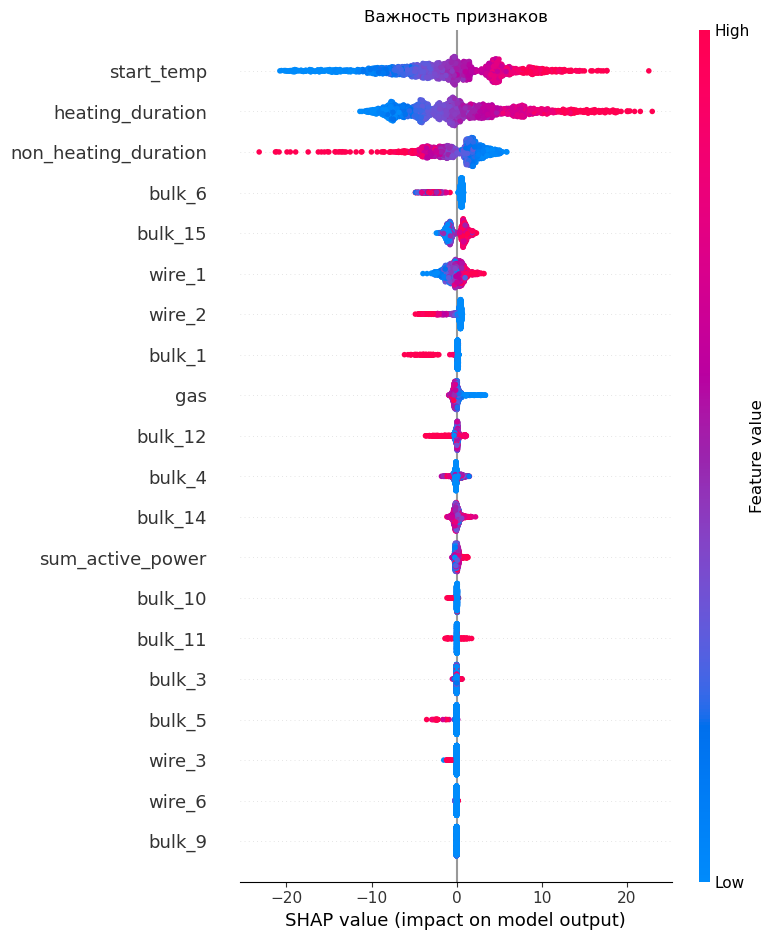

In [97]:
# посчитаем SHAP значения и выведем графики
explainer = shap.TreeExplainer(model_lgb, features_train)
shap_values = explainer(features_train)
plt.title('Важность признаков')
shap.summary_plot(shap_values)

В целом можно сказать следующее:
1. Наибольшую важность в предсказании конечной температуры имеют (в порядке убывания): начальная температура процесса, время нагрева электродами, время технологических операций не связанных с нагревом:

- чем выше начальная температура процесса, тем выше будет конечная температура и наоборот;

- чем больше время нагрева электродами, тем выше будет конечная температура и наоборот;

- чем короче время технологических операций не связанных с нагревом, тем выше будет конечная температура и наоборот;


2. Далее с гораздо меньшей степенью влияния в предсказании конечной температуры (в порядке убывания):

- чем больше в рецептуре добавки bulk_15, тем выше конечная температура и наоборот;

- чем больше в рецептуре добавки bulk_6, тем ниже конечная температура и наоборот;

- чем больше в рецептуре добавки wire_1, тем выше конечная температура и наоборот;

- чем больше в рецептуре добавки wire_2, тем ниже конечная температура и наоборот;

- чем больше в рецептуре добавки bulk_1, тем ниже конечная температура и наоборот;

- чем больший объем газа пропускается через сплав, тем ниже конечная температура и наоборот.

Остальные признаки дают очень малые и неочевидные вклады.

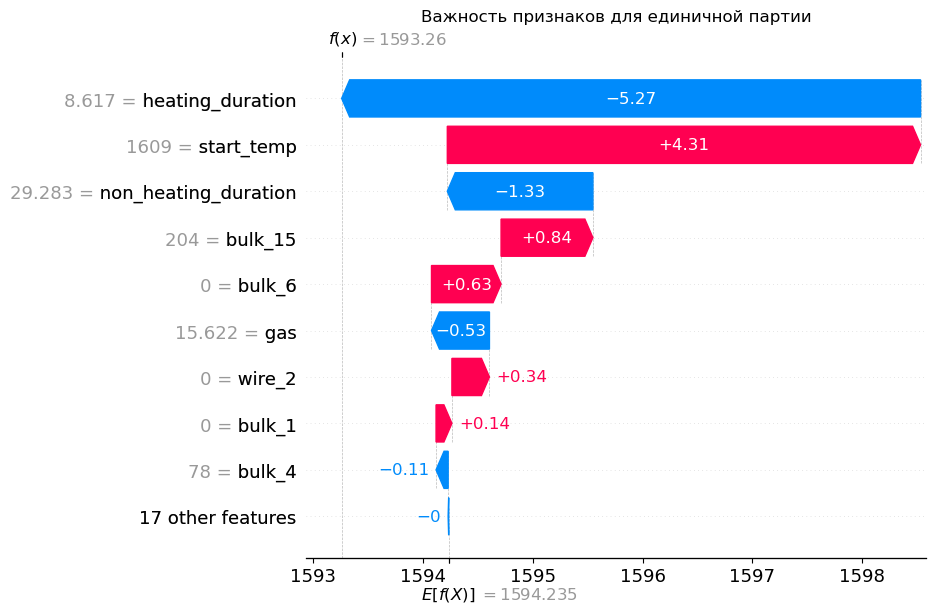

In [98]:
plt.title('Важность признаков для единичной партии')
shap.plots.waterfall(shap_values[52])

## Итоговый вывод по проекту.

**Заказчиком была поставлена цель: разработать модель, предсказывающую температуру расплавленной стали, на основе имитации технологического процесса заказчика. Требования по метрике качества: МАЕ < 6.8 на тестовой выборке.** 

Были предоставлены 7 наборов данных с различными технологическими параметрами.
В ходе исследования были проделаны следующие этапы:

-----------------------------------------------------
<u>**Этап первичного исследовательского анализа данных**</u>

-----------------------------------------------------


**Данные по электродам**
- размерность датасета 14876 строк и 5 стобцов;
- пропуски в данных отстуствуют;
- явные дубликаты отстуствуют;
- типы данных корректны, даты приведены к нужному формату;
- распределение данных по параметру активной энергии близко к нормальному, с выраженным смещением влево, так же присуствуют статистические выбросы в области бОльших значений;
- распределние реактивной энергии точно не определено из-за присуствующего большого отрицательного выброса значений, в дальнейшем проработаем данный момент;
- в числовых столбцах отстуствуют явные нулевые значения;
- в данном датафрейме номер партии может быть описан несколькими строками
---------------------------------------------------------------------------

**Данные о подаче сыпучих материалов - объем**

- размерность датасета 3129 строк и 16 стобцов;
- в данных присуствует большое количество пропусков, для некоторых сыпучих материалов - доля пропусков более 99 %, так например для добавки Bulk 8 присутствует всего одно значение;
- в столбце с номером партии пропуски отстуствуют;
- явные дубликаты отстуствуют;
- типы данных корректны;
- из всех данных по объему сыпучих добавок, к нормальному распределению близки Bulk 4 и Bulk 10, Bulk 3 смещено влево, Bulk 10 смещено вправо, данные по остальным сыпучим добавам не имеют ярко выраженного распределения;
- практически для всех сыпучих материалов наблюдаются статистические выбросы в данных в области бОльших значений;
- в числовых столбцах отстуствуют явные нулевые значения;
- по частоте использования в рецептуре стали добавки можно условно разделить на:
  - редкоиспользуемые: Bulk 1, Bulk 2, Bulk 5, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 22, Bulk 13;
  - среднеиспользуемые: Bulk 3, Bulk 4, Bulk 6;
  - частоиспользуемые: Bulk 12, Bulk 14, Bulk 15.
- по медианному значению объема добавки в рецептуре:
  - малого объема: Bulk 1, Bulk 8, Bulk 9, Bulk 13;
  - среднего объемна: Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 13, Bulk 14, Bulk 15;
  - большого объема: Bulk 2, Bulk 7, Bulk 12.
  
 -----------------------------------------------------------------------------
 
 **Данные о подаче сыпучих материалов - время**

- размерность датасета 3129 строк и 16 стобцов;
- в данных присуствует большое количество пропусков, для некоторых сыпучих материалов - доля пропусков более 99 %;
- в столбце с номером партии пропуски отстуствуют;
- явные дубликаты отстуствуют;

В целом структура данных аналогична, структуре данных по подаче сыпучих компонент - объем, в том числе и по количеству пропусков. 

--------------------------------------------------------------------------------
**Данные о проволочных материалах - объем**

- размерность датасета 3081 строк и 10 стобцов;
- в данных присуствует большое количество пропусков, для некоторых проволочных материалов - доля пропусков более 99 %, так например для добавки Wire 5 присутствует всего одно значение;
- в столбце с номером партии пропуски отстуствуют;
- явные дубликаты отстуствуют;
- типы данных корректны, даты приведены к необходимому формату;
- из всех данных по объему проволчных добавок, к нормальному распределению близко Wire 1 и Wire 6, Wire 2 имеет смещение влево,  данные по остальным проволочным добавам не имеют ярко выраженного распределения;
- практически для всех проволочных материалов наблюдаются статистические выбросы в данных;
- в числовых столбцах отстуствуют нулевые значения;
- по частоте использования в рецептуре стали добавки можно условно разделить на:
  - редкоиспользуемые: Wire 3, Wire 4,	Wire 5,	Wire 6,	Wire 7,	Wire 8,	Wire 9;
  - частоиспользуемые: Wire 1, Wire 2.
- по медианному значению объема добавки в рецептуре:
  - малого объема: Wire 2,	Wire 4,	Wire 5,	Wire 6,	Wire 7,	Wire 8,	Wire 9;
  - большого объема: Wire 1, Wire 3.
  
--------------------------------------------------------------------------------

**Данные о проволочных материалах - время**

- размерность датасета 3081 строк и 10 стобцов;
- в данных присуствует большое количество пропусков, для некоторых проволочных материалов - доля пропусков более 99 %;
- типы данных корректны, даты были приведены к необходимому типу;
- в столбце с номером партии пропуски отстуствуют;
- явные дубликаты отстуствуют;

В целом структура данных аналогична, структуре данных по подаче проволчных компонент - объем, в том числе и по количеству пропусков.

------------------------------------------------------------------------------
**Данные о продувке сплава газом**

- размерность датасета 3239 строк и 2 стобца;
- пропуски в данных отсутствуют;
- явные дубликаты отстуствуют;
- типы данных корректны;
- распределение данных по объему газа близко к нормальному, наблюдается большое количество статистических выбросов в области бОльших значений;
- в числовых столбцах отстуствуют нулевые значения;
- в данном датасете отсутсвуют данные о времени.

------------------------------------------------------------------------------------
**Данные о результатах измерения температуры**

- размерность датасета 15907 строк и 3 столбца;
- наблюдаются пропуски в данных по температуре, чуть более 18%;
- явные дубликаты отстуствуют;
- типы данных корректны, даты приведены к необходимому формату;
- распределение данных по температуре близко к нормальному, наблюдается большое количество статистических выбросов, есть выбросы в обе стороны - в том числе несколько сильных выбросов в области значений температуры менее 1300 градусов (что ниже рабочих температур даже для самых легкоплавких сталей);
- в числовых столбцах отстуствуют нулевые значения;
- в данном датафрейме номер партии может быть описан несколькими строками - при обработке понадобится агрегирование.

-----------------------------------------------------------------------------------
**Сравнение общего количества партий по датафреймам**

Количество партий в датафрейме data_arc_new :  3214

Количество партий в датафрейме data_bulk_new :  3129

Количество партий в датафрейме data_bulk_time_new :  3129

Количество партий в датафрейме data_gas_new :  3239

Количество партий в датафрейме data_temp_new :  3216

Количество партий в датафрейме data_wire_new :  3081

Количество партий в датафрейме data_wire_time_new :  3081

Количество партий различается, в различных датафреймах. Больше всего партий описано в датасете **data_gas**. Меньше всего партий в датасетах, описывающих информацию о проволчных материалах (**data_wire** и **data_wire_time**). Часть датафреймов имеют одинаковое количество описанных партий: 
- данные о сыпучих материалах (**data_bulk** и **data_bulk_time**) - по 3129 партий;
- данные о провочных материалы (**data_wire** и **data_wire_time**) - по 3081 партии.

-----------------------------------------------------
<u>**Этап предварительной обработки данных**</u>

-----------------------------------------------------

**Данные по электродам**

Названия столбцов были приведены к змеиному стилю. Была удалена партия с отрицательным значением праметра реактивной энергии, в одной из иттерации нагрева. Получили датафрейм, агрегированный по номеру партии. Номер партии - переведен в индексы, количество строк 3213, пропуски отстутсвуют, столбцы:
- суммарная активная энергия;
- суммарная продолжительность нагрева электродами (суммарное время всех иттераций работы эоектродов, в минутах);
- время окончания последней иттерации нагрева;
- время начала первой иттерации нагрева;
- суммарная реактивная энергия.

------------------------------------------------------

**Данные по сыпучим добавкам**

Предобработка проводилась с двумя датафреймами информации по сыпучим добавкам - объем и время. Названия столбцов были приведены к змеиному стилю. Установлено, что датафреймы полностью совпадают по номерам партий. Согласно общей концепции предобработки, получен единый датафрейм, номера партий переведены в индексы, пропуски заменены на нулевые значения (добавка не учавствовала в рецептуре стали). Общий размер датафрейма - 3129 строки, 17 столбцов, столбцы:
- bul_1....bulk_15 - данные по объему добавок;
- время введения первой сыпучей добавки в рассматриваемой партии;
- время введения последней сыпучей добавки в рассматриваемой партии.

----------------------------------------------------------

**Данные по проволочным добавкам**

Предобработка проводилась с двумя датафреймами информации по проволочным добавкам - объем и время. Названия столбцов были приведены к змеиному стилю. Установлено, что датафреймы полностью совпадают по номерам партий. Согласно общей концепции предобработки, получен единый датафрейм, номера партий переведены в индексы, пропуски заменены на нулевые значения (добавка не учавствовала в рецептуре стали). Общий размер датафрейма - 3081 строки, 11 столбцов, столбцы:
- wire_1....wire_9 - данные по объему добавок;
- время введения первой проволочной добавки в рассматриваемой партии;
- время введения последней проволочной добавки в рассматриваемой партии.

----------------------------------------------------------------

**Данные о продувке газом**

Названия столбцов приведены к змеиному стилю. Номера партий переведены в индексы. Получен датафрейм размерностью 3239 строк, 1 столбуц - информация по объему газа для рассматриваемой партии.

----------------------------------------------------------------

**Данные о результатах измерения температуры**

Названия столбцов приведены к змеиному стилю. Удалили строки для 5 партий, так как в данных по замерам температуры для этих партий присутствовали измерения менее 1300 градусов. Такой показатель температуры не соотвествует реальной физической картине, так как реальные температуры плавления сталей более 1400 градусов. Номер партии был перевед в индексы, данные агрегированы по партии, получен датафрейм со следующими столбцами:
- время последнего измерения температуры;
- последняя измеренная температура;
- время первого измерения температуры;
- первая измеренная температура.

В данных по последней измеренной температуре были обнаружены пропуски, так как данный параметр является таргетным (необходимым к пргнозированию), то восстановить его каким-либо методом, не представляется возможным. По согласованию с заказчиком, было принято решение удалить информацию по таким партиям. Итоговый размер датафрейма: 2473 строки, 4 столбца.

-----------------------------------------------------
<u>**Этап создания общего датафрейма**</u>

-----------------------------------------------------

- перед объединением данных в общий датафрейм были удалены партии, для которых полностью отстутствует информация по одной из добавок. В последующем необходимо уточнить у заказчика - действительно ли есть рецептуры только с одним видом добавок или есть проблемы с выгрузкой или логированием;

- данные объединены в общий датафрейм, проверены хронологические критерии корркетности: первая операция в партии - измерение начальной температруы, последняя операция в партии - измерение конечной температруы, хронология корректна;

- удалены все вспомогательные столбцы с типом данных datetime, а так же столбец wire_5, так как в нем все значения равны нулю;

- введены новые признаки "общее время цикла варки партии стали" и "время операций не связанных с нагревом";

- явные дубликаты отсутствуют;

- в итоговом датафрейме отстуствуют пропуски, размерность 2324 строки и 31 столбец.

-----------------------------------------------------
<u>**Этап исследовательского анализа общего датафрейма**</u>

-----------------------------------------------------

Данные для добавок были исследованы без учета нулевых значений.
В ходе проведенного анализа можно сказать следющее:
1. Данные о начальной температуре имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 1587. Имеются статистические выбросы как в области меньших, так и больших значений.

2. Данные о конечной температуре имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 1593. Имеются статистические выбросы как в области меньших, так и больших значений.

3. Данные о суммарной активной энергии имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 3,03. Имеются статистические выбросы как в области бОльших значений.

4. Данные о суммарной реактивной энергии имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 2,23. Имеются статистические выбросы как в области бОльших значений.

5. Данные об общей продолжительности времени нагрева имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 12,97. Имеются статистические выбросы как в области бОльших значений.

6. Данные об общей продолжительности времени операций не относящихся к нагрев, имеют распределение близкое к нормальному, медиана - 20,61; среднее - 25,26. Имеются статистические выбросы как в области бОльших значений.

7. Данные об общей продолжительности всего цикла изготовления партии, имеют распределение близкое к нормальному, медиана - 34,11; среднее - 38,73. Имеются статистические выбросы как в области бОльших значений.

8. Данные о продувке газом имеют распределение близкое к нормальному, медиана - 10,1; среднее - 11,38. Имеются статистические выбросы как в области бОльших значений.

9. Данные о добавке bulk_3 имеют распределение близкое к нормальному со смещением влево, медиана - 96,5; среднее - 114,79. Имеются статистические выбросы как в области бОльших значений.

10. Данные о добавке bulk_4 имеют распределение близкое к нормальному, медиана - 105; среднее - 107,02. Имеются статистические выбросы как в области бОльших значений.

11. Данные о добавке bulk_6 имеют распределение близкое к нормальному со смещением влево, медиана - 100; среднее - 119,23. Имеются статистические выбросы как в области бОльших значений.

12. Данные по остальным сыпучим добавкам не имеют ярко выраженного распределения, в силу своей малочисленности. В столбце bulk_8 всего одно значение.

13. Данные о добавке wire_1 имеют распределение близкое к нормальному, медиана и среднее близки по значениям, медиана 102.04. Имеются статистические выбросы как в области бОльших значений.

14. Данные о добавке wire_2 имеют распределение близкое к нормальному со смещением влево, медиана - 40,11; среднее - 50.6. Имеются статистические выбросы как в области бОльших значений.

15. Данные по остальным gпроволочным добавкам не имеют ярко выраженного распределения, в силу своей малочисленности.

16. Выбросы в данных, могут вполне быть реальными в данными, описывающими реалии технологического процесса, поэтому на данном этапе откажемся от их удаления и обработки.

17. Кореляционный анализ показал, что присутствует три пары мультиколлениарных признаков, с корреляцией более 90%. По одному признаку из данных пар были удалены из датафрейма, а именно: 'sum_reactive_power', 'wire_8', 'cycle_duration'. Так же был удален признак 'bulk_8', так как имеет только одно не нулевое значение.

18. В итоговом датафрейме осталось 27 столбцов, 2324 строк.

-----------------------------------------------------
<u>**Этап машинного обучения**</u>

-----------------------------------------------------
- Были подготовлены выборки тренировочная/тестовая в соотношении 75/25;

- Было исследовано несколько моделей на кросс-валидации, с подбором лучших параметров:LGBMRegressor, XGBRegressor, RandomForestRegressor, LinearRegression;

- Лучшей моделью на кросс-валидации является LGBMRegressor со значением МАЕ = 5,901;

- Данная модель показала метрику МАЕ на тестовой выборке 5.822, метрика оказалась лучше требований заказчика. Лучшая модель LGBMRegressor с параметрами: learning_rate=0.09, num_leaves=10, random_state=141024;

- Простейшая модель угадывания среднего, показала метрику МАЕ = 7,61. Обученная нами модель адекватна.

- Был проведен анализ важности признаков.

  1. Наибольшую важность в предсказании конечной температуры имеют (в порядке убывания): начальная температура процесса, время нагрева электродами, время технологических операций не связанных с нагревом:

  - чем выше начальная температура процесса, тем выше будет конечная температура и наоборот;

  - чем больше время нагрева электродами, тем выше будет конечная температура и наоборот;

  - чем короче время технологических операций не связанных с нагревом, тем выше будет конечная температура и наоборот;


  2. Далее с гораздо меньшей степенью влияния в предсказании конечной температуры (в порядке убывания):

  - чем больше в рецептуре добавки bulk_15, тем выше конечная температура и наоборот;

  - чем больше в рецептуре добавки bulk_6, тем ниже конечная температура и наоборот;

  - чем больше в рецептуре добавки wire_1, тем выше конечная температура и наоборот;

  - чем больше в рецептуре добавки wire_2, тем ниже конечная температура и наоборот;

  - чем больше в рецептуре добавки bulk_1, тем ниже конечная температура и наоборот;

  - чем больший объем газа пропускается через сплав, тем ниже конечная температура и наоборот.

  Остальные признаки дают очень малые и неочевидные вклады.
  
--------------------------------------------------------------------
----------------------------------------------------------------------
---------------------------------------------------------------------
<u>**Итоговое резюме**</u>

**Поставленная цель достигнута - разработана модель предсказывающая конечную температуру стали, на основе иммитации технологического процесса.
Модель: LGBMRegressor с параметрами: learning_rate=0.09, num_leaves=10, random_state=141024.
Метрика МАЕ модели = 5.822, модель в среднем ошибается менее чем на 6 градусов.
Таким образом, данная модель может быть рекомендована заказчику.**